Detect duplicated grid cell centers
=======================

### Basic Imports

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import textwrap
import numpy as np
import xarray as xr
import cf_xarray as cfxr

xr.set_options(display_style='html');

import warnings
warnings.simplefilter("ignore")

### Define functions to identify duplicated grid cell (centers)

In [2]:
def is_regular_lat_lon(ds, var="tos"):
    "Returns bool, True if variable on a regular latitude/longitude grid, False else." 
    lon_1D=False
    lat_1D=False
    lat_1D_bnds=""
    lon_1D_bnds=""
    lat_vars=cfxr.accessor._get_with_standard_name(ds, "latitude")
    lon_vars=cfxr.accessor._get_with_standard_name(ds, "longitude")
    for lat_var in lat_vars:        
        if len(ds[lat_var].dims)==1:
            lat_1D=ds[lat_var].dims[0]
            try:
                lat_1D_bnds=ds[lat_var].attrs["bounds"]
            except KeyError:
                return False
            break
    for lon_var in lon_vars:       
        if len(ds[lon_var].dims)==1:
            lon_1D=ds[lon_var].dims[0]
            try:
                lon_1D_bnds=ds[lon_var].attrs["bounds"]
            except KeyError:
                return False
            break    
    if not all([lon_1D, lat_1D]):         
        return False
    if lat_1D in ds[var].dims and lon_1D in ds[var].dims:
        if all([len(ds[bnds].dims)==2 for bnds in [lon_1D_bnds, lat_1D_bnds]]) and \
        all([ds.dims[dim]==2 for dim in [ds[lon_1D_bnds].dims[-1], ds[lat_1D_bnds].dims[-1]]]):
            return True
        else:
            return False
    else: 
        return False
    
def is_irregular(ds, var="tos"):
    "Returns bool, True if variable on an CF irregular grid, False else." 
    lon_1D=False
    lat_1D=False
    lat_1D_bnds=""
    lon_1D_bnds=""
    lat_vars=cfxr.accessor._get_with_standard_name(ds, "latitude")
    lon_vars=cfxr.accessor._get_with_standard_name(ds, "longitude")
    for lat_var in lat_vars:        
        if len(ds[lat_var].dims)==1:
            lat_1D=ds[lat_var].dims[0]
            try:
                lat_1D_bnds=ds[lat_var].attrs["bounds"]
            except KeyError:
                return False
            break
    for lon_var in lon_vars:       
        if len(ds[lon_var].dims)==1:
            lon_1D=ds[lon_var].dims[0]
            try:
                lon_1D_bnds=ds[lon_var].attrs["bounds"]
            except KeyError:
                return False
            break    
    if not all([lon_1D, lat_1D]):         
        return False
    if lat_1D==lon_1D and lat_1D in ds[var].dims:
        if all([len(ds[bnds].dims)==2 for bnds in [lon_1D_bnds, lat_1D_bnds]]) and \
        all([ds.dims[dim]>2 for dim in [ds[lon_1D_bnds].dims[-1], ds[lat_1D_bnds].dims[-1]]]):
            return True
        else:
            return False
    else: 
        return False

In [3]:
def create_duplicate_mask(arr):
    "Create duplicate mask"
    arr_flat=arr.ravel()
    mask = np.zeros_like(arr_flat, dtype=bool)
    mask[np.unique(arr_flat, return_index=True)[1]] = True
    print(mask.shape)
    mask_duplicates=np.where(mask, False, True).reshape(arr.shape)    
    return mask_duplicates

In [4]:
def create_latlon_tuple_array(ds, var="tos"):
    latname=cfxr.accessor._get_with_standard_name(ds, "latitude")[0]
    lonname=cfxr.accessor._get_with_standard_name(ds, "longitude")[0]
    if len(ds[lonname].values.shape)==2 or (len(ds[lonname].values.shape)==1 and is_irregular(ds, var)):
        latlon_halo=np.array(list(zip(ds[latname].values.ravel(),ds[lonname].values.ravel())),
                             dtype=('double,double')).reshape(ds[lonname].values.shape)
        return latlon_halo    
    else:
        print("Lat-shape:",ds[latname].values.shape, "Lon-shape:", ds[lonname].values.shape)
        return []

In [5]:
def get_duplicates(latlon_halo):
    mask_duplicates=create_duplicate_mask(latlon_halo)
    #print(mask_duplicates)
    print(mask_duplicates.shape)
    # All duplicate rows indices:
    dup_rows=list()
    for i in range(mask_duplicates.shape[0]):
        if all(mask_duplicates[i,:]): dup_rows.append(i)
    # All duplicate columns indices:
    dup_cols=list()
    for j in range(mask_duplicates.shape[1]):
        if all(mask_duplicates[:,j]):dup_cols.append(j)
    for i in dup_rows: mask_duplicates[i,:]=False
    for j in dup_cols: mask_duplicates[:,j]=False
    # All duplicate rows indices:
    dup_part_rows=list()
    for i in range(mask_duplicates.shape[0]):
        if any(mask_duplicates[i,:]): dup_part_rows.append(i)
    # All duplicate columns indices:
    dup_part_cols=list()
    for j in range(mask_duplicates.shape[1]):
        if any(mask_duplicates[:,j]): dup_part_cols.append(j)
    print("%d rows that are duplicates:" % len(dup_rows), dup_rows)
    print("%d rows that are partially duplicates:" % len(dup_part_rows), list_ten(dup_part_rows))
    print("%d columns that are duplicates:" % len(dup_cols), dup_cols)
    print("%d columns that are partially duplicates:" % len(dup_part_cols), list_ten(dup_part_cols))
    
def list_ten(l):
    if len(l)<11: return str(l)
    else: return "[" + ", ".join(str(i) for i in l[0:5]) + " ... " + ", ".join(str(i) for i in l[-5:]) + "]"

In [6]:
def get_duplicates_regular_lat_lon(ds,var="tos"):
    latname=cfxr.accessor._get_with_standard_name(ds, "latitude")[0]
    lonname=cfxr.accessor._get_with_standard_name(ds, "longitude")[0]   
    # All duplicate rows/cols indices:
    dup_rows=[i for i in list(range(ds[latname].shape[0])) if i not in np.unique(ds[latname], return_index=True)[1]]
    dup_cols=[i for i in list(range(ds[lonname].shape[0])) if i not in np.unique(ds[lonname], return_index=True)[1]]
    print("%d rows that are duplicates:" % len(dup_rows), dup_rows)
    print("%d columns that are duplicates:" % len(dup_cols), dup_cols) 
    
def get_duplicates_irregular(latlon_halo):    
    # All duplicate rows/cols indices:
    mask_duplicates=create_duplicate_mask(latlon_halo)
    dup_cells=np.where(mask_duplicates==True)[0]
    print("%d cells that are duplicates:" % len(dup_cells), dup_cells)

### Load the datasets and check for duplicates

In [7]:
with open("/home/dkrz/k204212/git/find_result.txt") as f:
    ifiles = [l.strip() for l in f.readlines()]

!cat /home/dkrz/k204212/git/find_result.txt | cut -d "/" -f 6- | cut -d "_" -f 1-2

CMIP6/CMIP/CSIRO-ARCCSS/ACCESS-CM2/historical/r1i1p1f1/Omon/tos/gn/v20191108/tos_Omon
CMIP6/CMIP/CSIRO/ACCESS-ESM1-5/historical/r1i1p1f1/Omon/tos/gn/v20191115/tos_Omon
CMIP6/CMIP/AWI/AWI-CM-1-1-MR/historical/r1i1p1f1/Omon/tos/gn/v20181218/tos_Omon
CMIP6/CMIP/AWI/AWI-ESM-1-1-LR/historical/r1i1p1f1/Omon/tos/gn/v20200212/tos_Omon
CMIP6/CMIP/BCC/BCC-CSM2-MR/historical/r1i1p1f1/Omon/tos/gn/v20181126/tos_Omon
CMIP6/CMIP/BCC/BCC-ESM1/historical/r1i1p1f1/Omon/tos/gn/v20181129/tos_Omon
CMIP6/CMIP/CAMS/CAMS-CSM1-0/historical/r1i1p1f1/Omon/tos/gn/v20190708/tos_Omon
CMIP6/CMIP/CCCma/CanESM5-CanOE/historical/r1i1p2f1/Omon/tos/gn/v20190429/tos_Omon
CMIP6/CMIP/CCCma/CanESM5/historical/r1i1p1f1/Omon/tos/gn/v20190429/tos_Omon
CMIP6/CMIP/CAS/CAS-ESM2-0/historical/r1i1p1f1/Omon/tos/gn/v20200306/tos_Omon
CMIP6/CMIP/NCAR/CESM2-FV2/historical/r1i1p1f1/Omon/tos/gn/v20191120/tos_Omon
CMIP6/CMIP/NCAR/CESM2/historical/r1i1p1f1/Omon/tos/gn/v20190308/tos_Omon
CMIP6/CMIP/NCAR/CESM2-WACCM-FV2/historical/r1i1p1f1/Om

In [8]:
i=0
for ifile in ifiles:
    i+=1
    ds = xr.open_dataset(ifile).isel(time=0)
    print("\n"+20*"-"+"\n"+"%2d/%2d - " %(i, len(ifiles)) + ds.attrs["source_id"]+"\n"+20*"-" )
    latlon_halo=create_latlon_tuple_array(ds)
    if latlon_halo==[]:
        if is_regular_lat_lon(ds):
            get_duplicates_regular_lat_lon(ds)
        else:    
            print("Duplicates cannot be determined (regular lat/lon or irregular grid).")
    else: 
        if is_irregular(ds):
            get_duplicates_irregular(latlon_halo)
        else:
            get_duplicates(latlon_halo)    


--------------------
 1/52 - ACCESS-CM2
--------------------
(108000,)
(300, 360)
0 rows that are duplicates: []
0 rows that are partially duplicates: []
0 columns that are duplicates: []
0 columns that are partially duplicates: []

--------------------
 2/52 - ACCESS-ESM1-5
--------------------
(108000,)
(300, 360)
0 rows that are duplicates: []
0 rows that are partially duplicates: []
0 columns that are duplicates: []
0 columns that are partially duplicates: []

--------------------
 3/52 - AWI-CM-1-1-MR
--------------------
(830305,)
0 cells that are duplicates: []

--------------------
 4/52 - AWI-ESM-1-1-LR
--------------------
(126859,)
0 cells that are duplicates: []

--------------------
 5/52 - BCC-CSM2-MR
--------------------
Lat-shape: (232,) Lon-shape: (360,)
0 rows that are duplicates: []
0 columns that are duplicates: []

--------------------
 6/52 - BCC-ESM1
--------------------
Lat-shape: (232,) Lon-shape: (360,)
0 rows that are duplicates: []
0 columns that are duplic

0 rows that are duplicates: []
0 columns that are duplicates: []

--------------------
35/52 - HadGEM3-GC31-LL
--------------------
(118800,)
(330, 360)
0 rows that are duplicates: []
0 rows that are partially duplicates: []
0 columns that are duplicates: []
0 columns that are partially duplicates: []

--------------------
36/52 - HadGEM3-GC31-MM
--------------------
(1735200,)
(1205, 1440)
0 rows that are duplicates: []
3 rows that are partially duplicates: [1202, 1203, 1204]
0 columns that are duplicates: []
780 columns that are partially duplicates: [1, 661, 662, 663, 664 ... 1435, 1436, 1437, 1438, 1439]

--------------------
37/52 - IPSL-CM5A2-INCA
--------------------
(27118,)
(149, 182)
1 rows that are duplicates: [148]
1 rows that are partially duplicates: [147]
2 columns that are duplicates: [180, 181]
99 columns that are partially duplicates: [2, 82, 83, 84, 85 ... 175, 176, 177, 178, 179]

--------------------
38/52 - IPSL-CM6A-LR
--------------------
(120184,)
(332, 362)
0 

### Take a look at the grids

In [9]:
def plot_grid(ds, var="tos"):    
        lat=cfxr.accessor._get_with_standard_name(ds, "latitude")[0]
        lon=cfxr.accessor._get_with_standard_name(ds, "longitude")[0]        
        if any([i==None for i in [lat, lon]]): 
            print(ds.attrs["source_id"],": Cannot identify latitude/longitude.")
            return
        plt.figure(figsize=(16, 9), dpi=120)
        if not is_regular_lat_lon(ds, var):    
            plt.scatter(x=ds[lon][::3], y=ds[lat][::3], s=0.01)
        else:
            x,y=np.meshgrid(ds[lon], ds[lat])
            plt.scatter(x=x, y=y, s=0.01)
        try:
            plt.title("\n".join(textwrap.wrap(ds.attrs["source_id"] + "("+ds.attrs["source"].split("ocean:")[-1].split("\n")[0]+")", 120)))
        except (KeyError, IndexError):
            plt.title(ds.attrs["source_id"])             

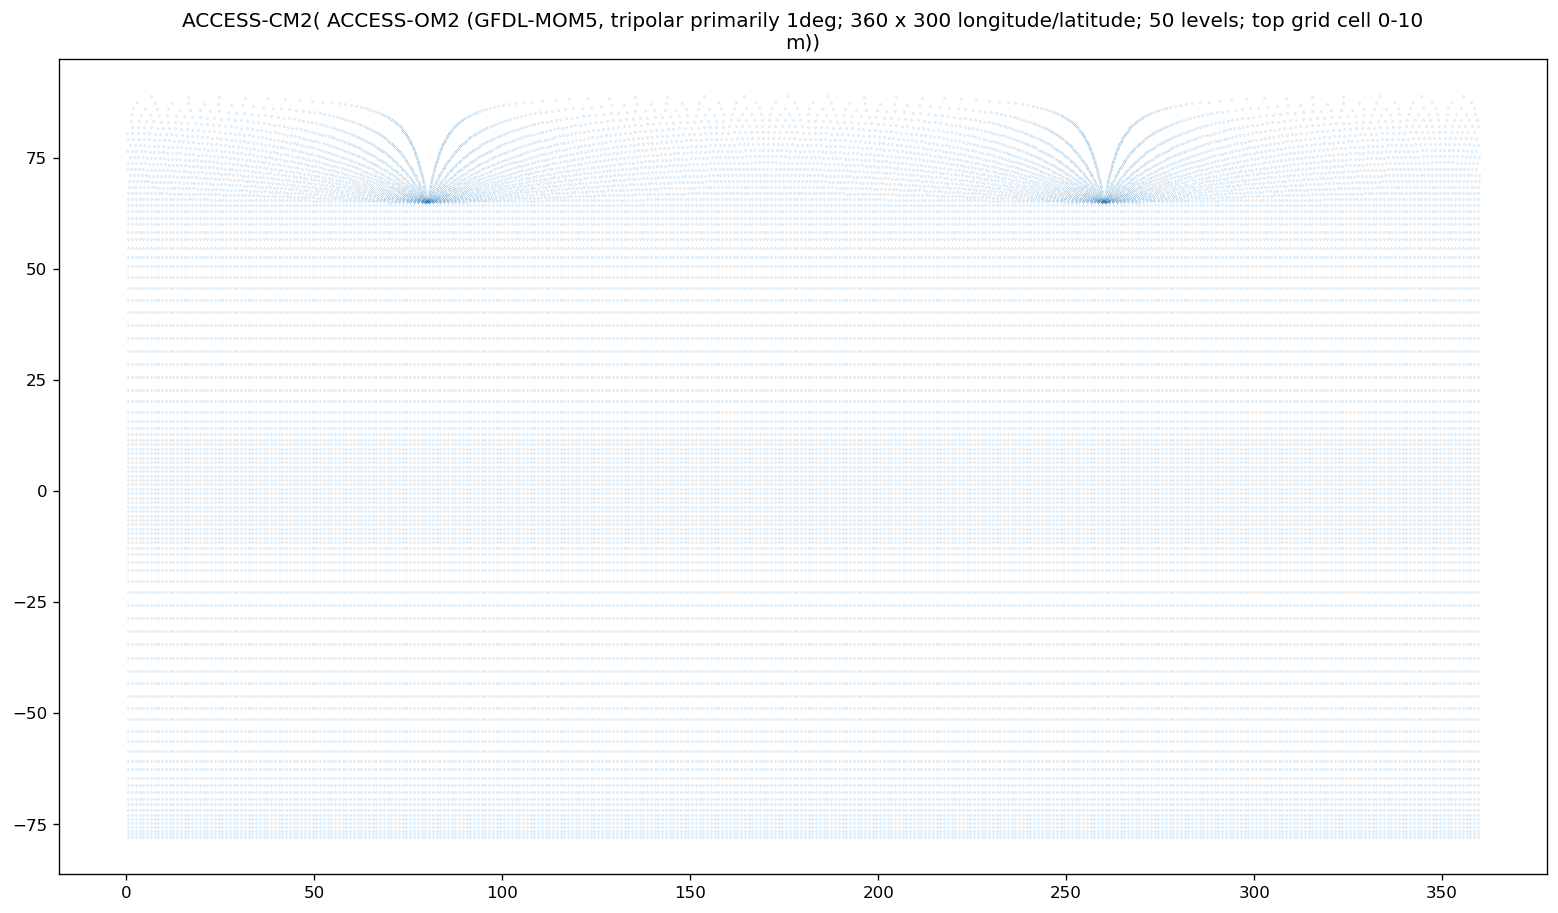

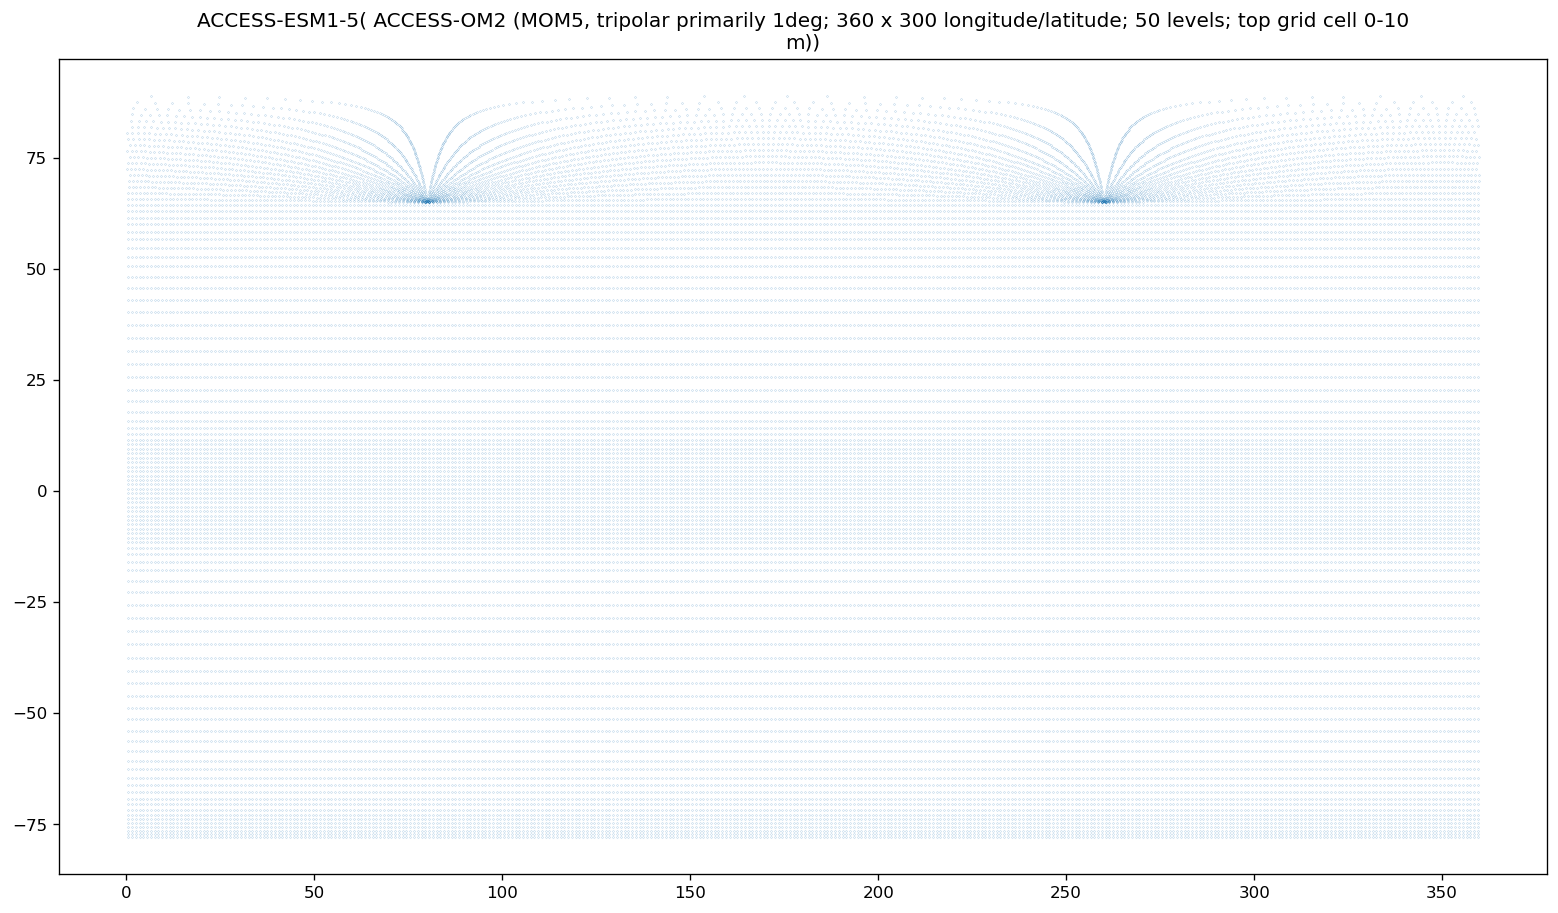

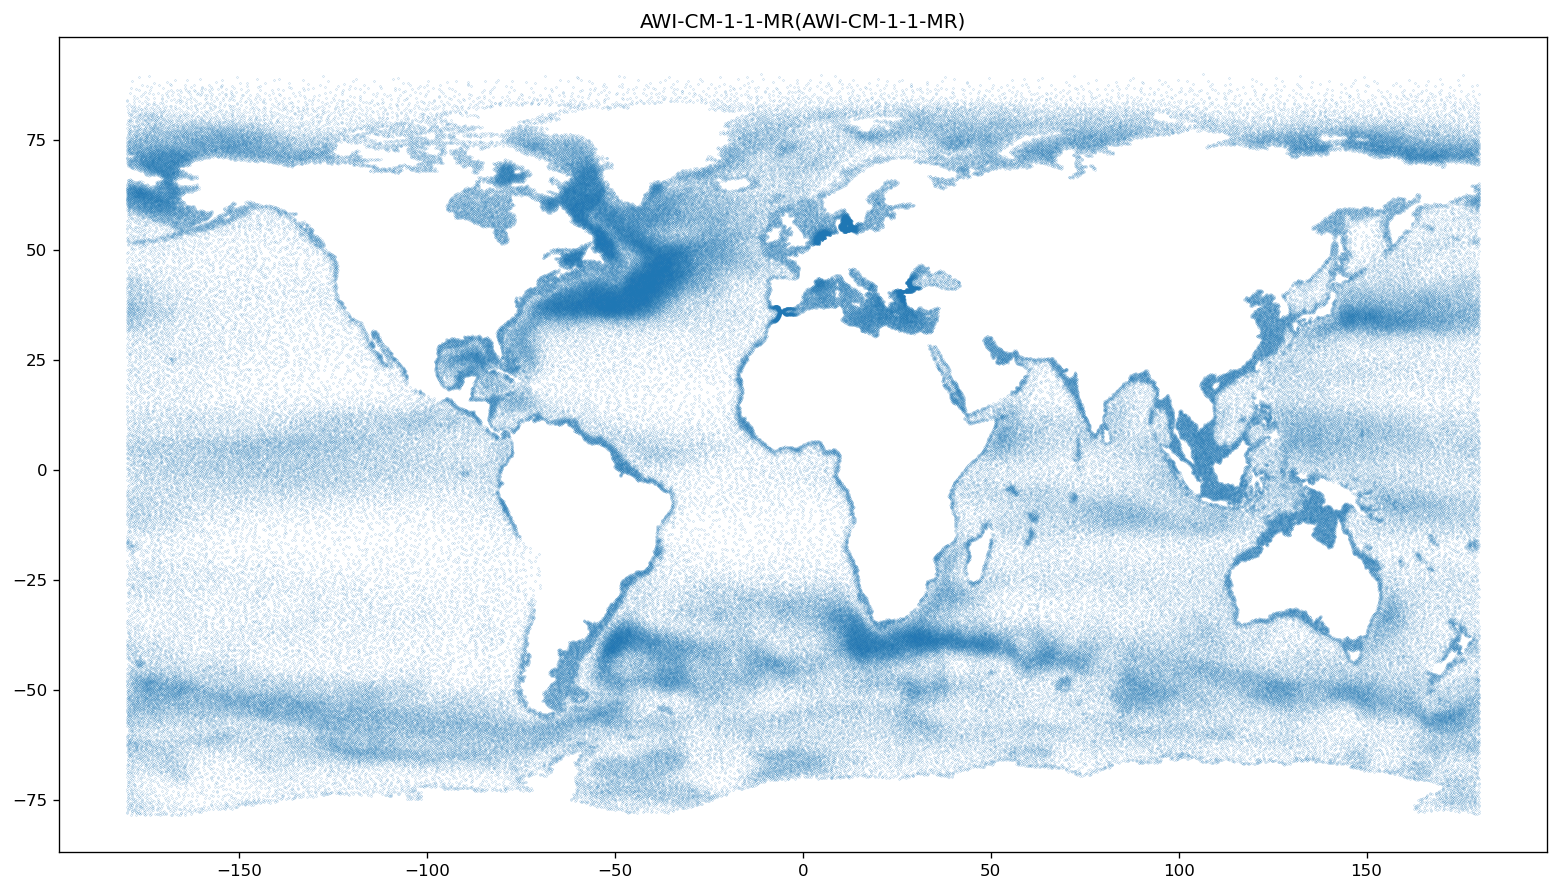

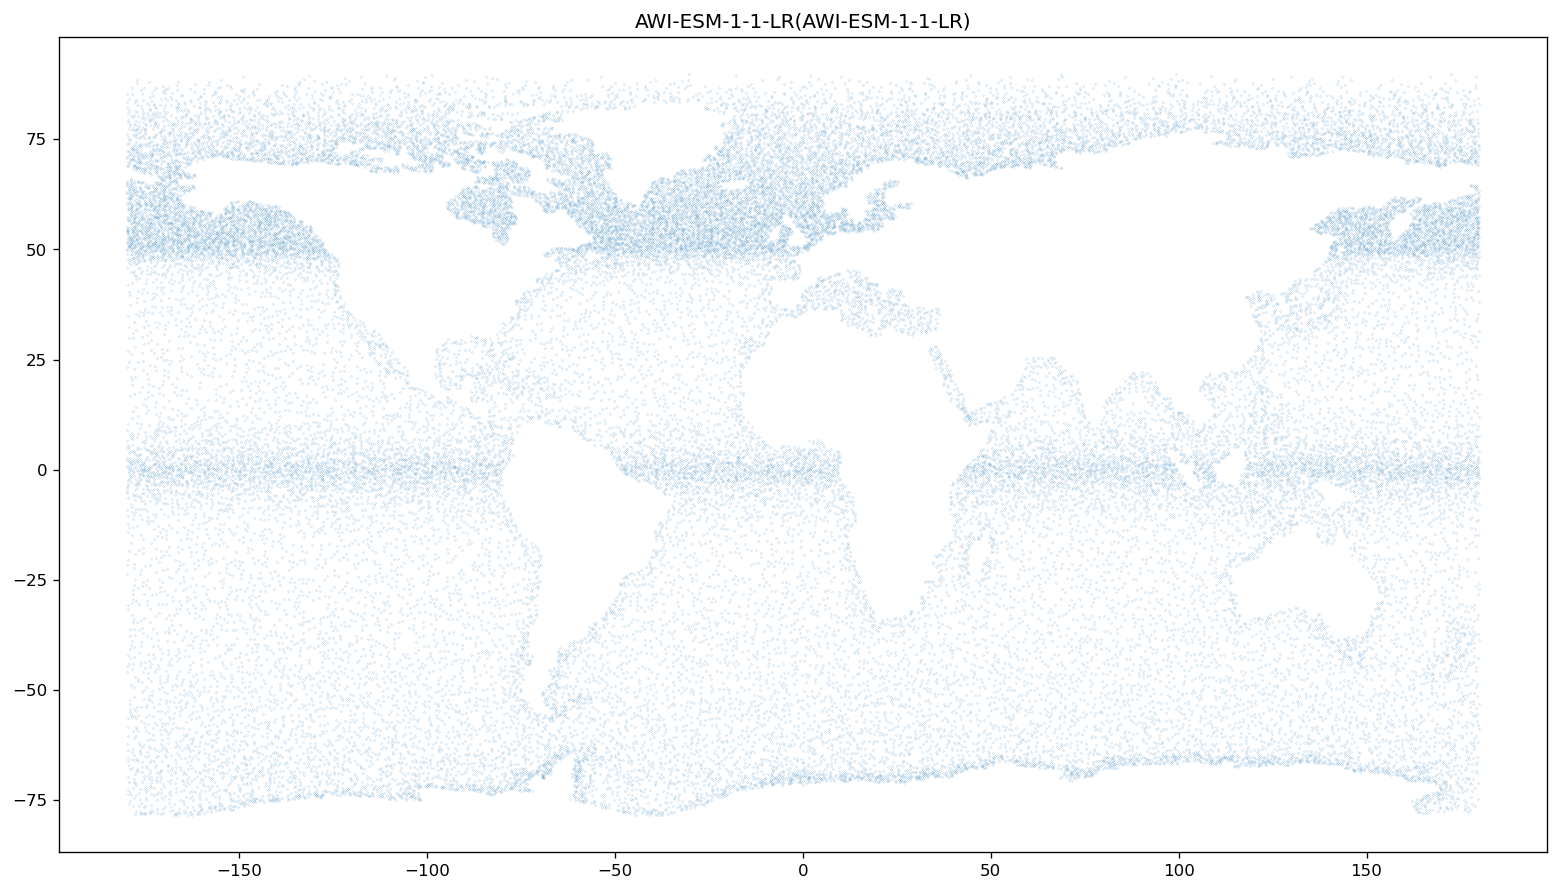

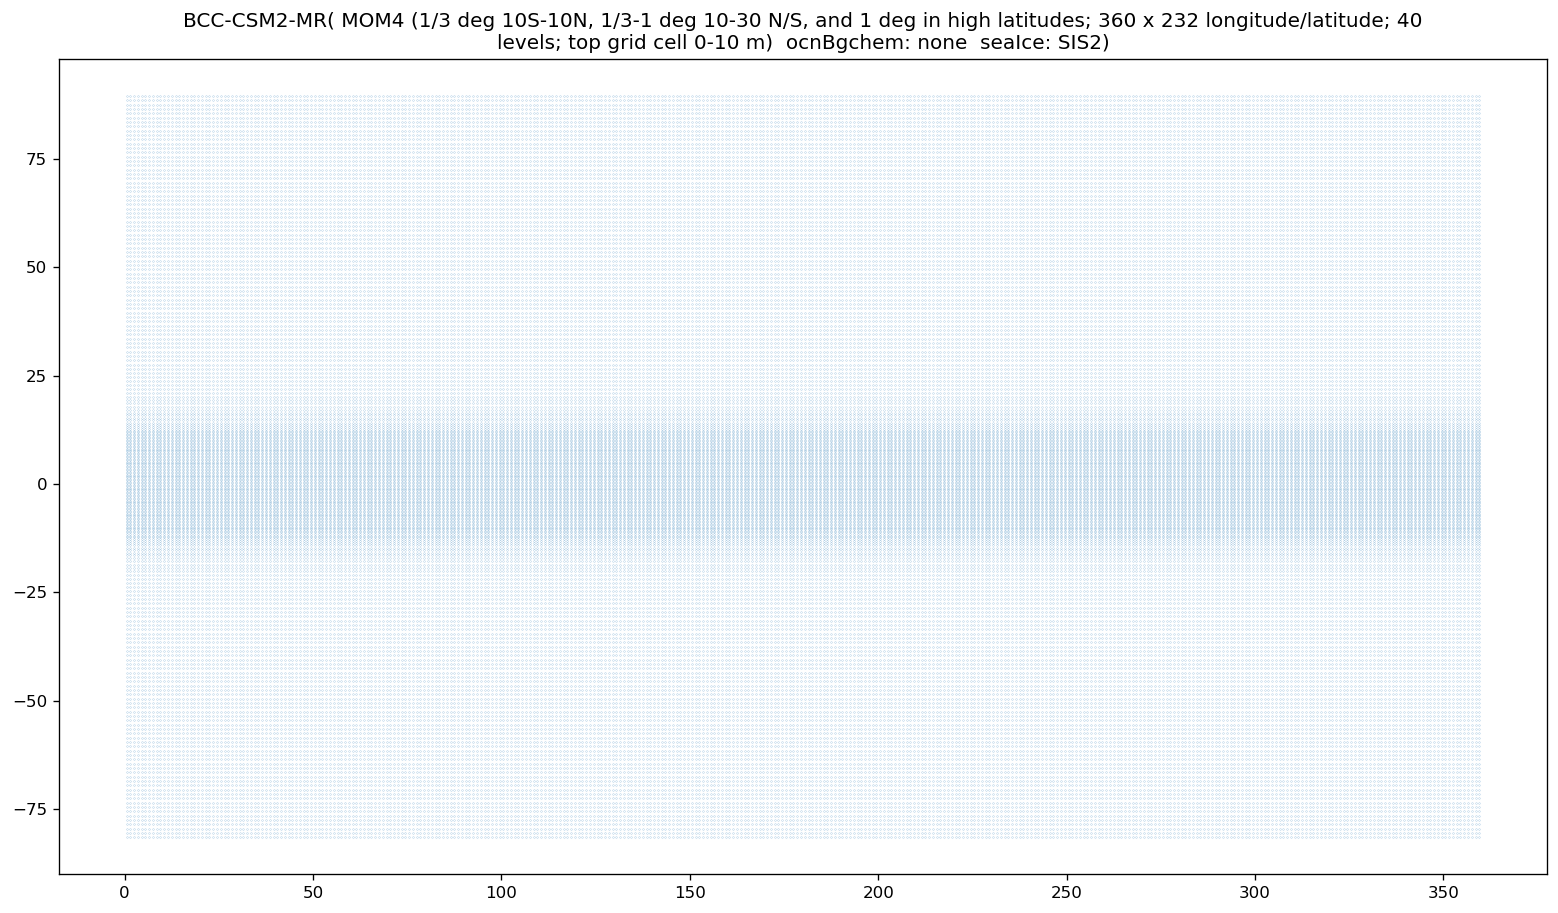

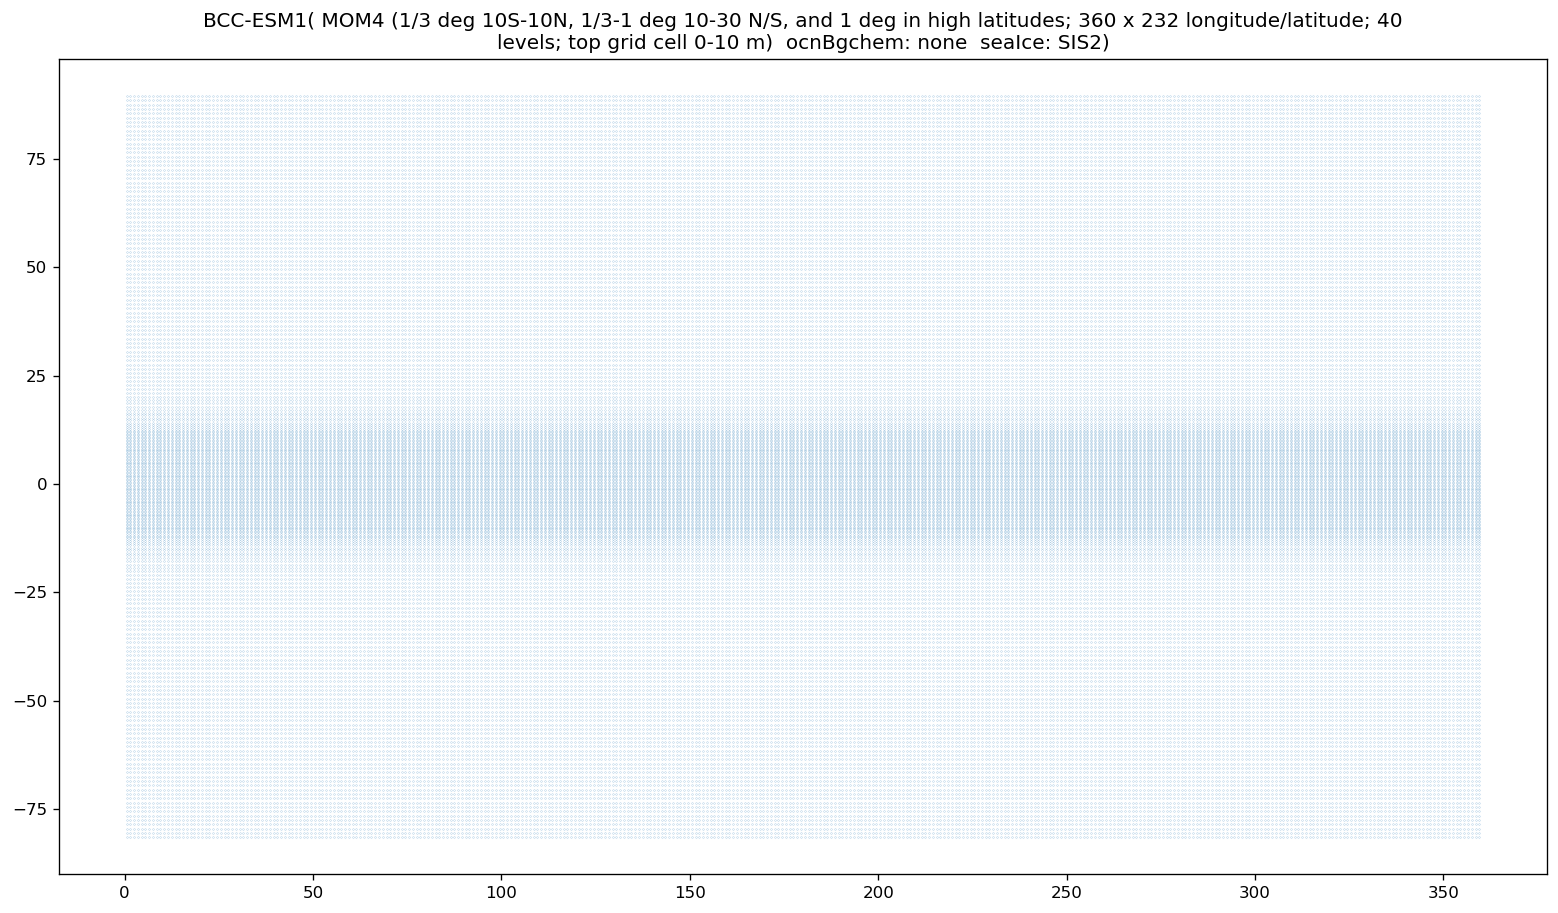

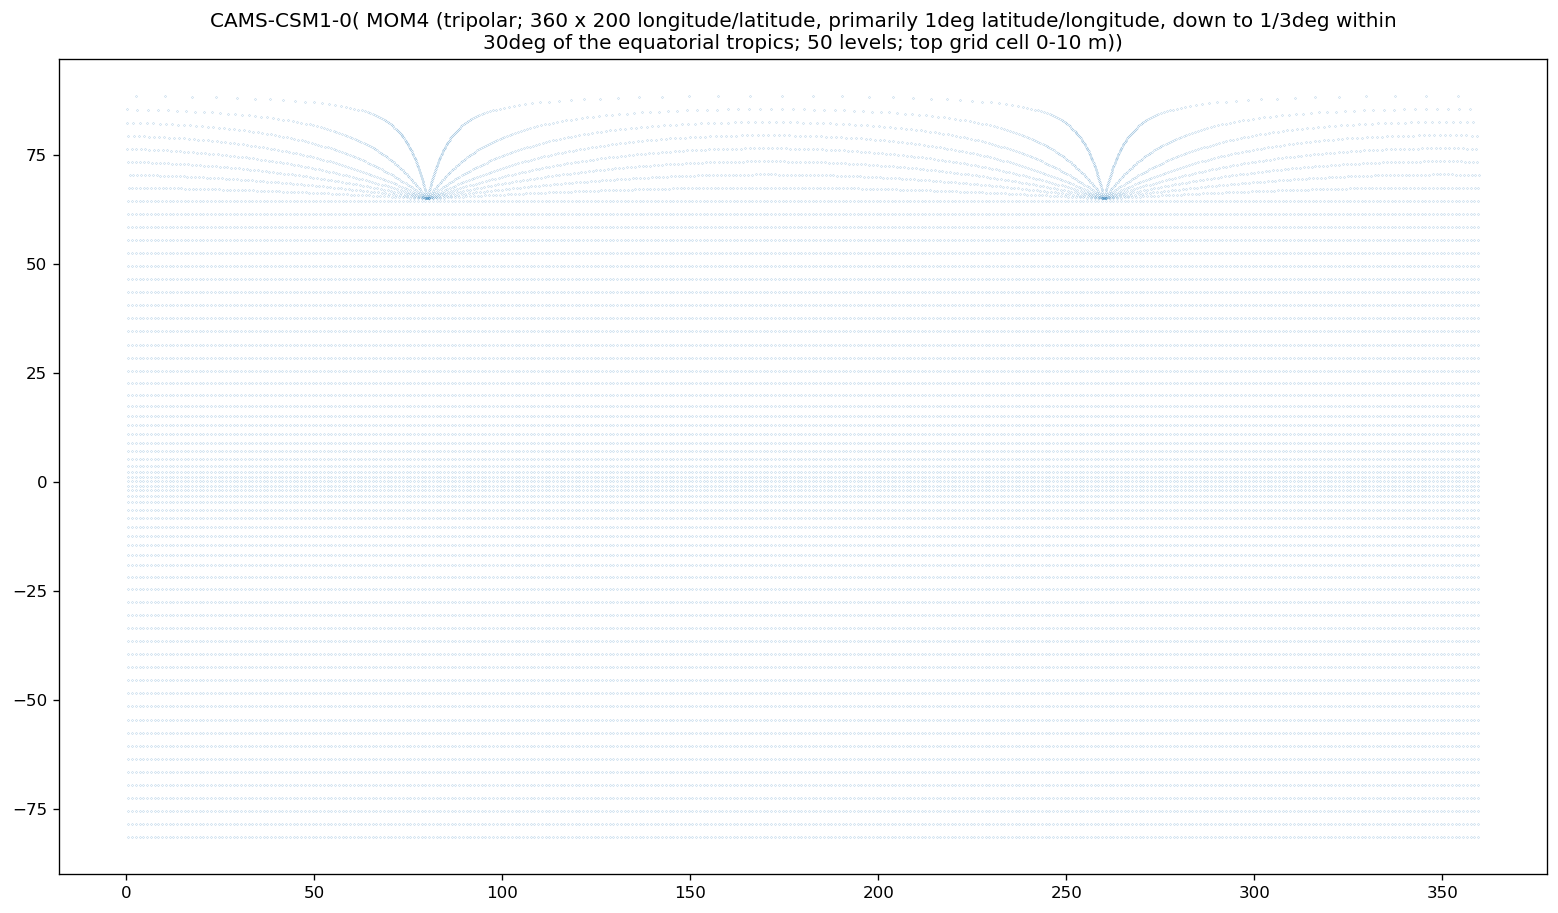

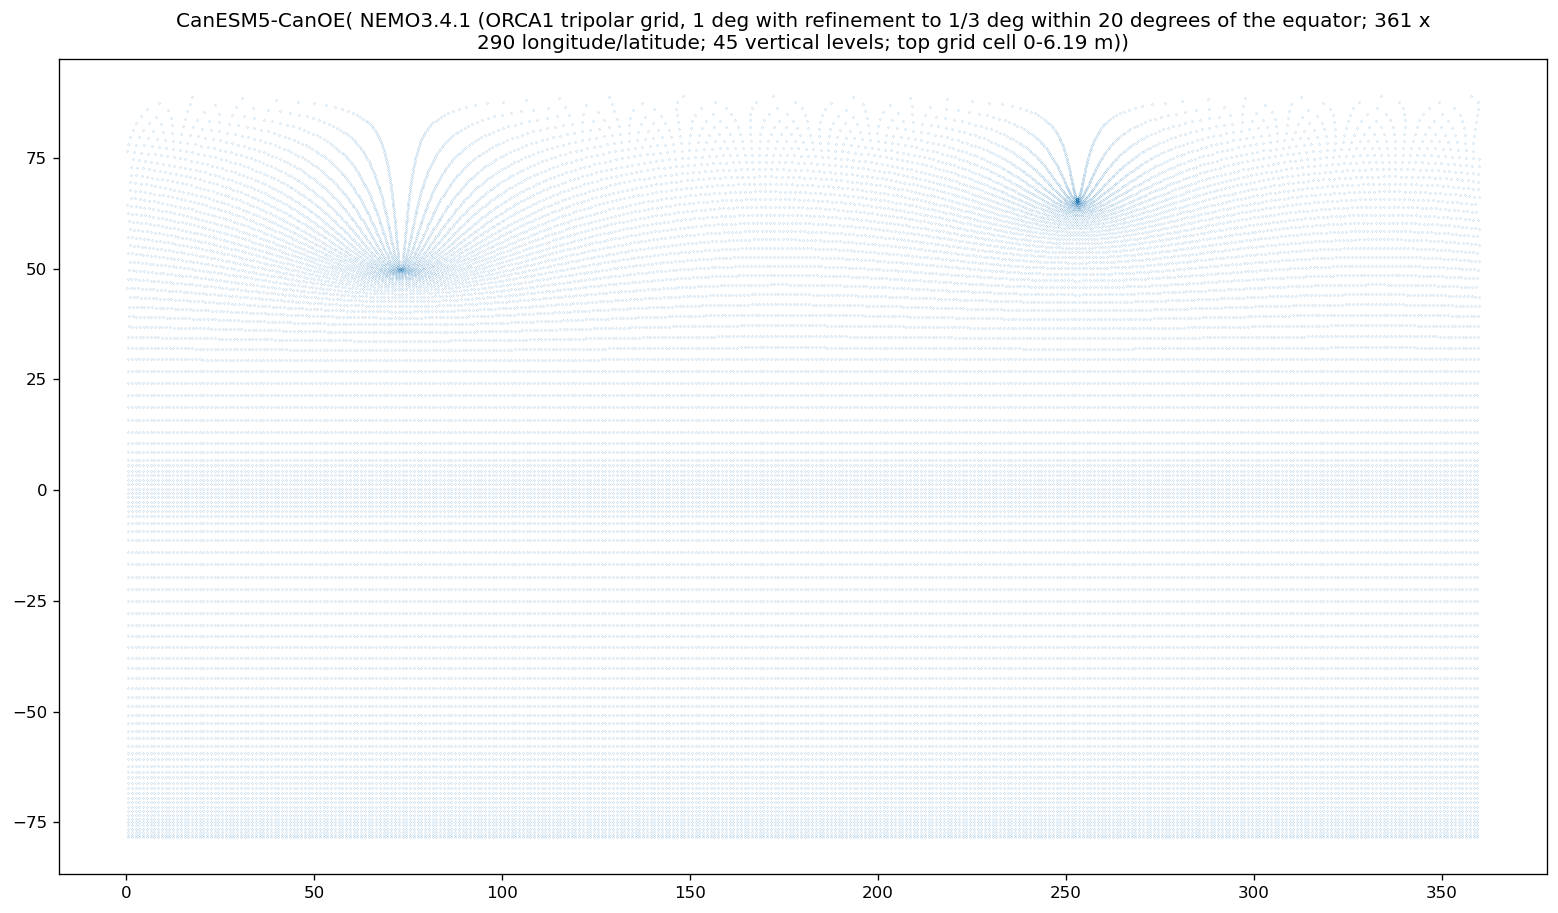

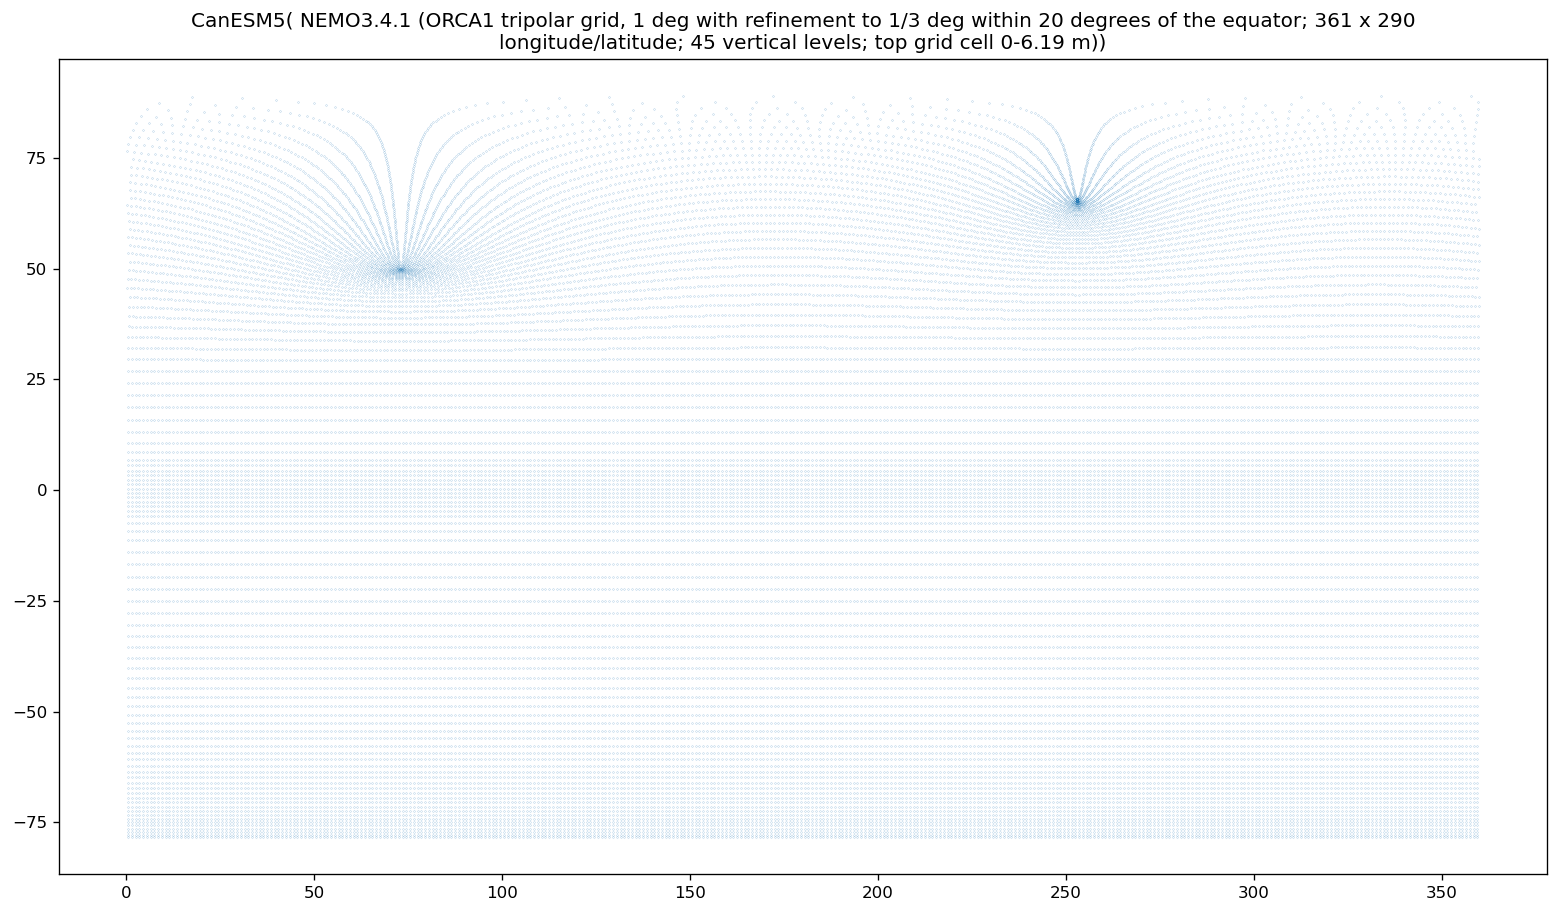

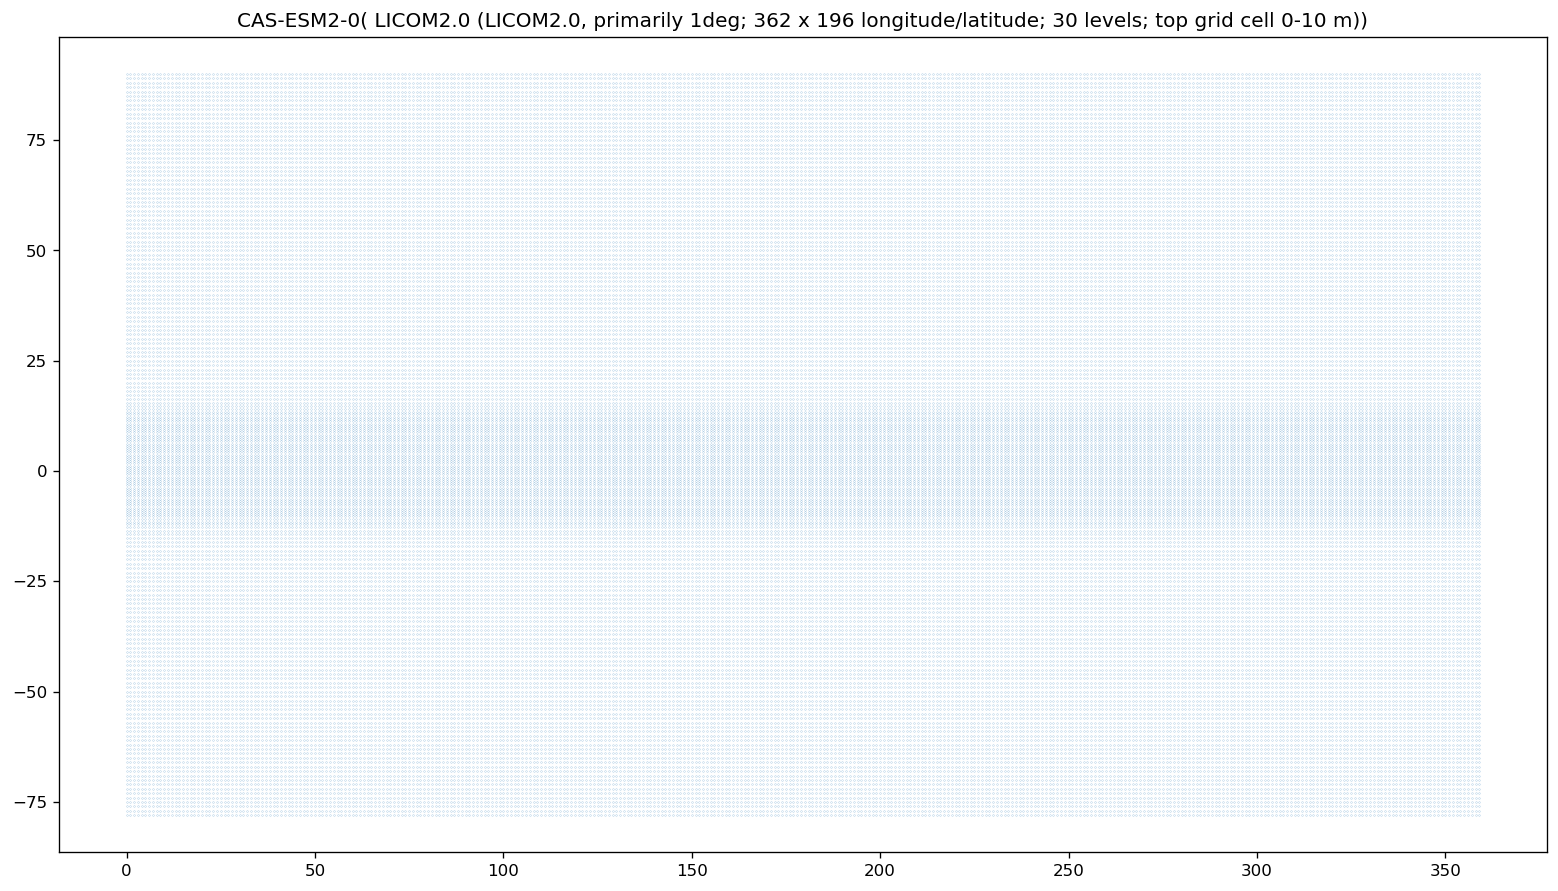

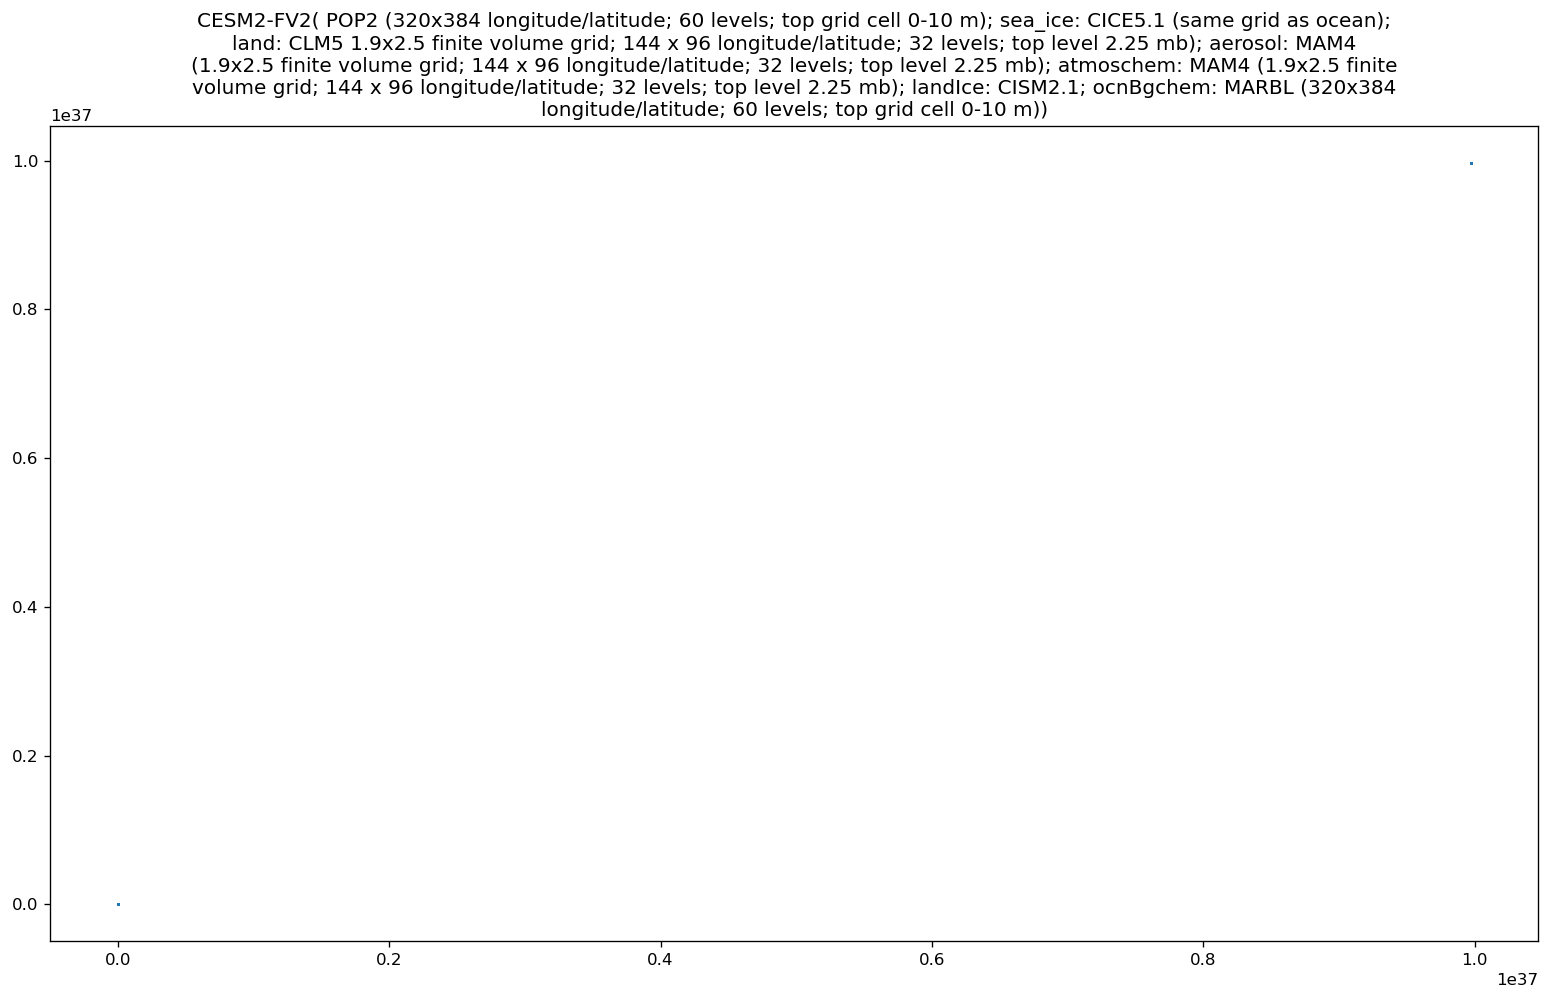

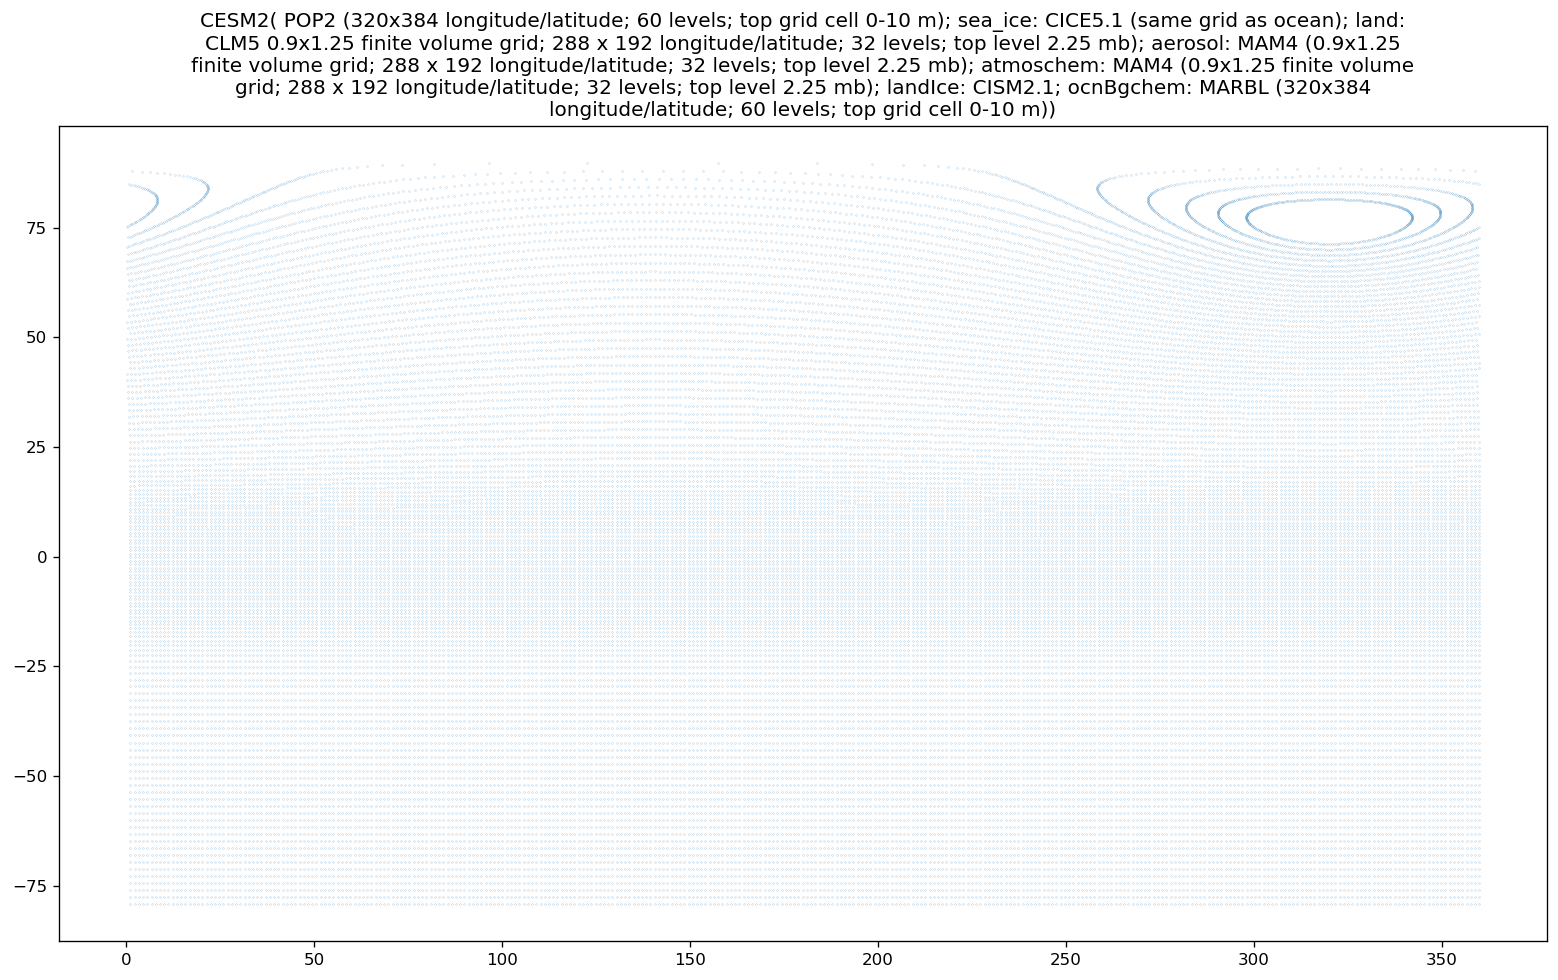

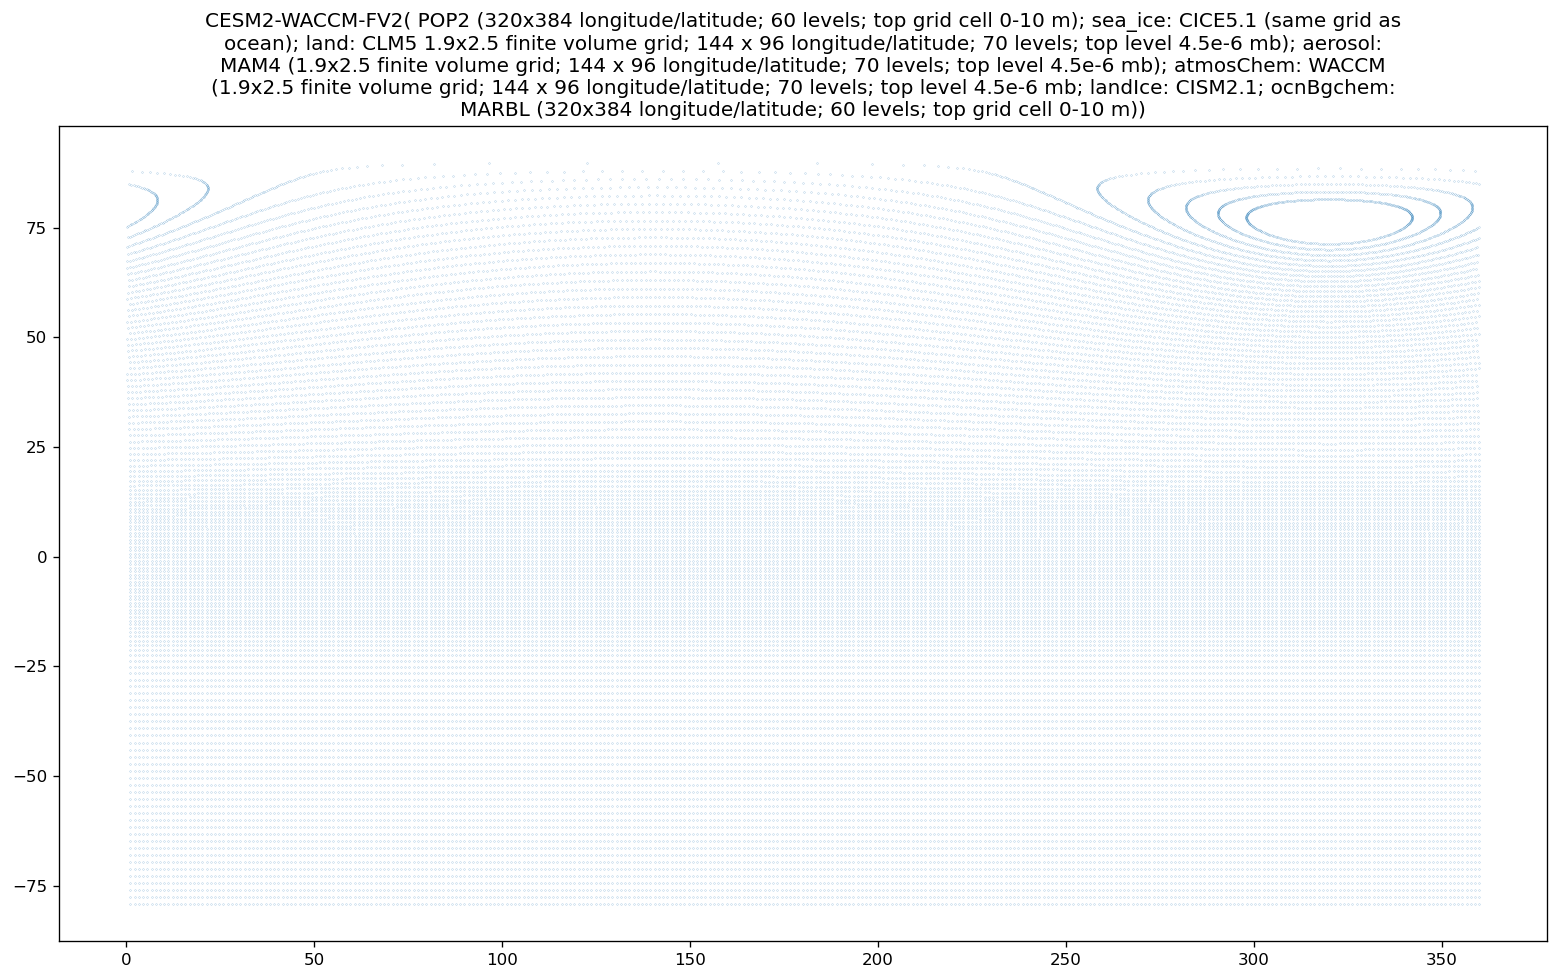

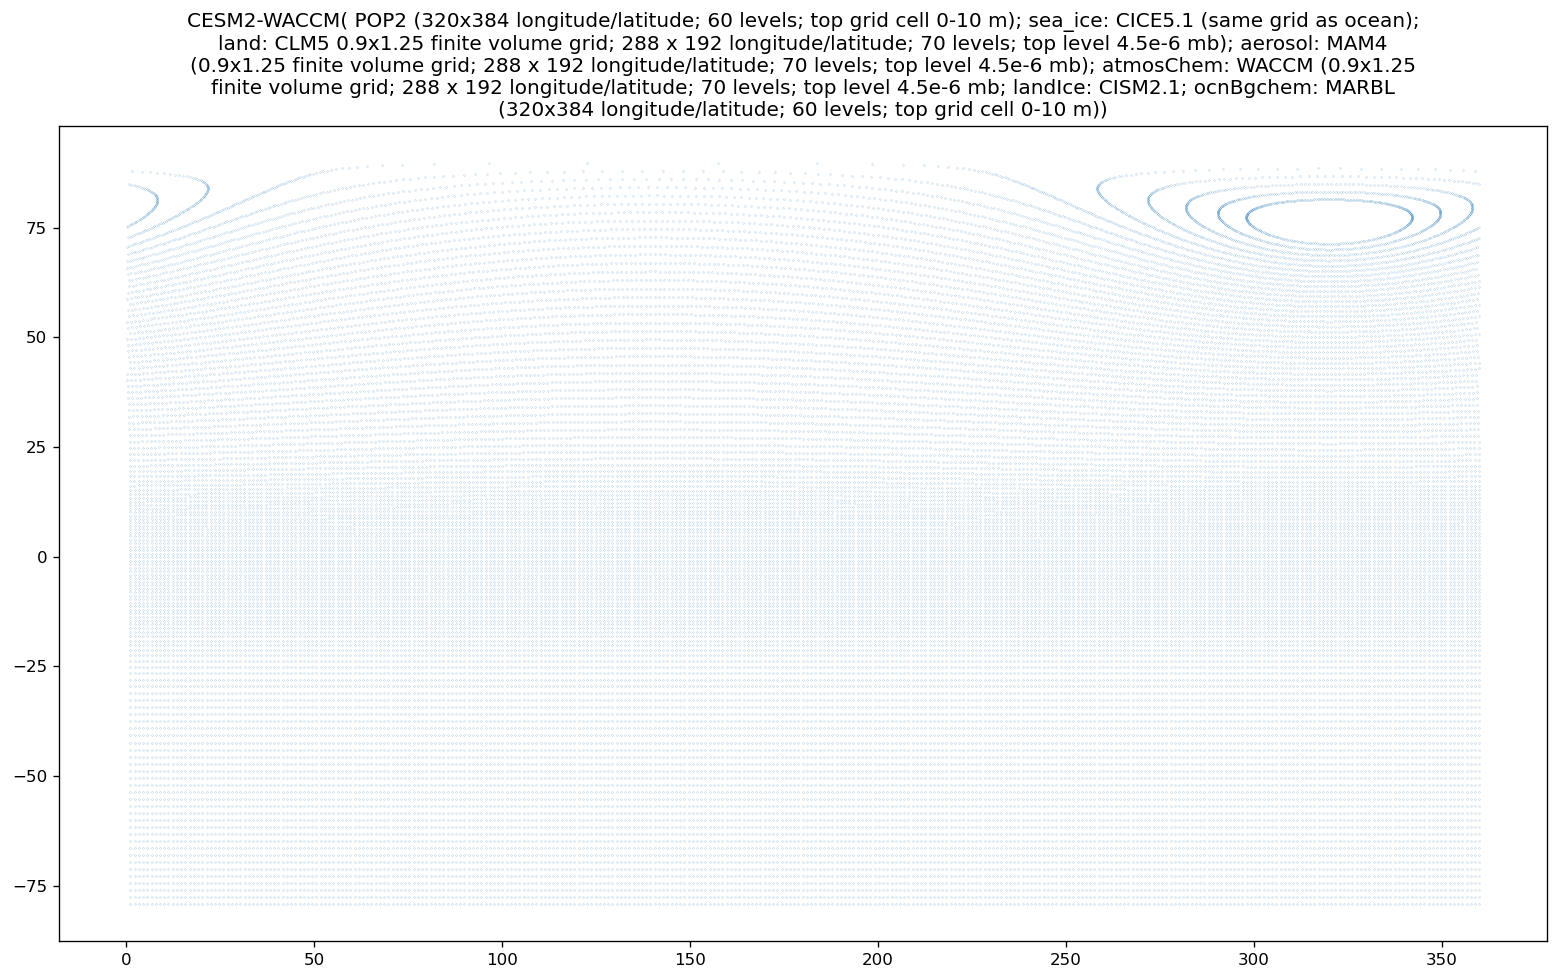

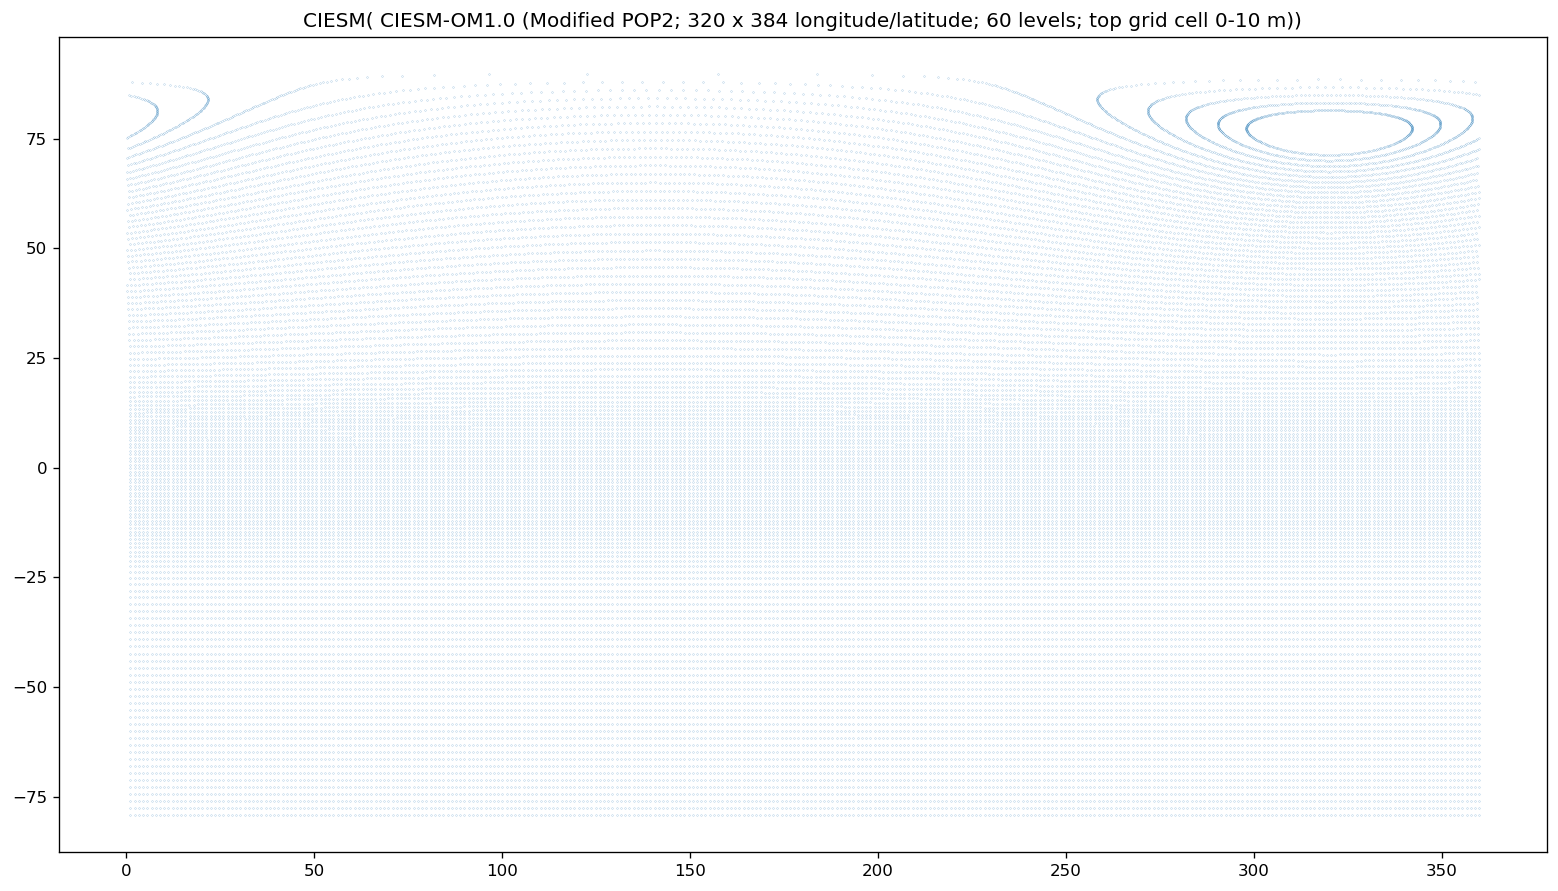

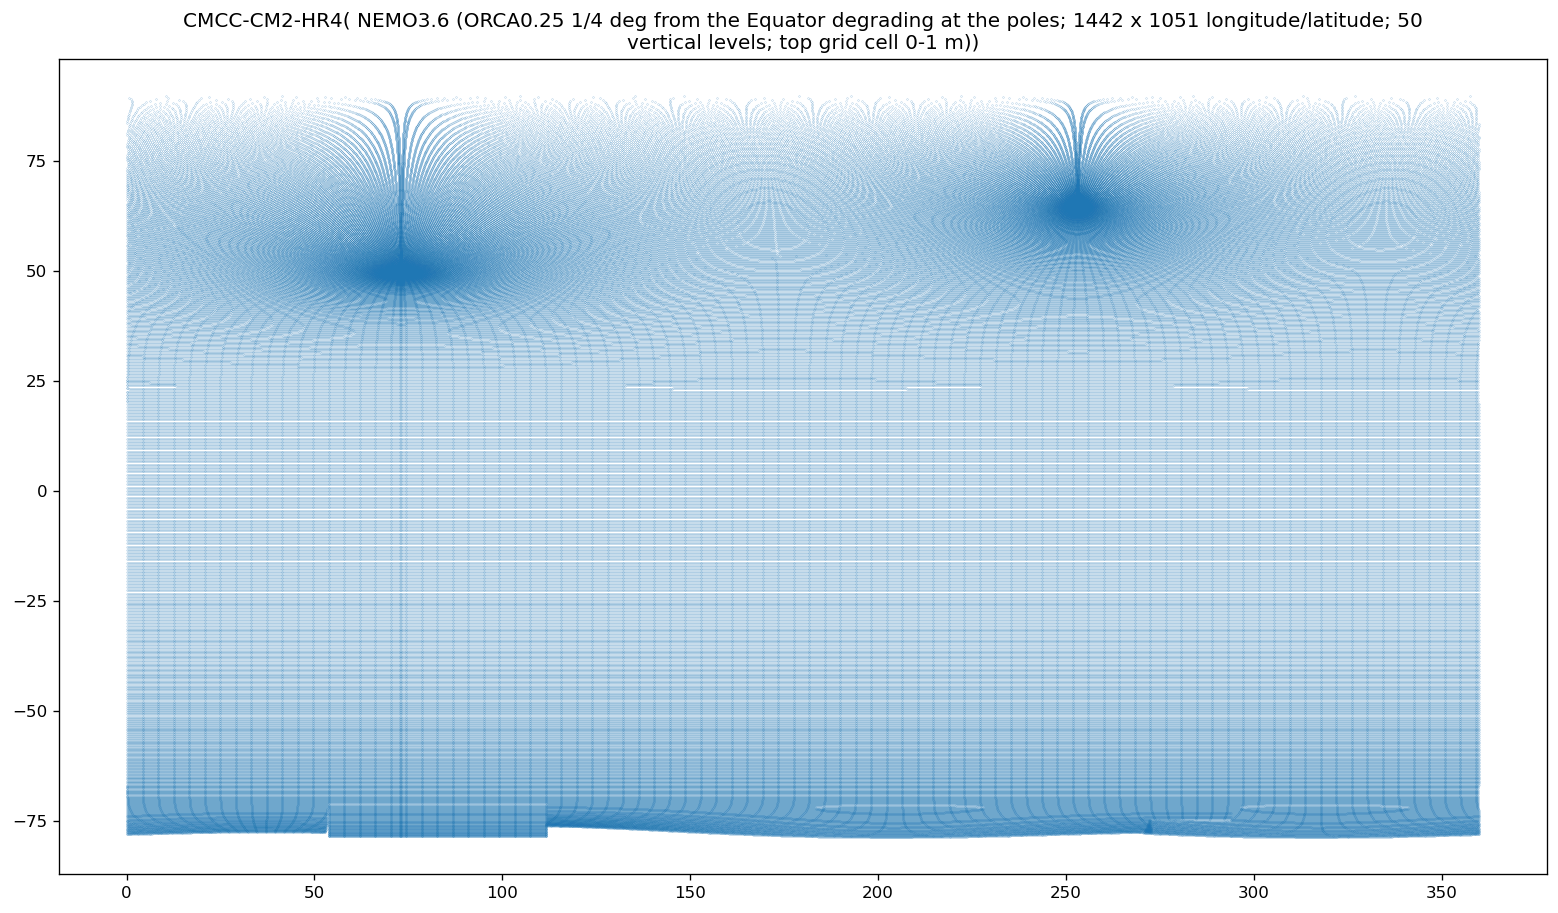

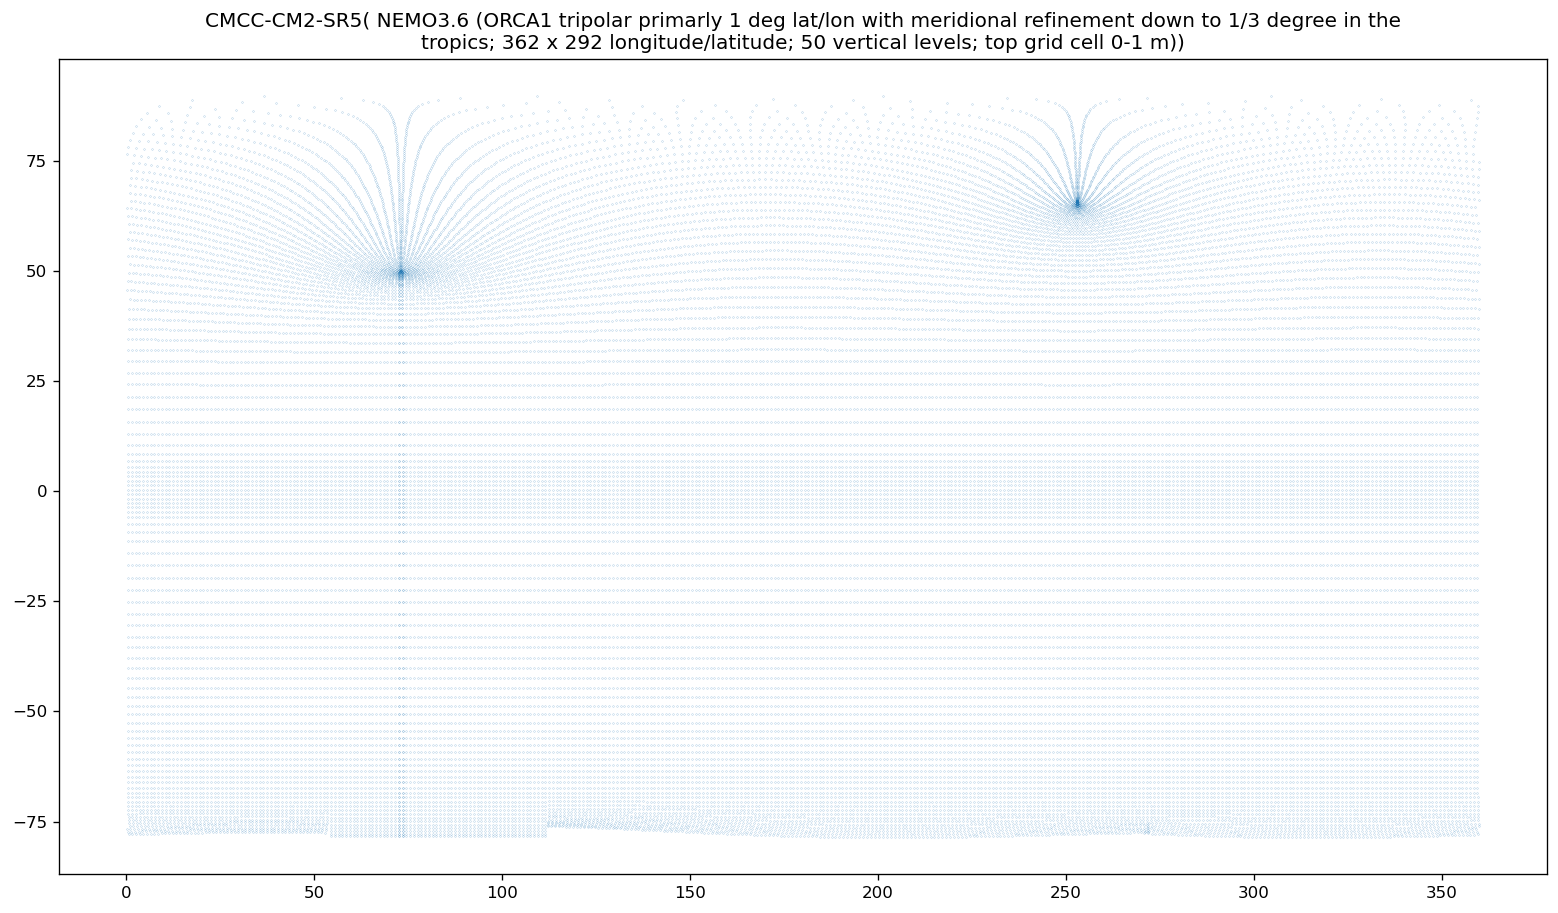

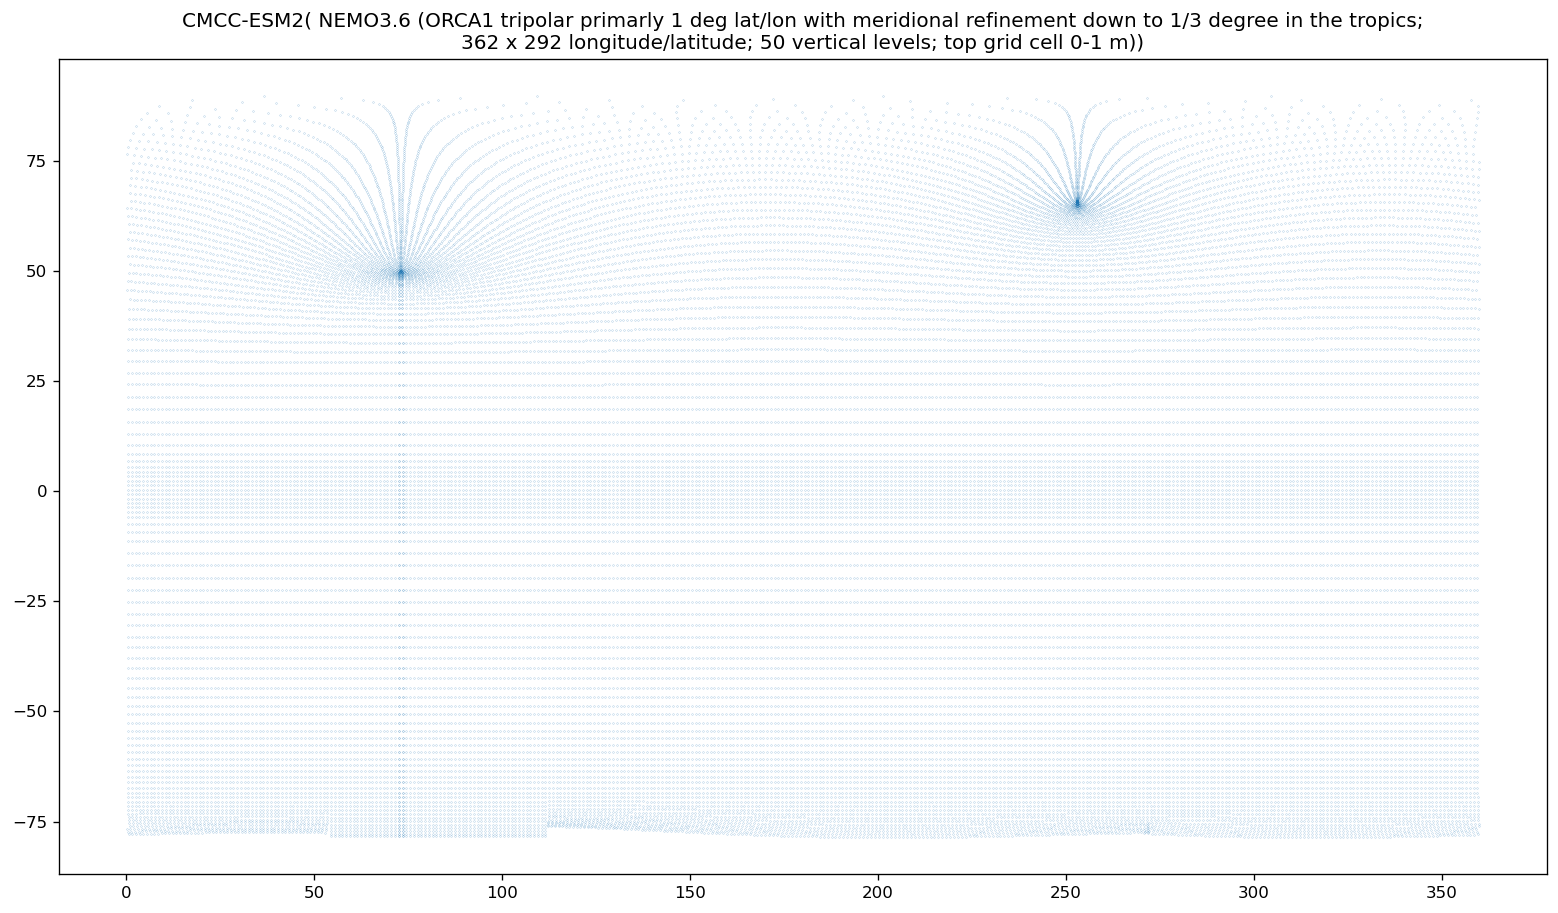

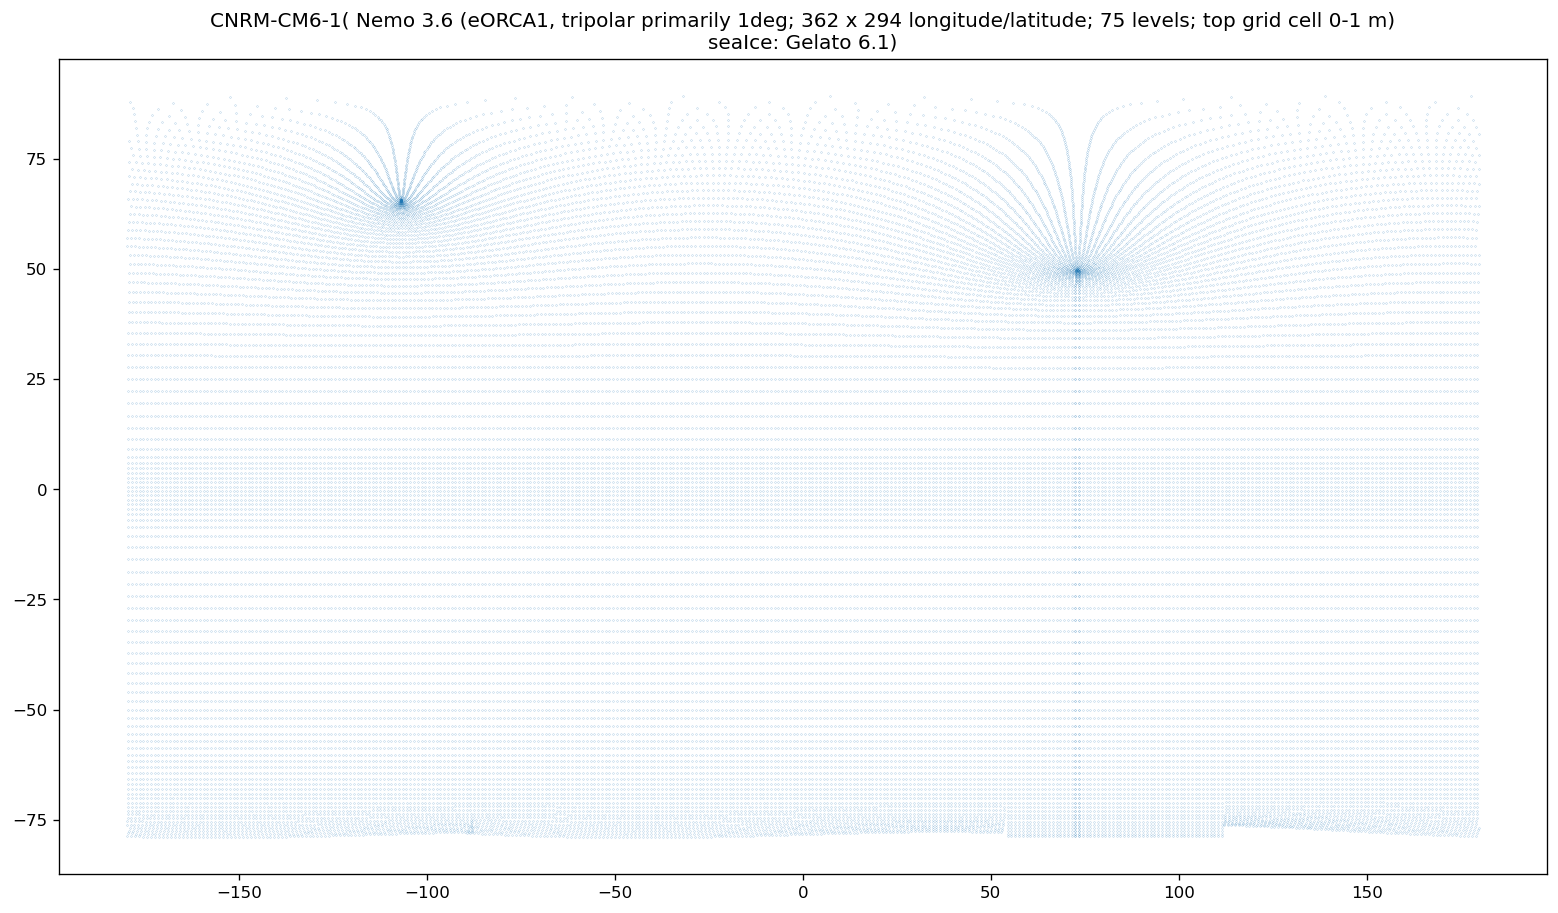

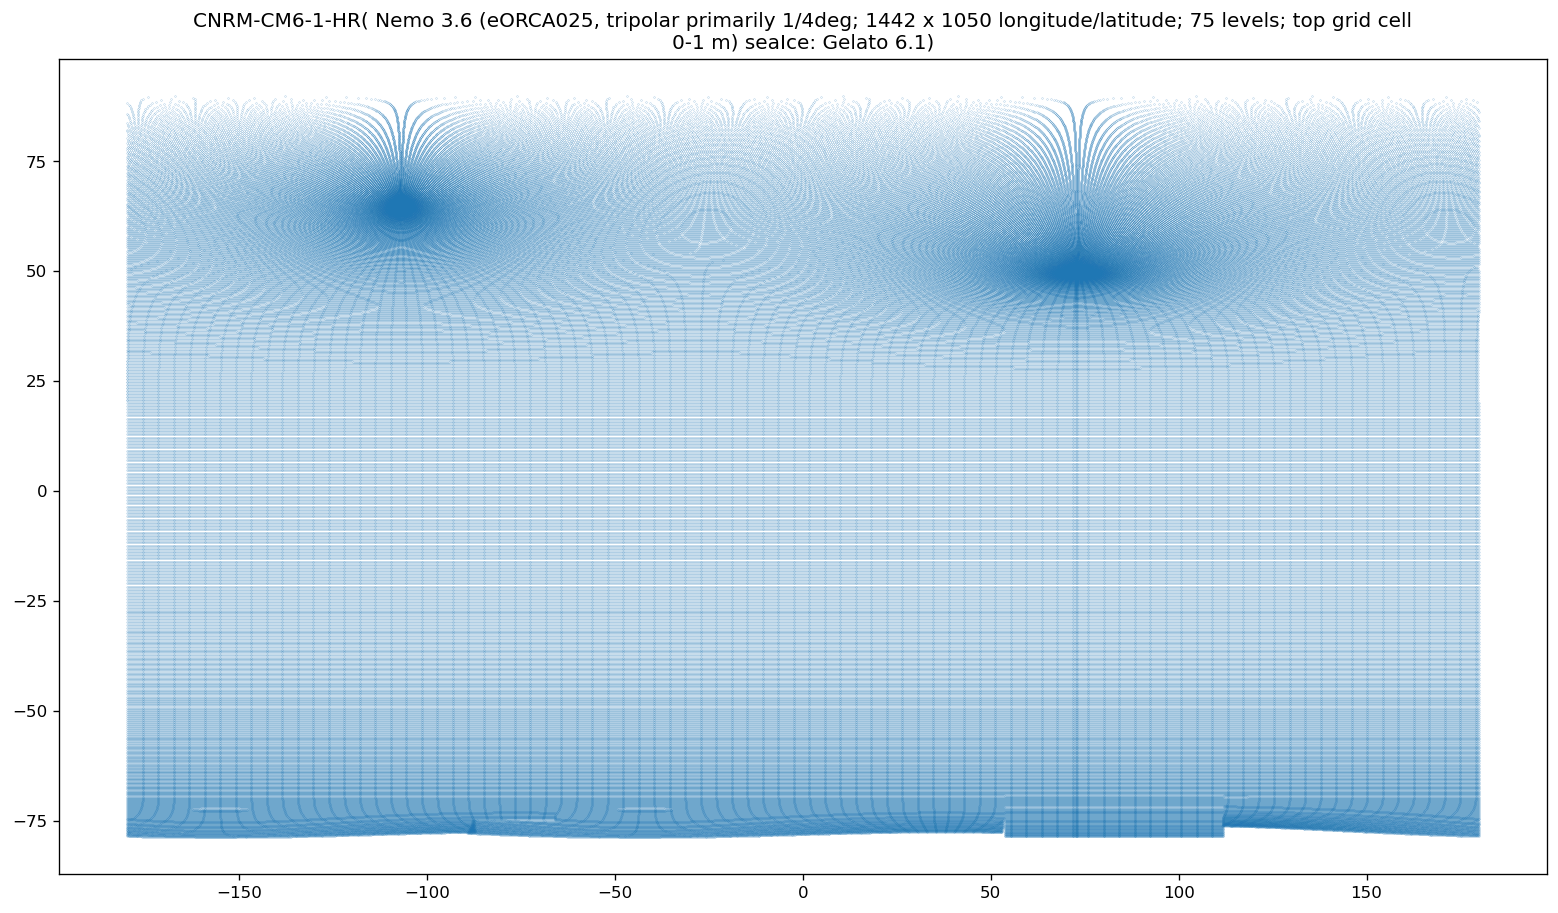

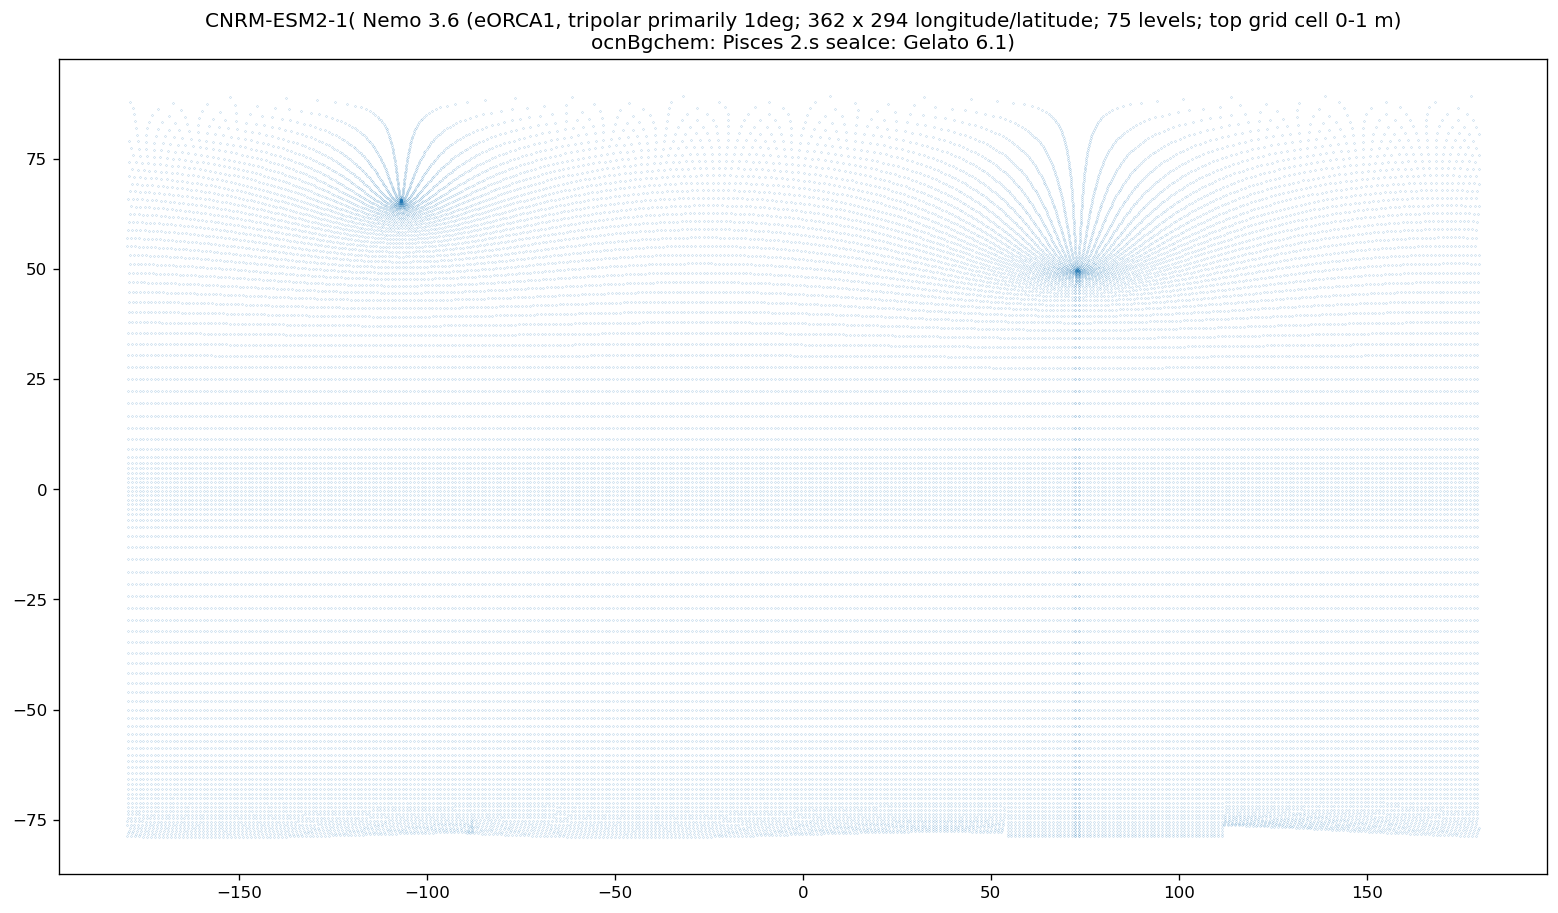

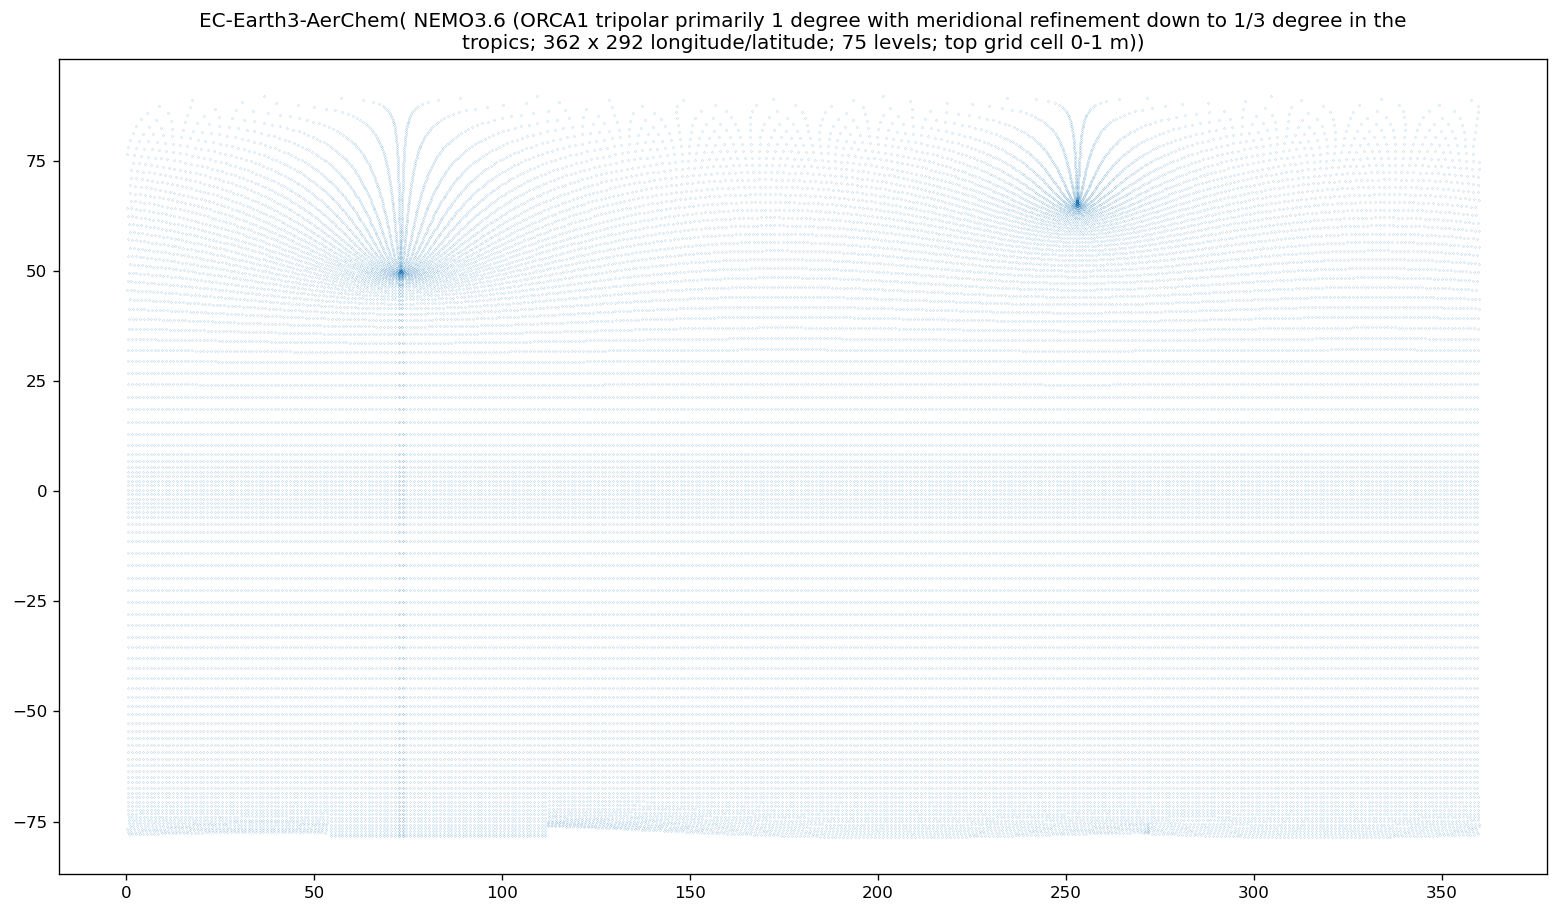

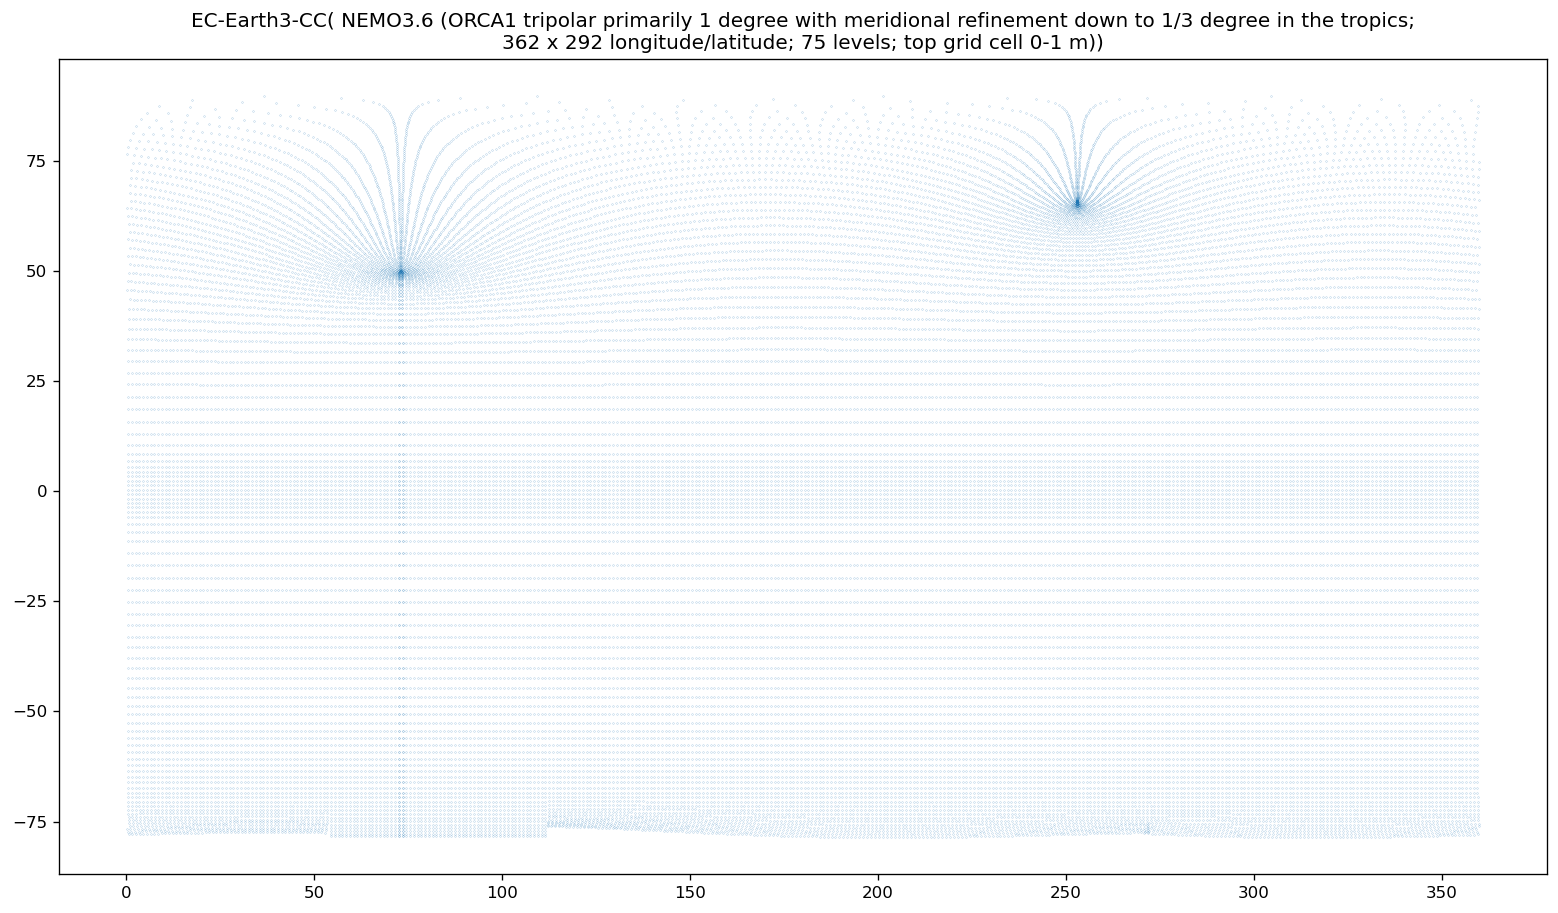

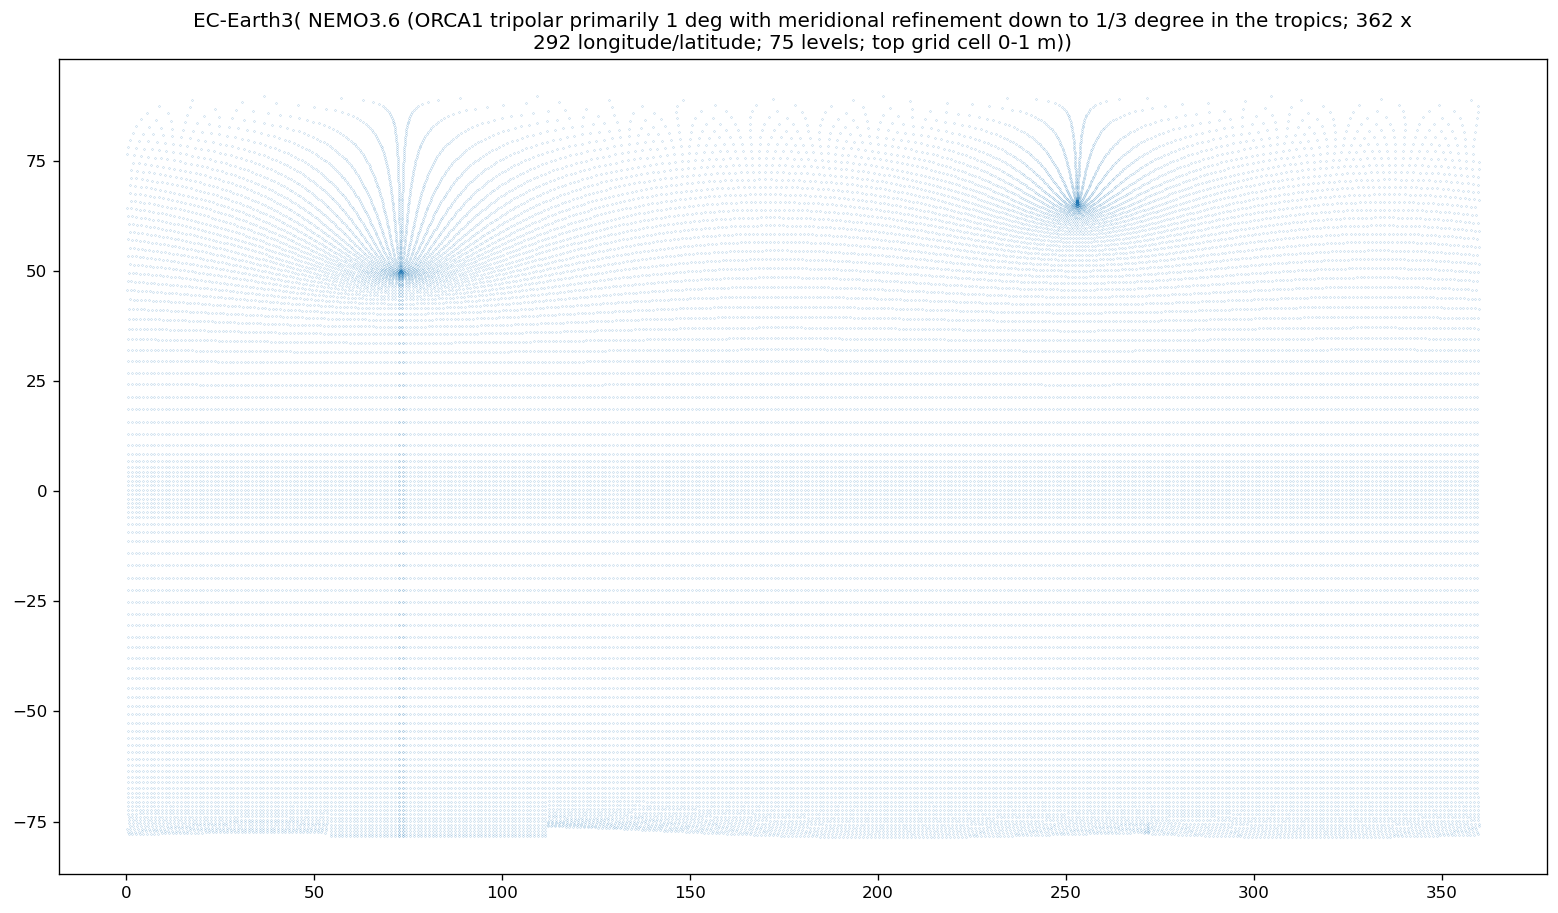

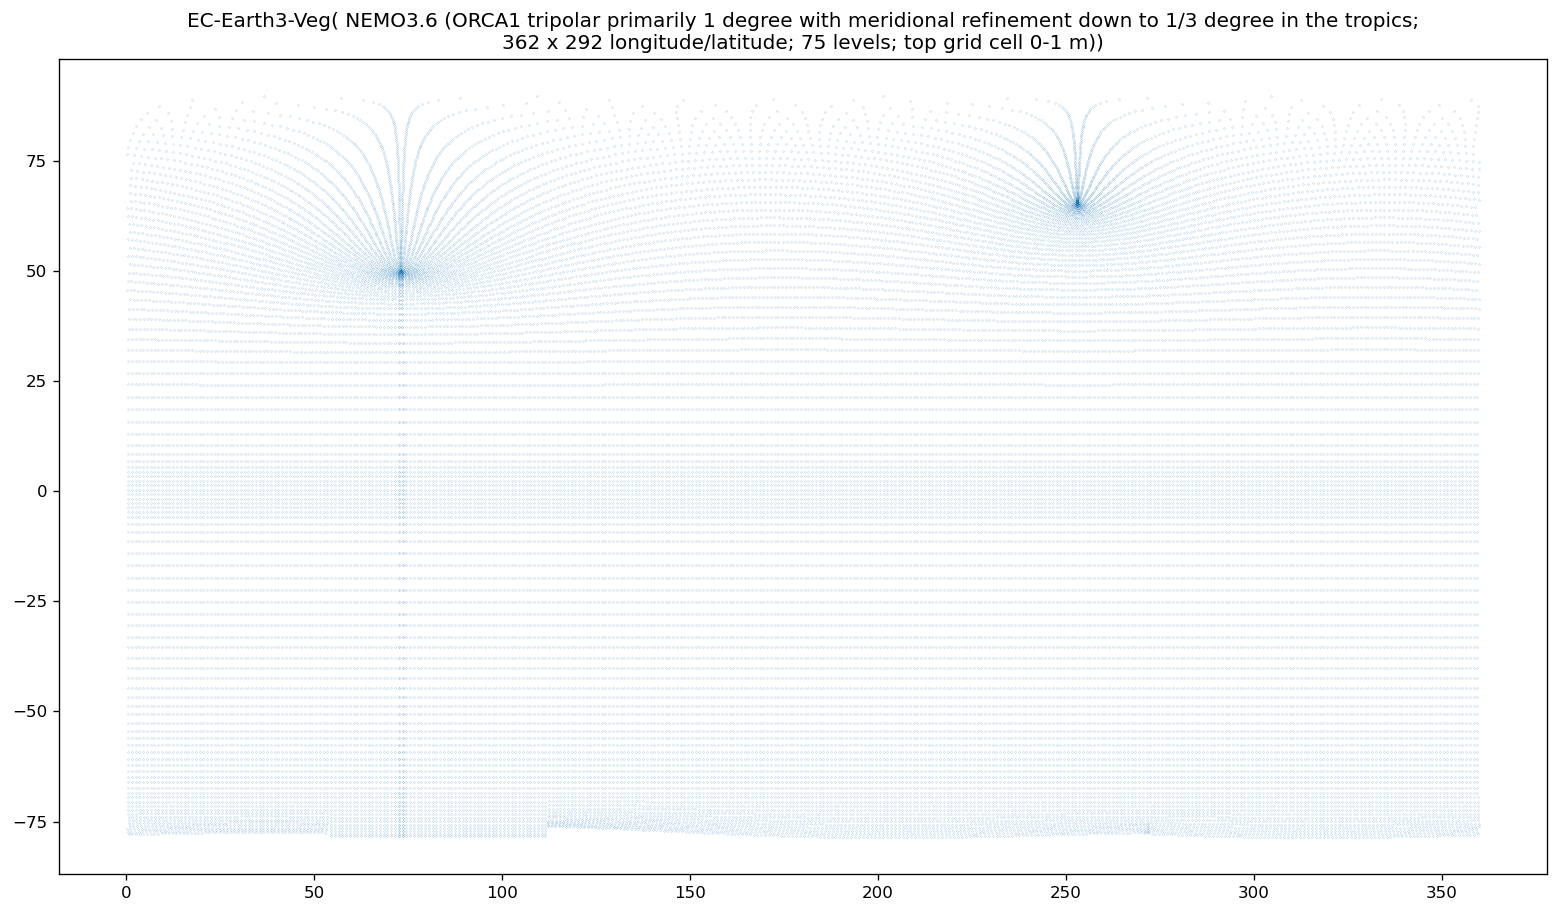

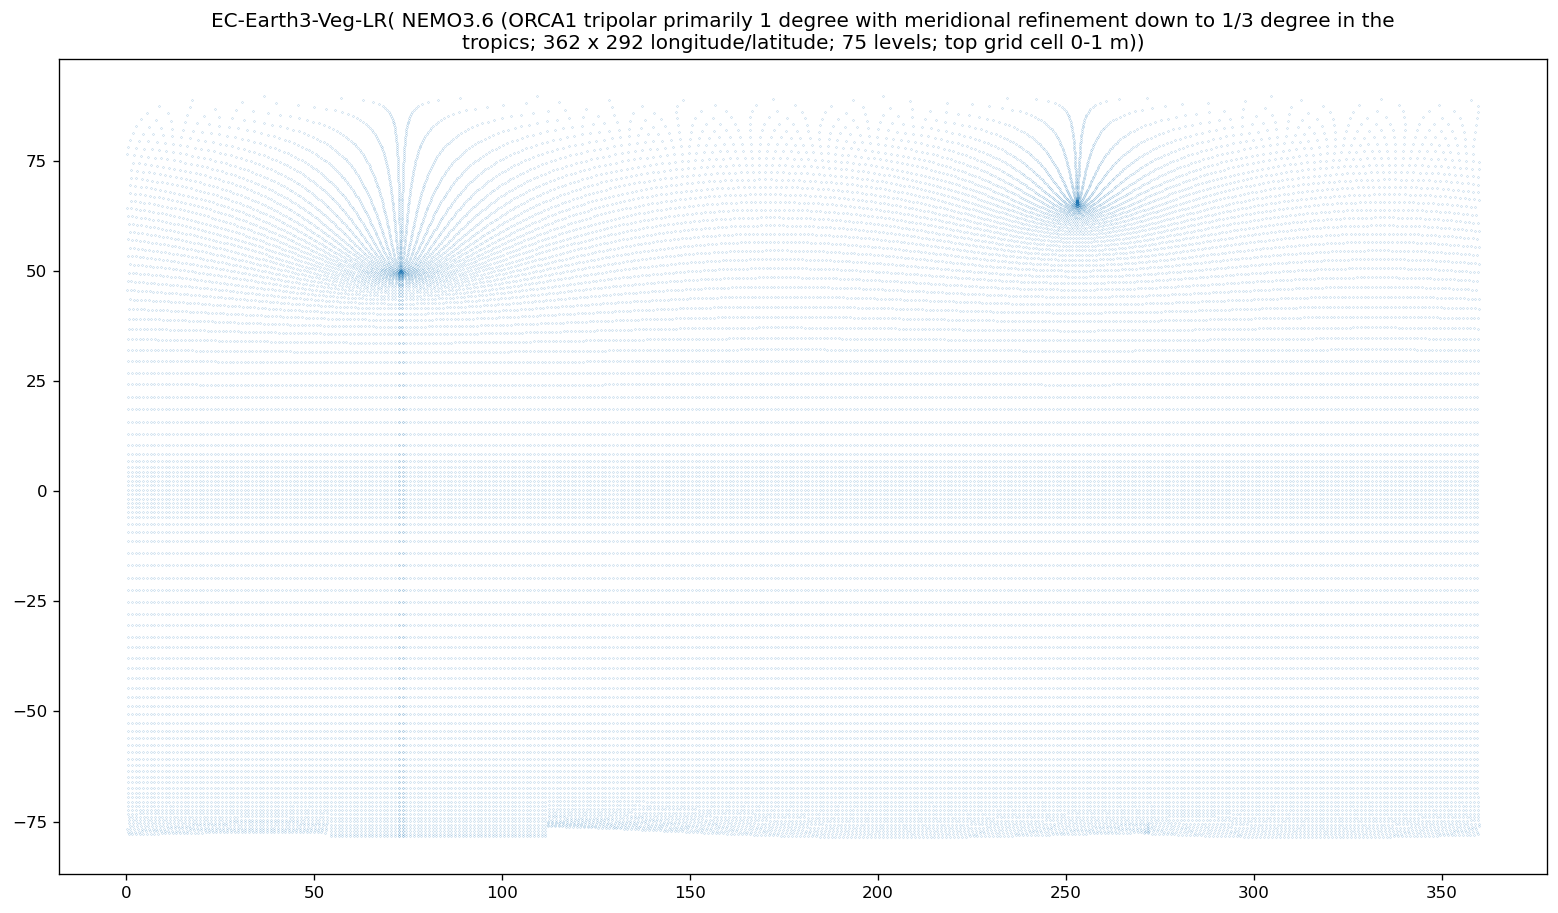

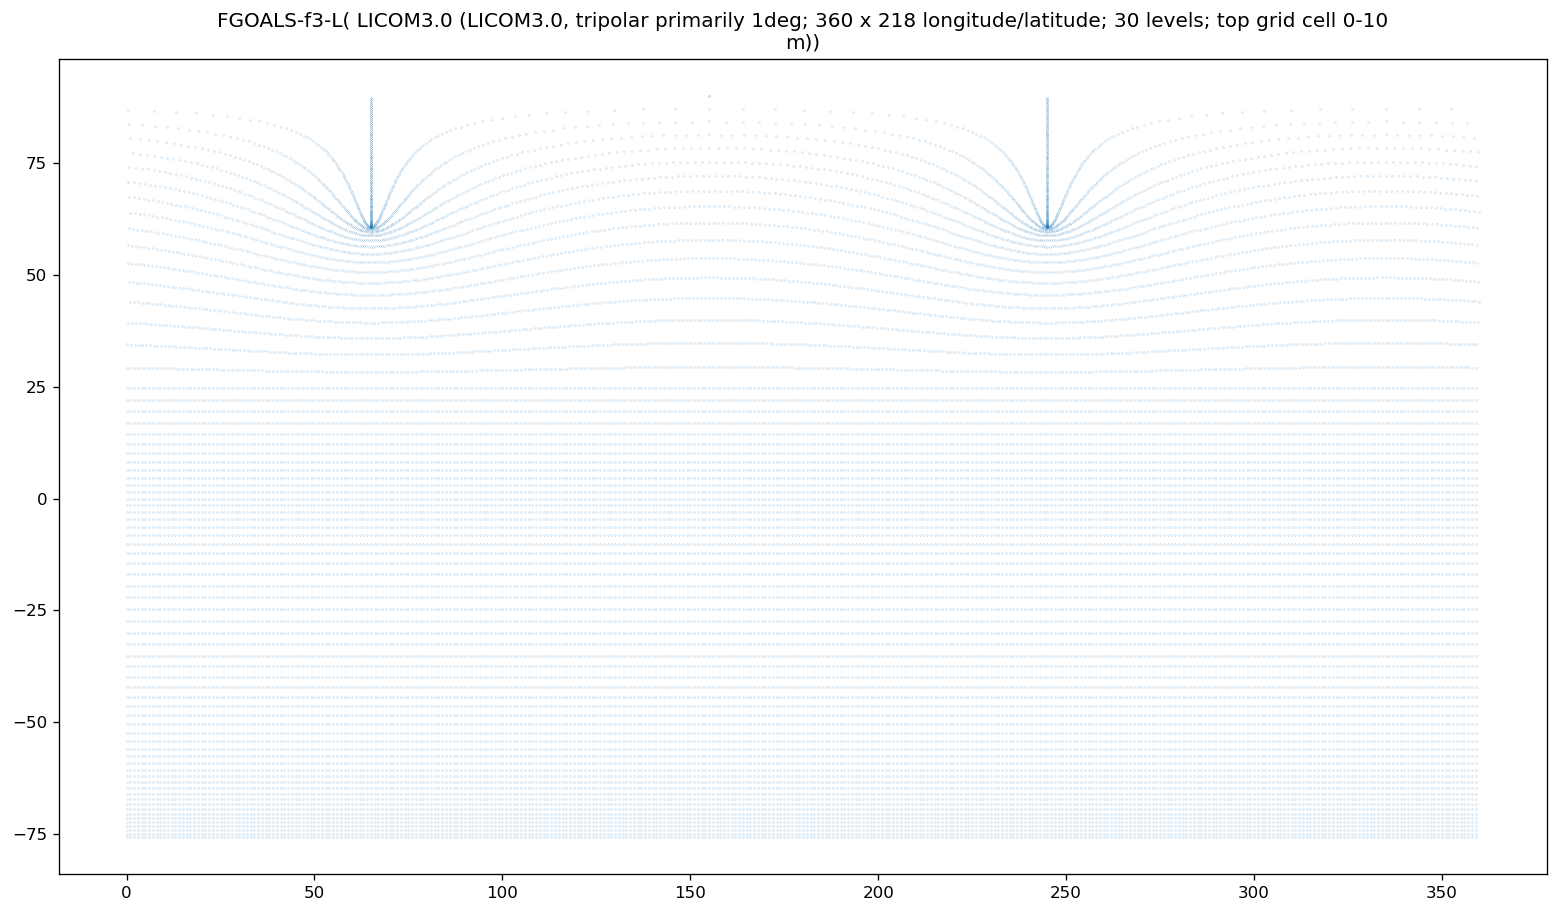

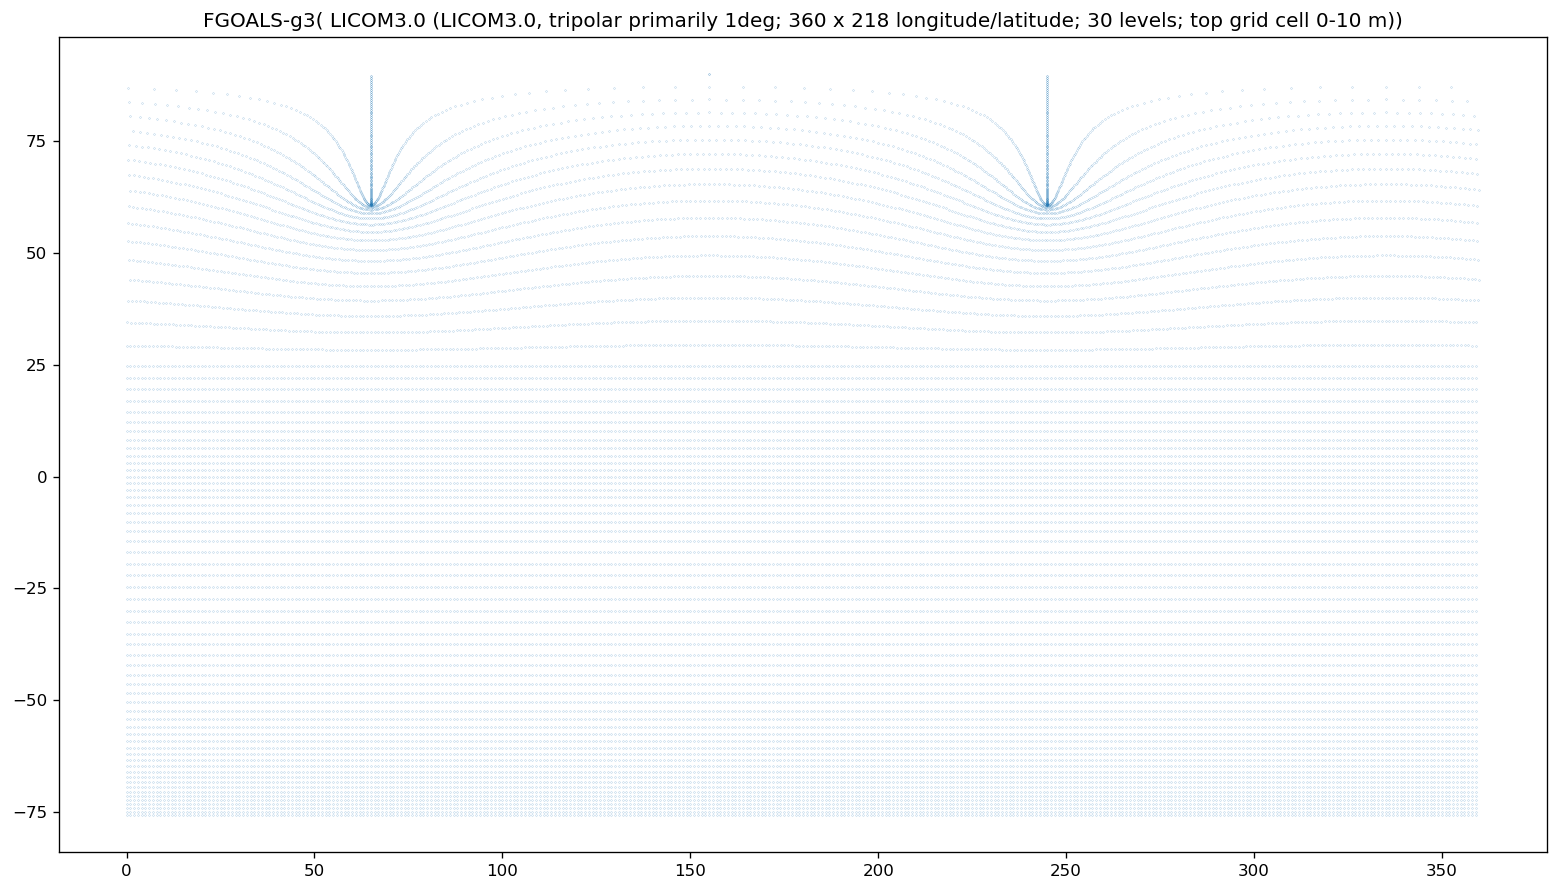

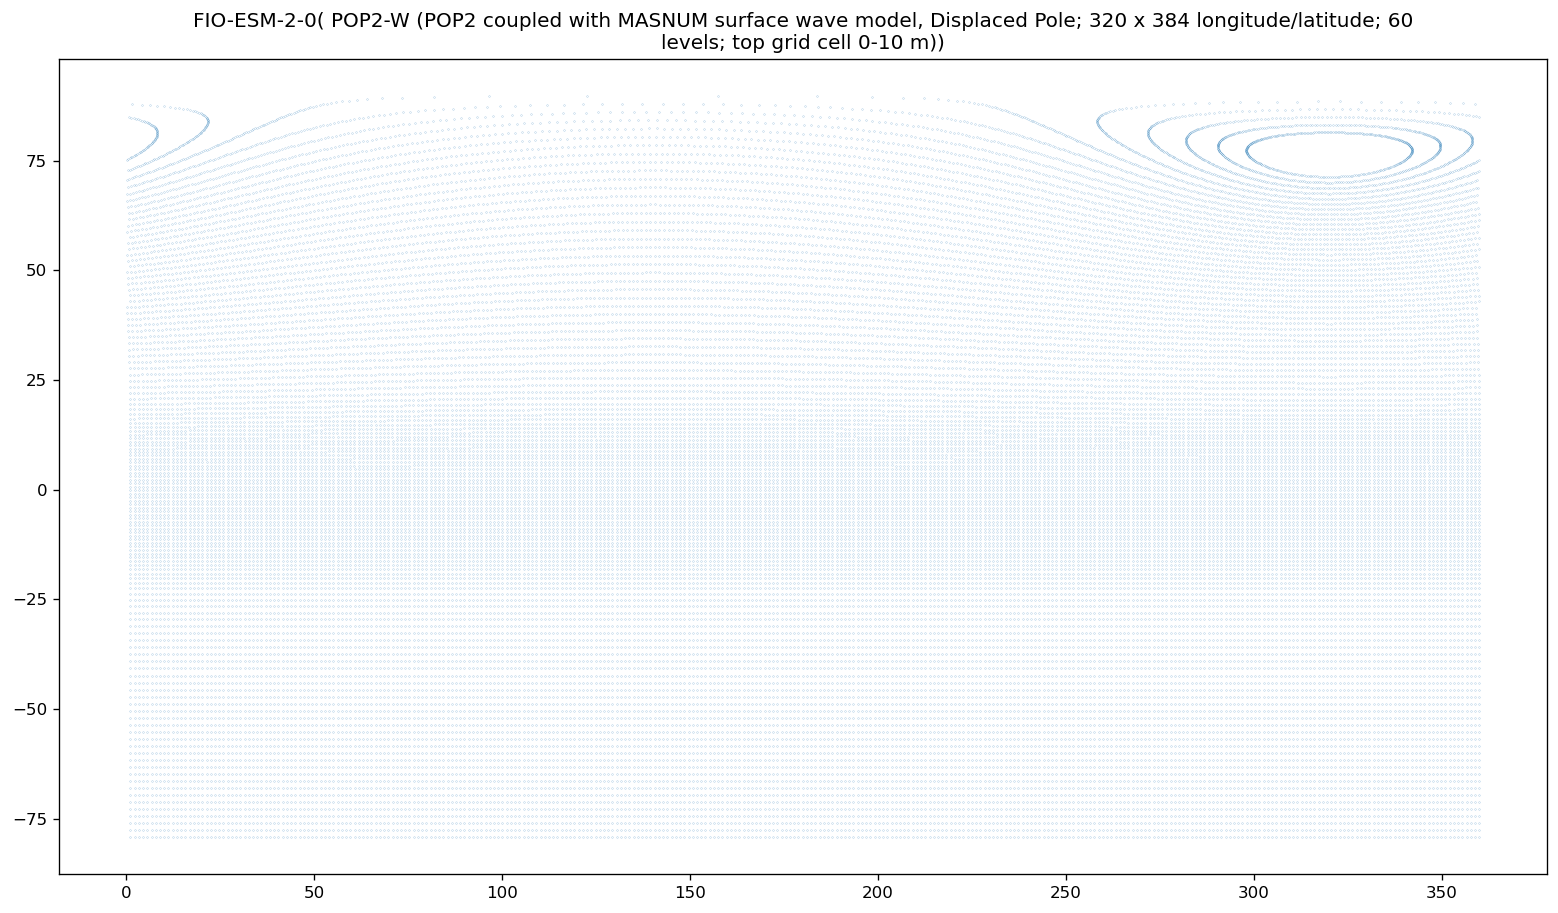

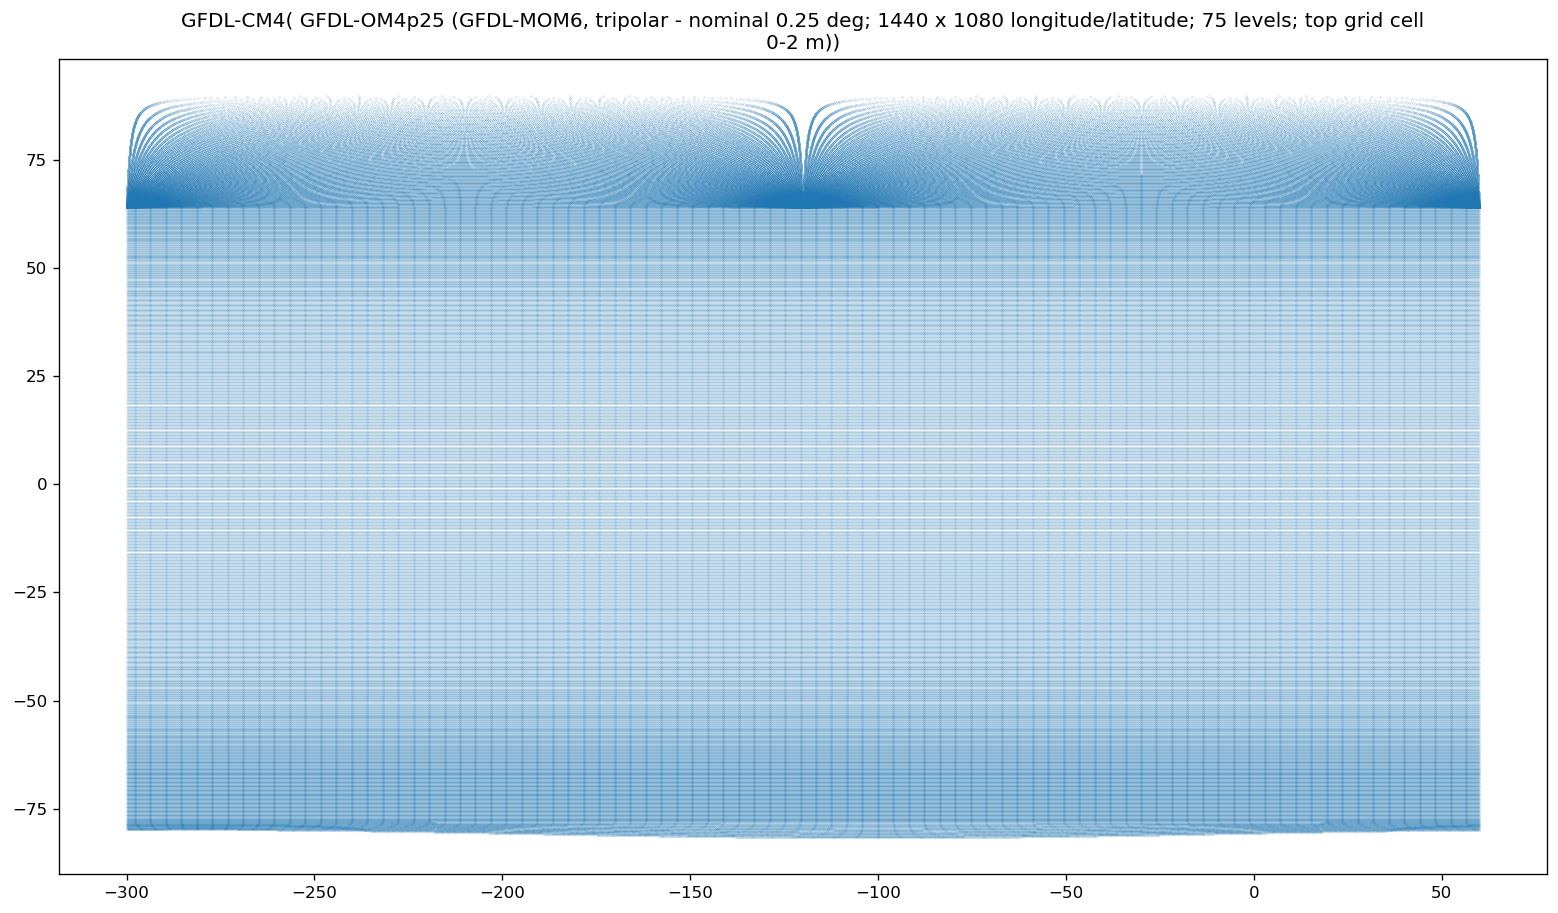

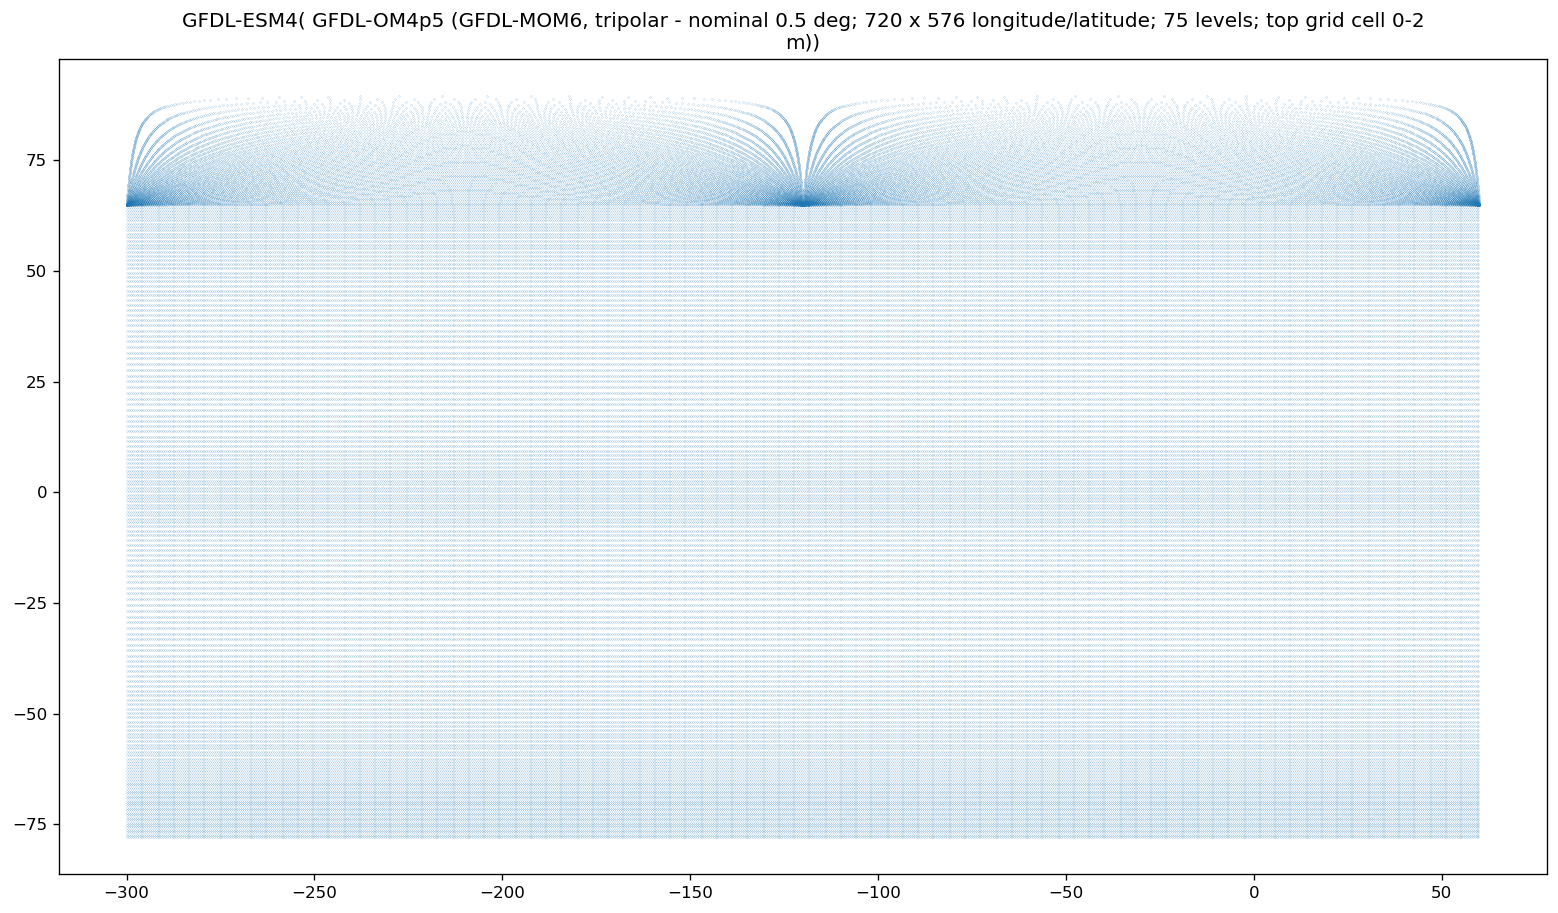

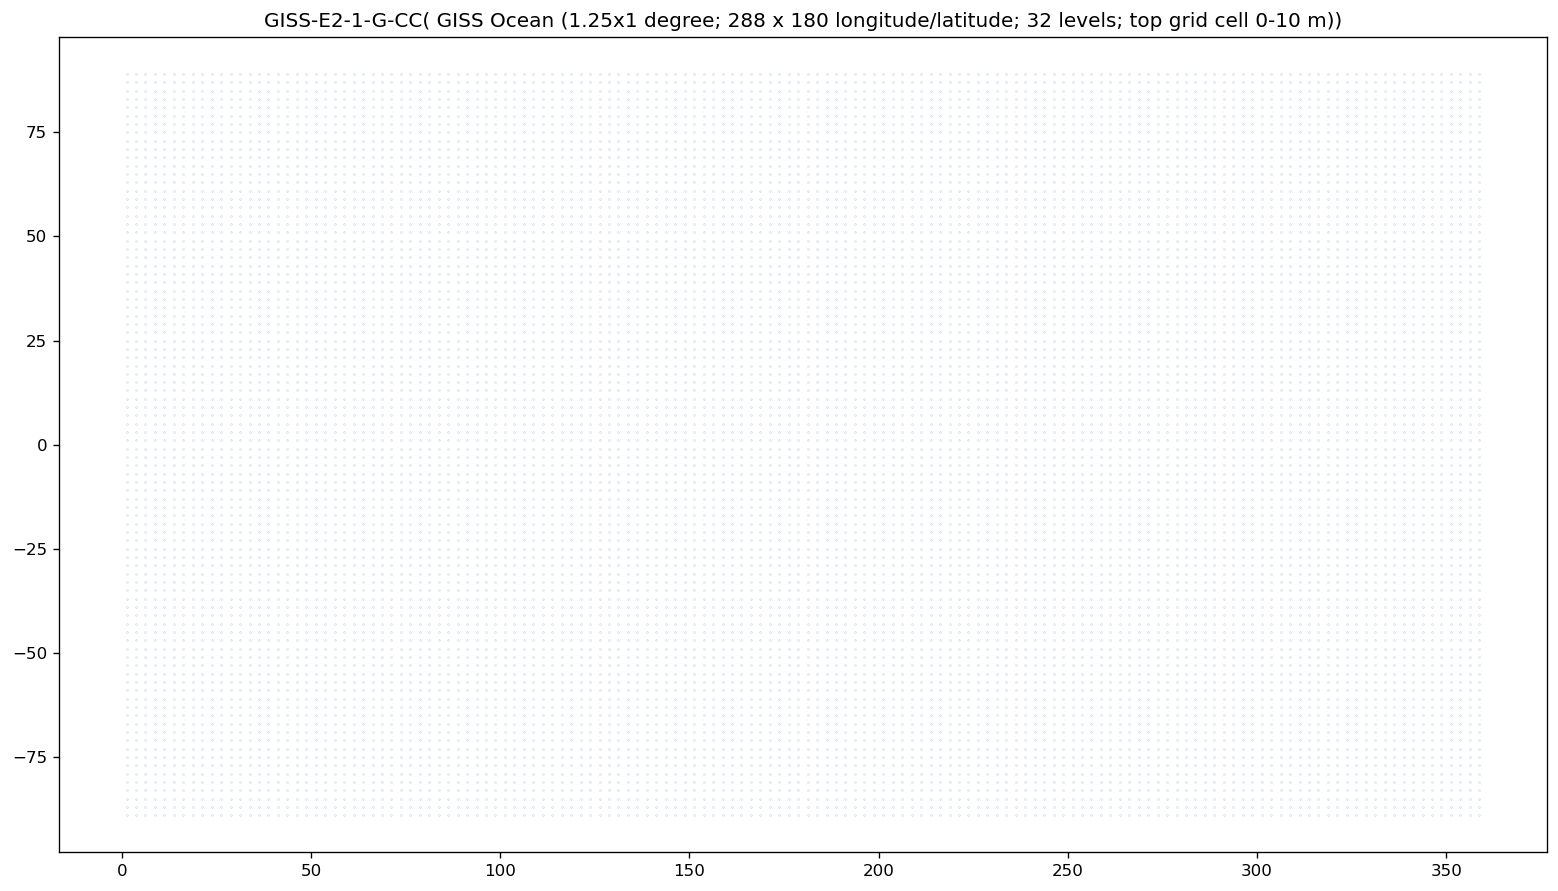

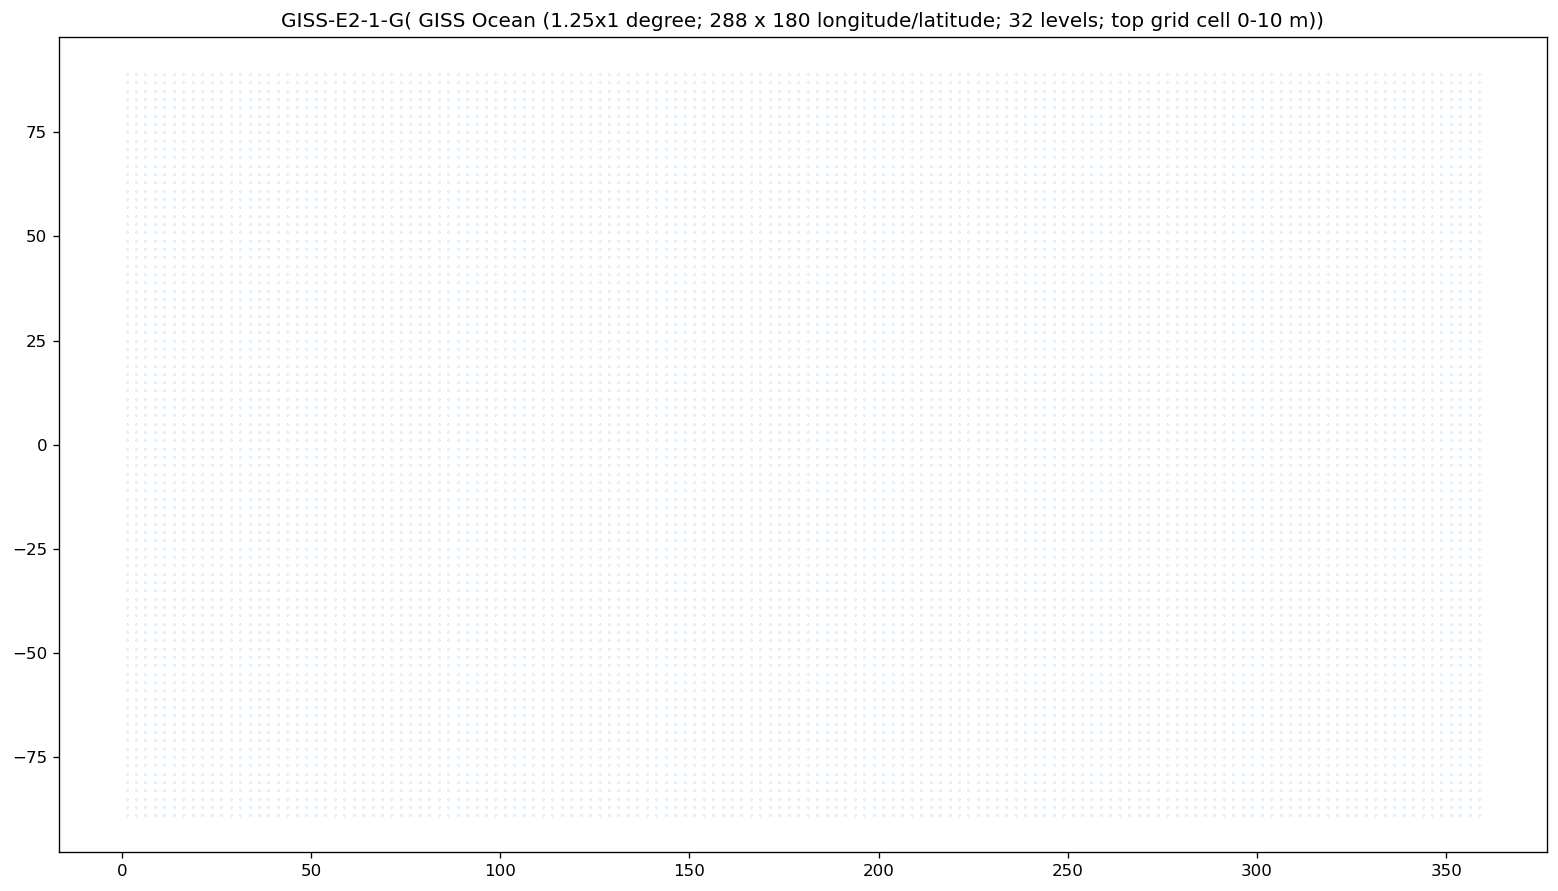

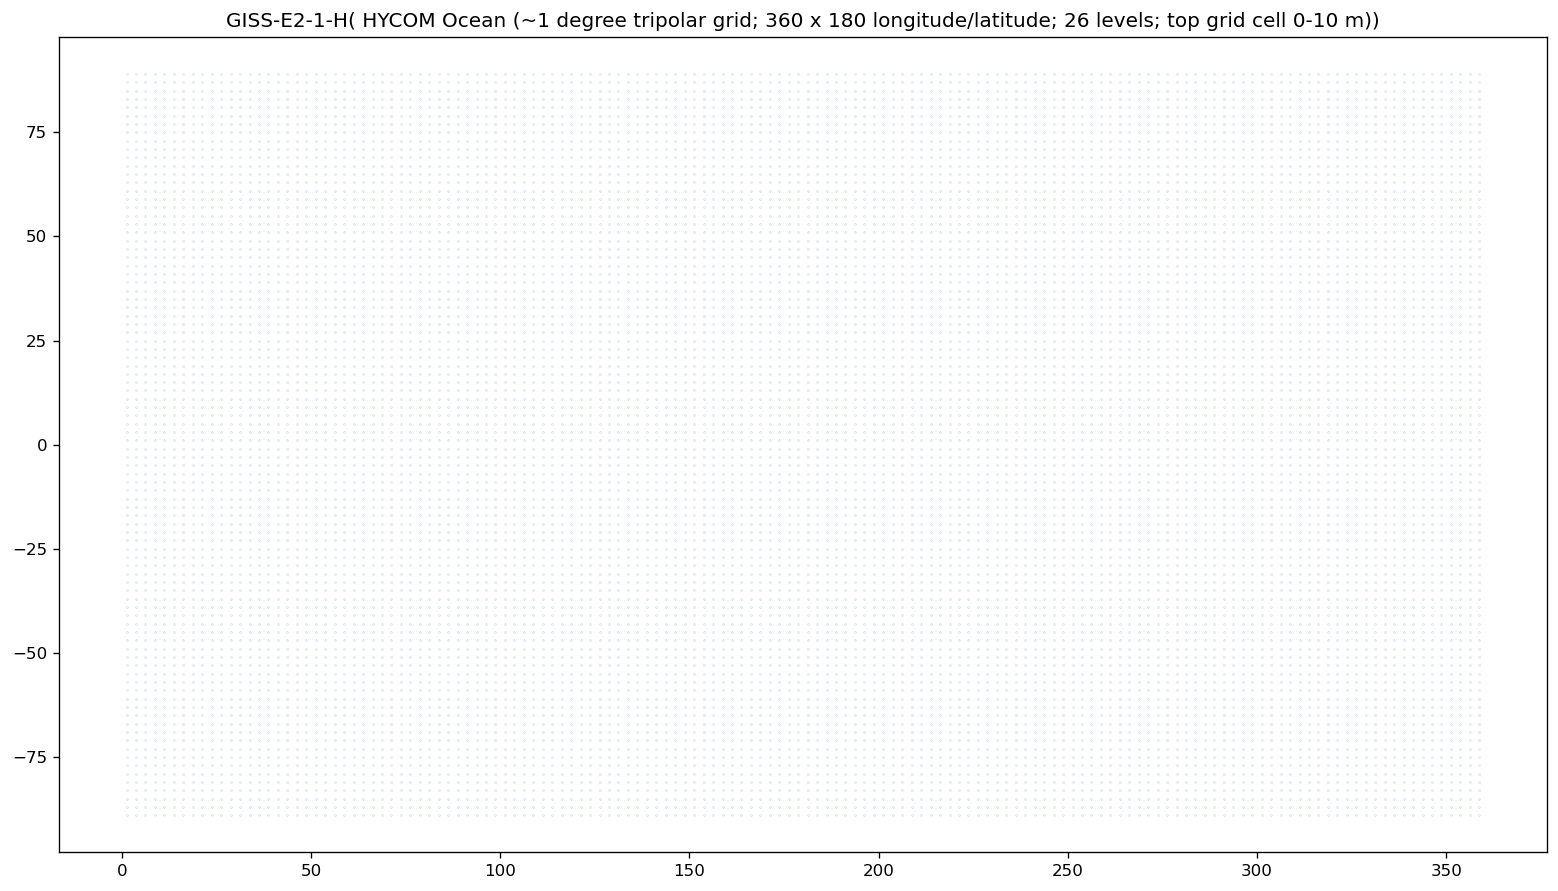

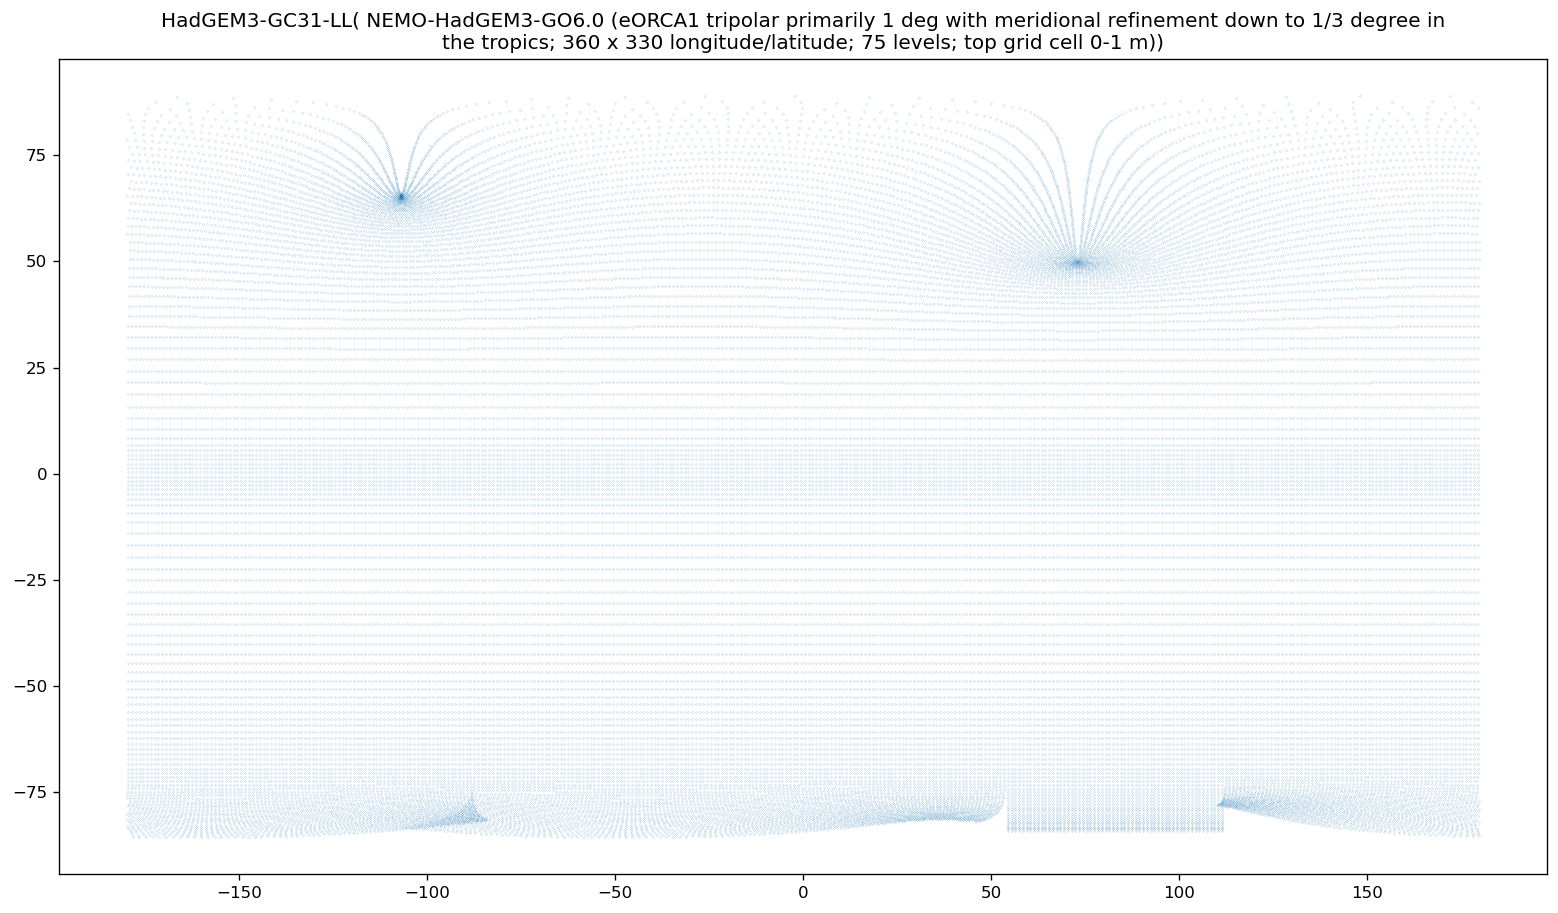

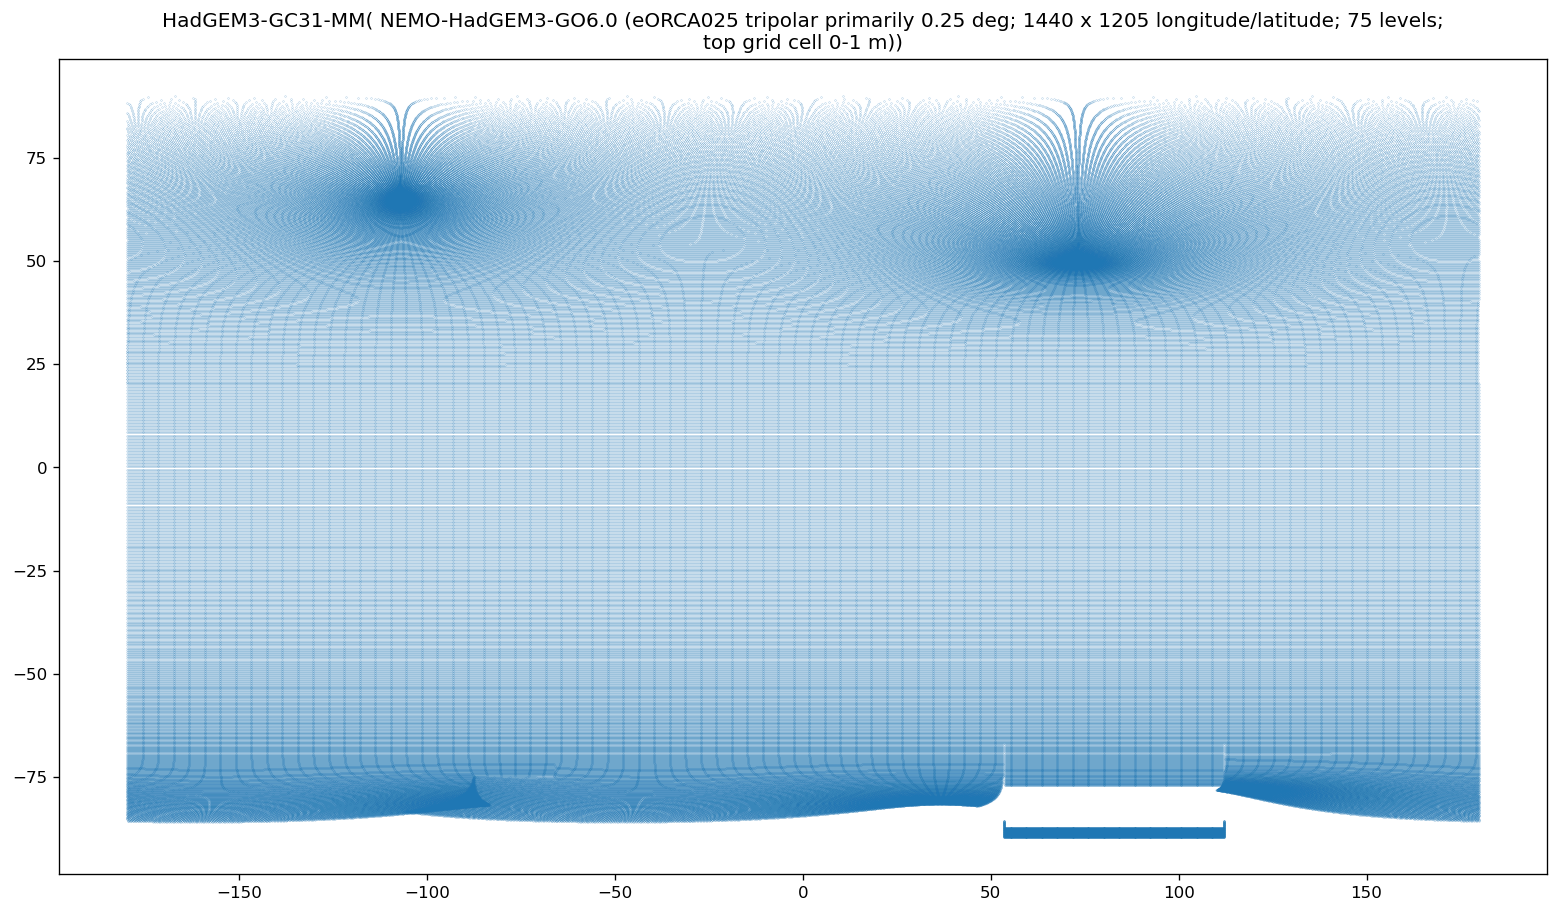

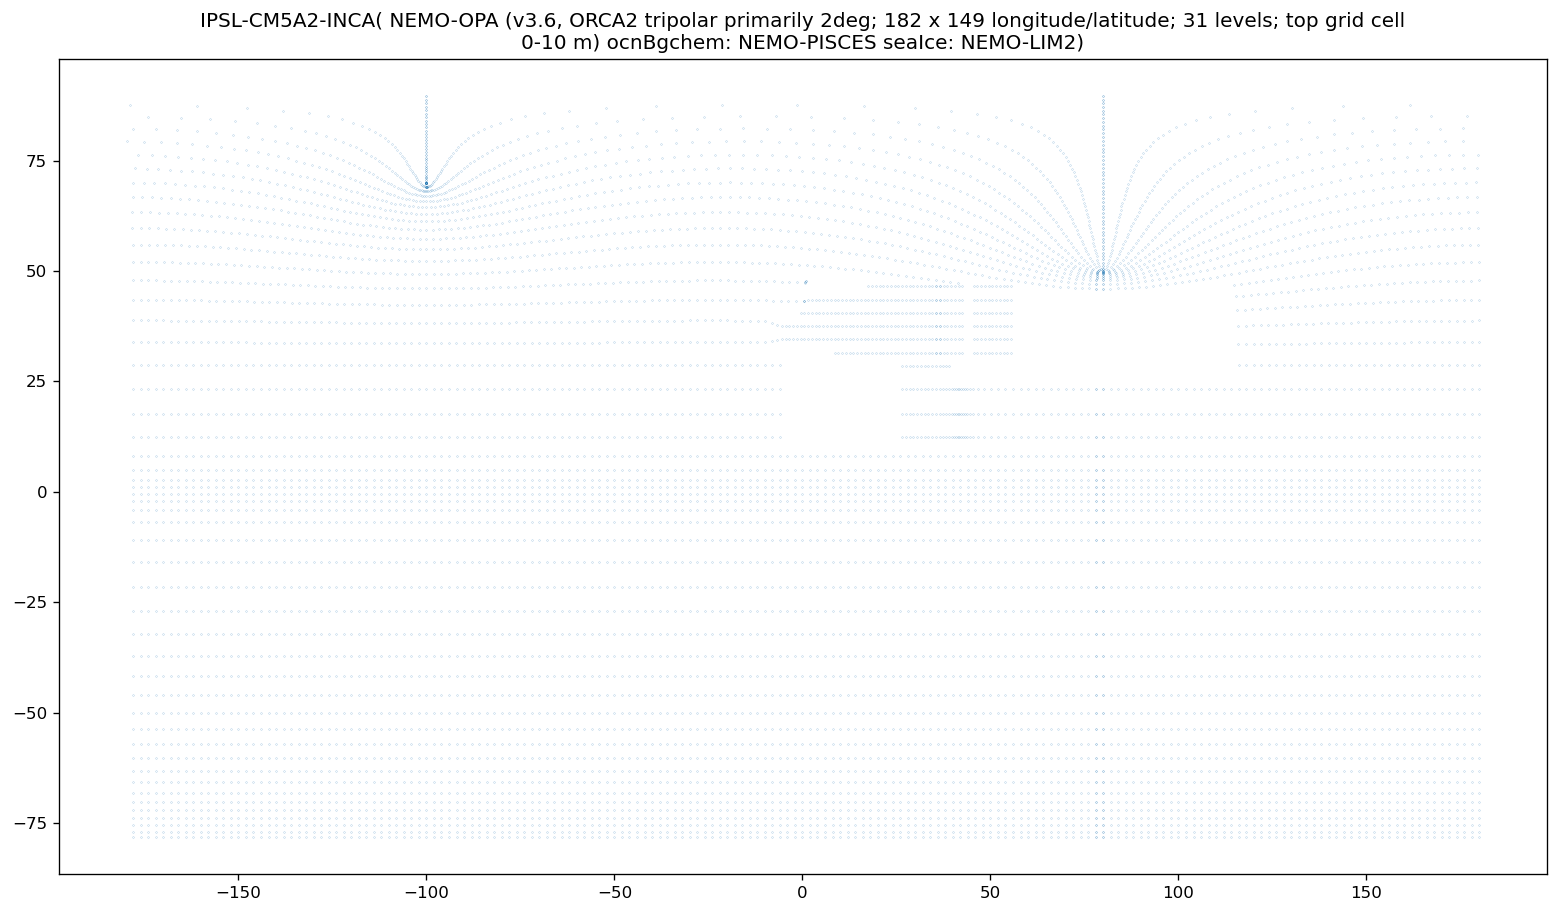

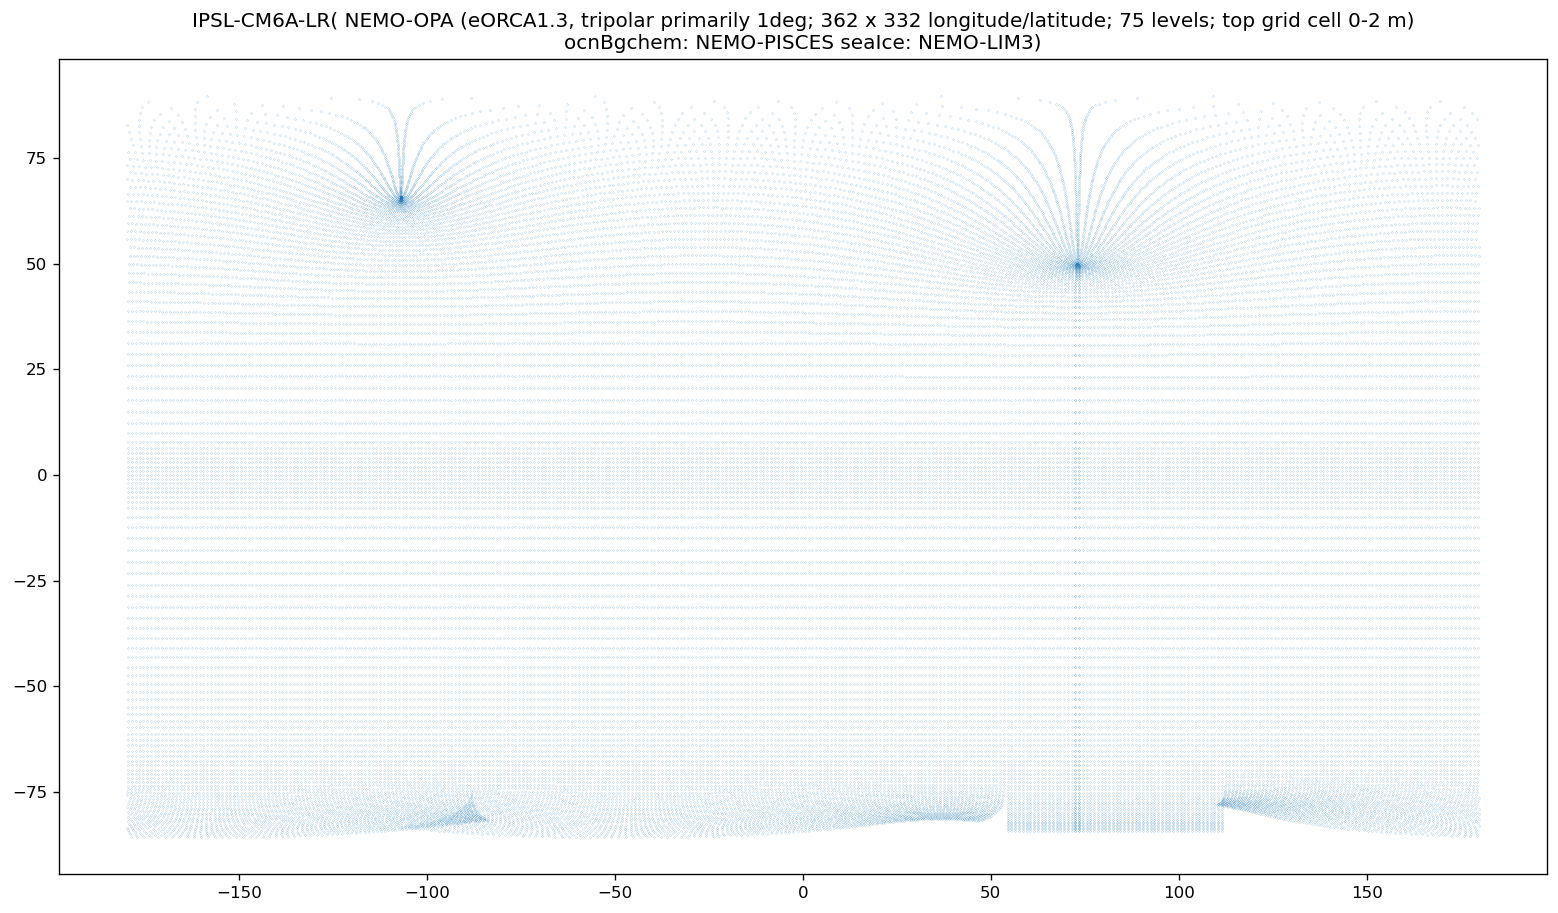

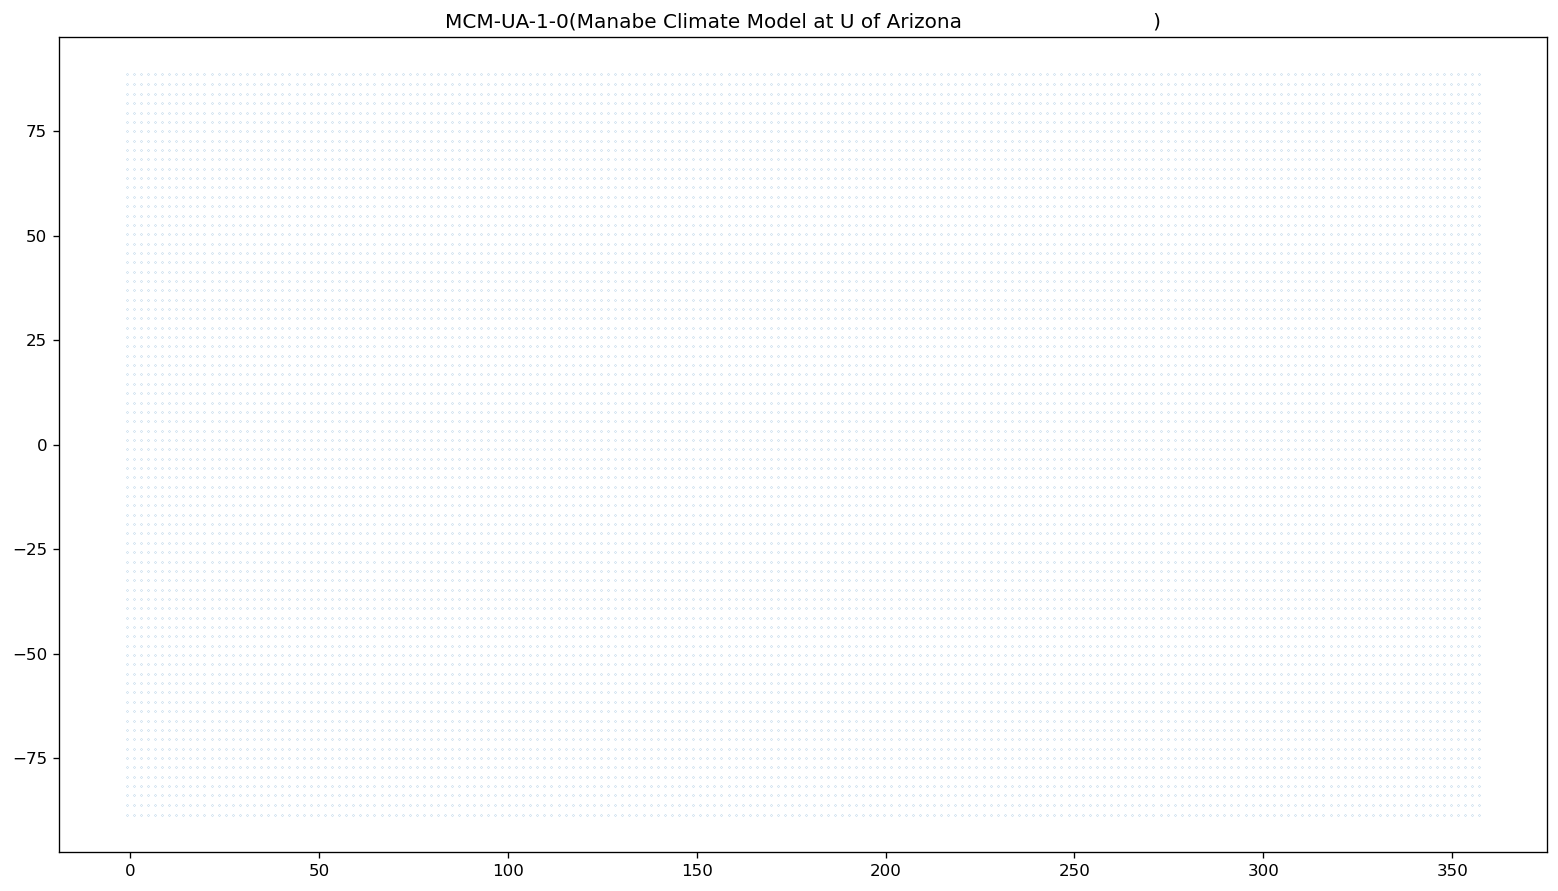

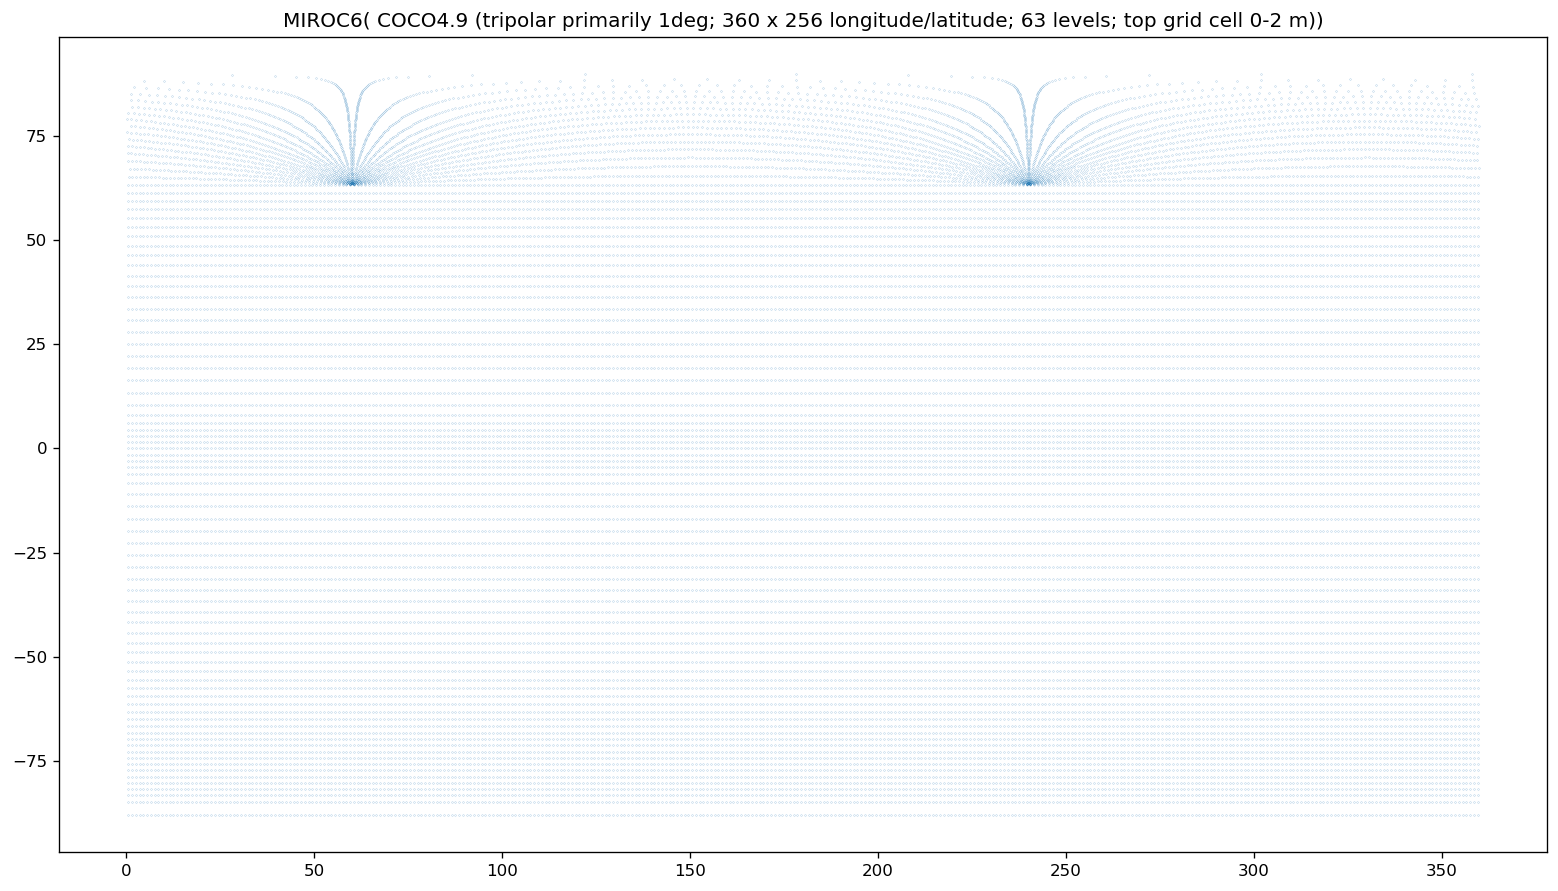

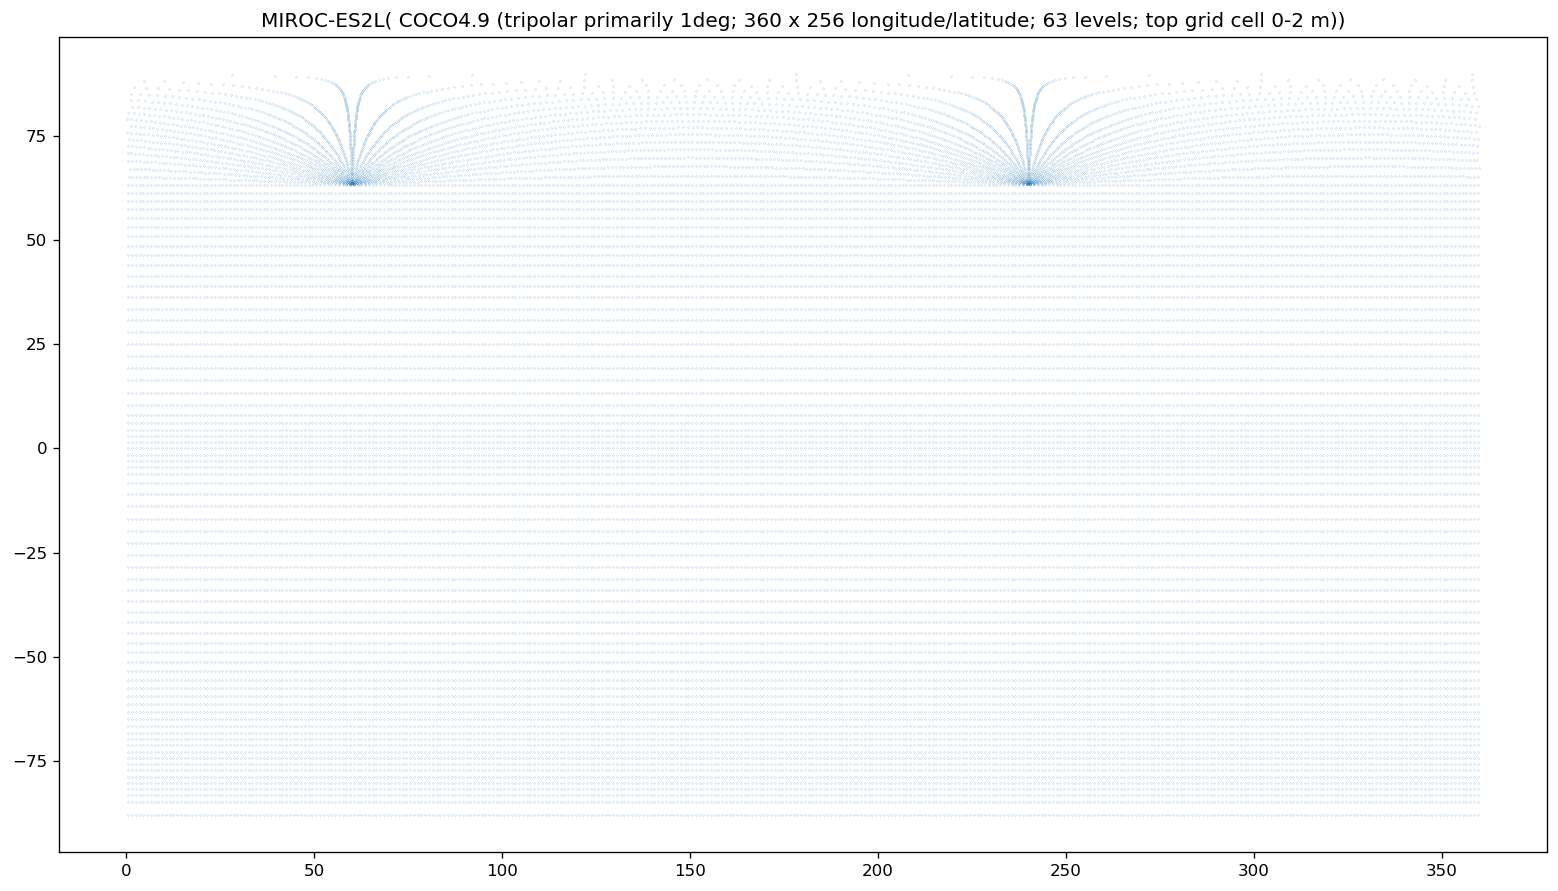

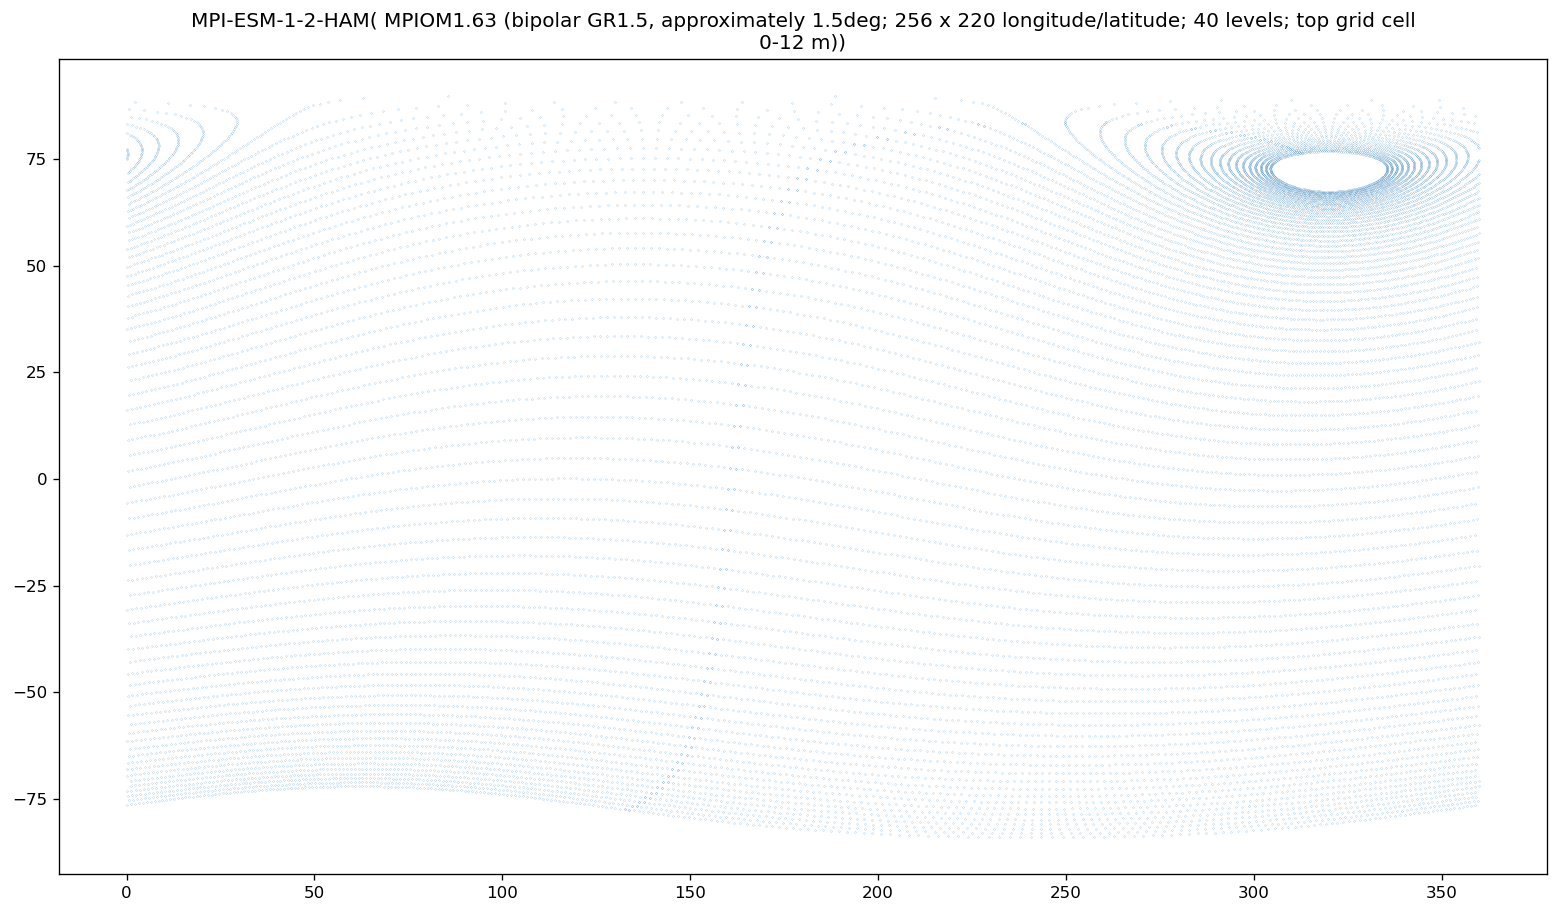

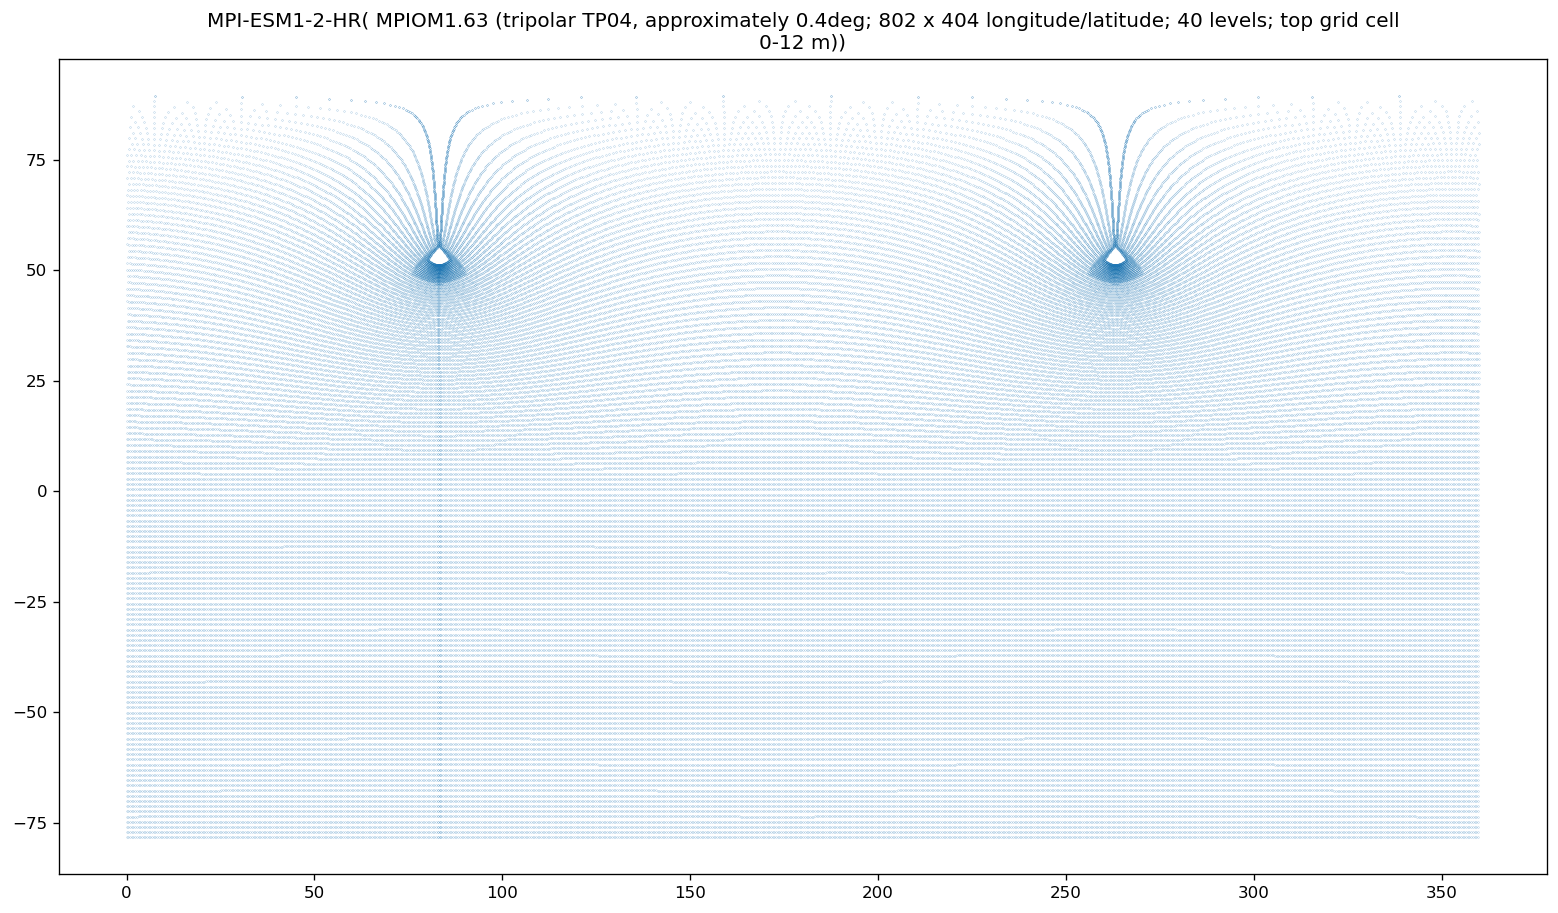

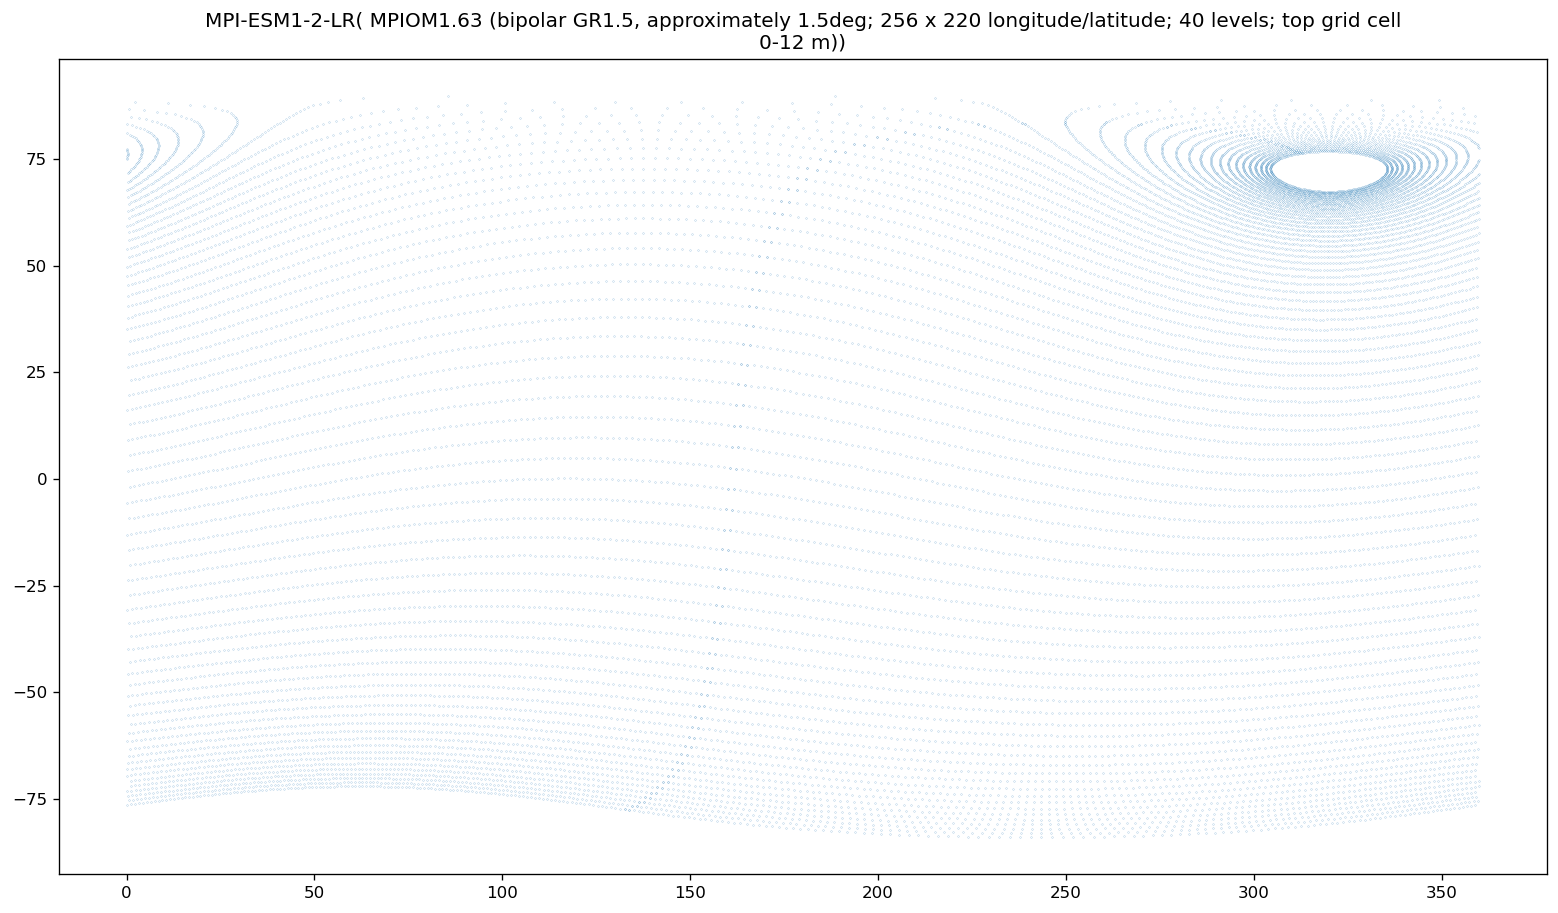

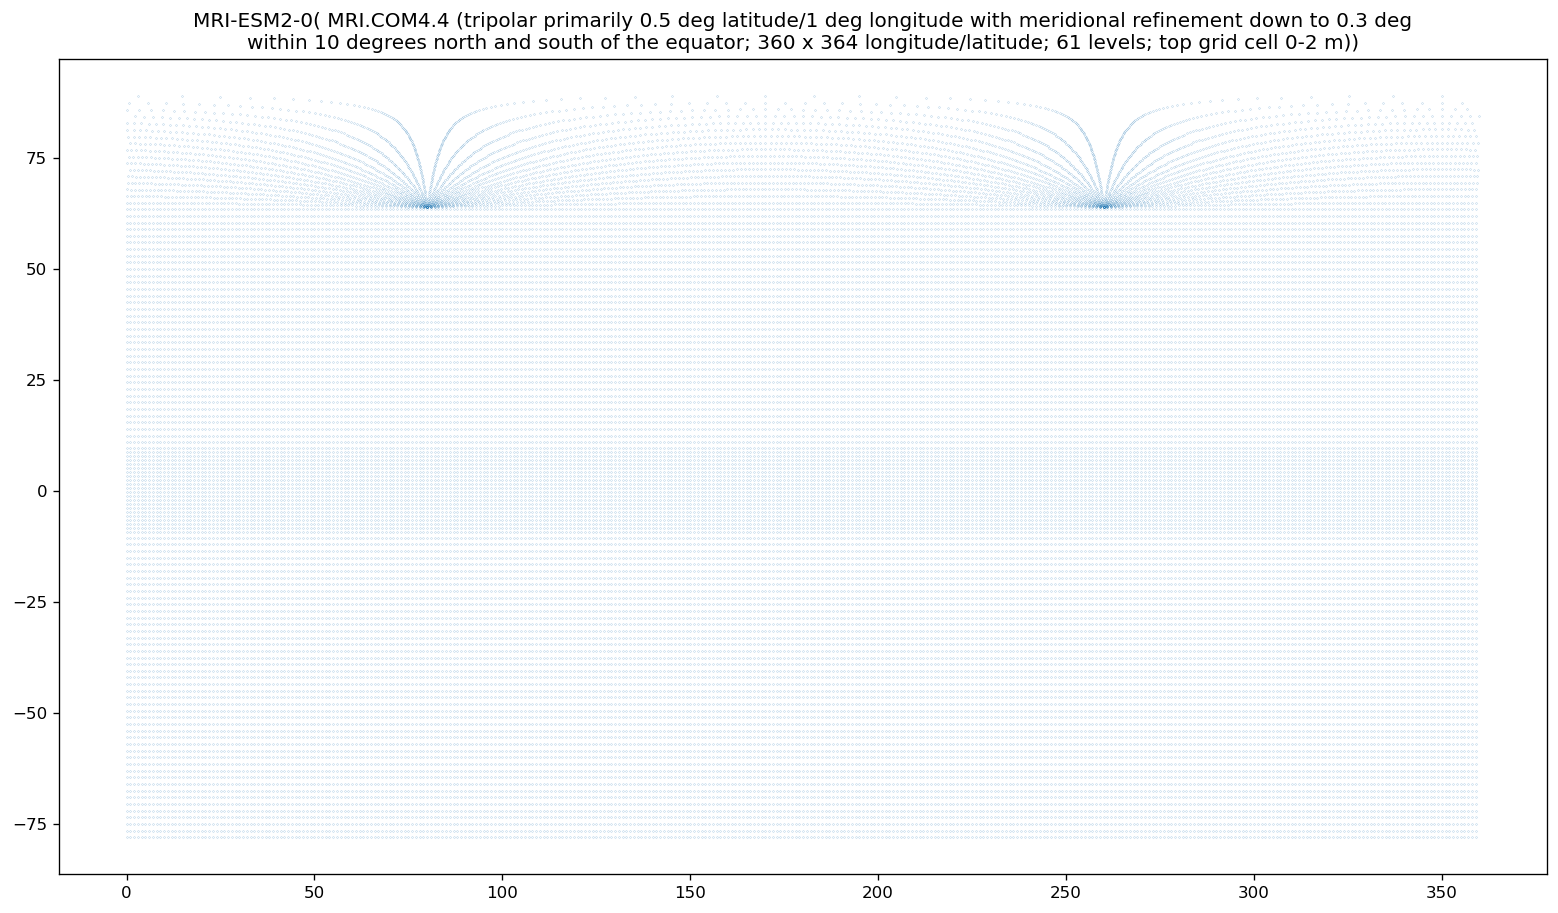

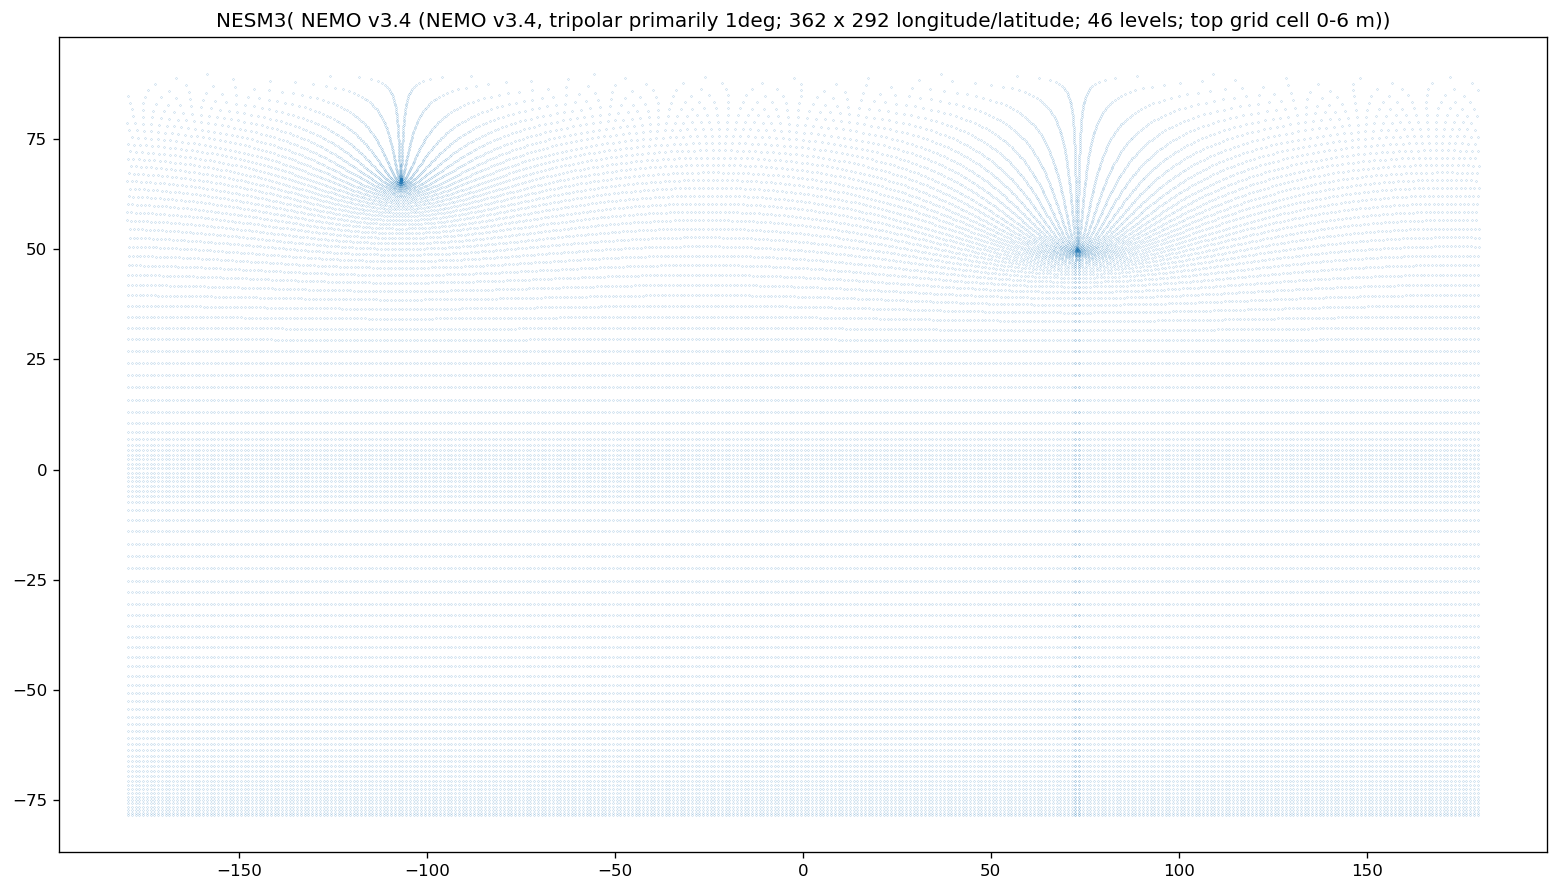

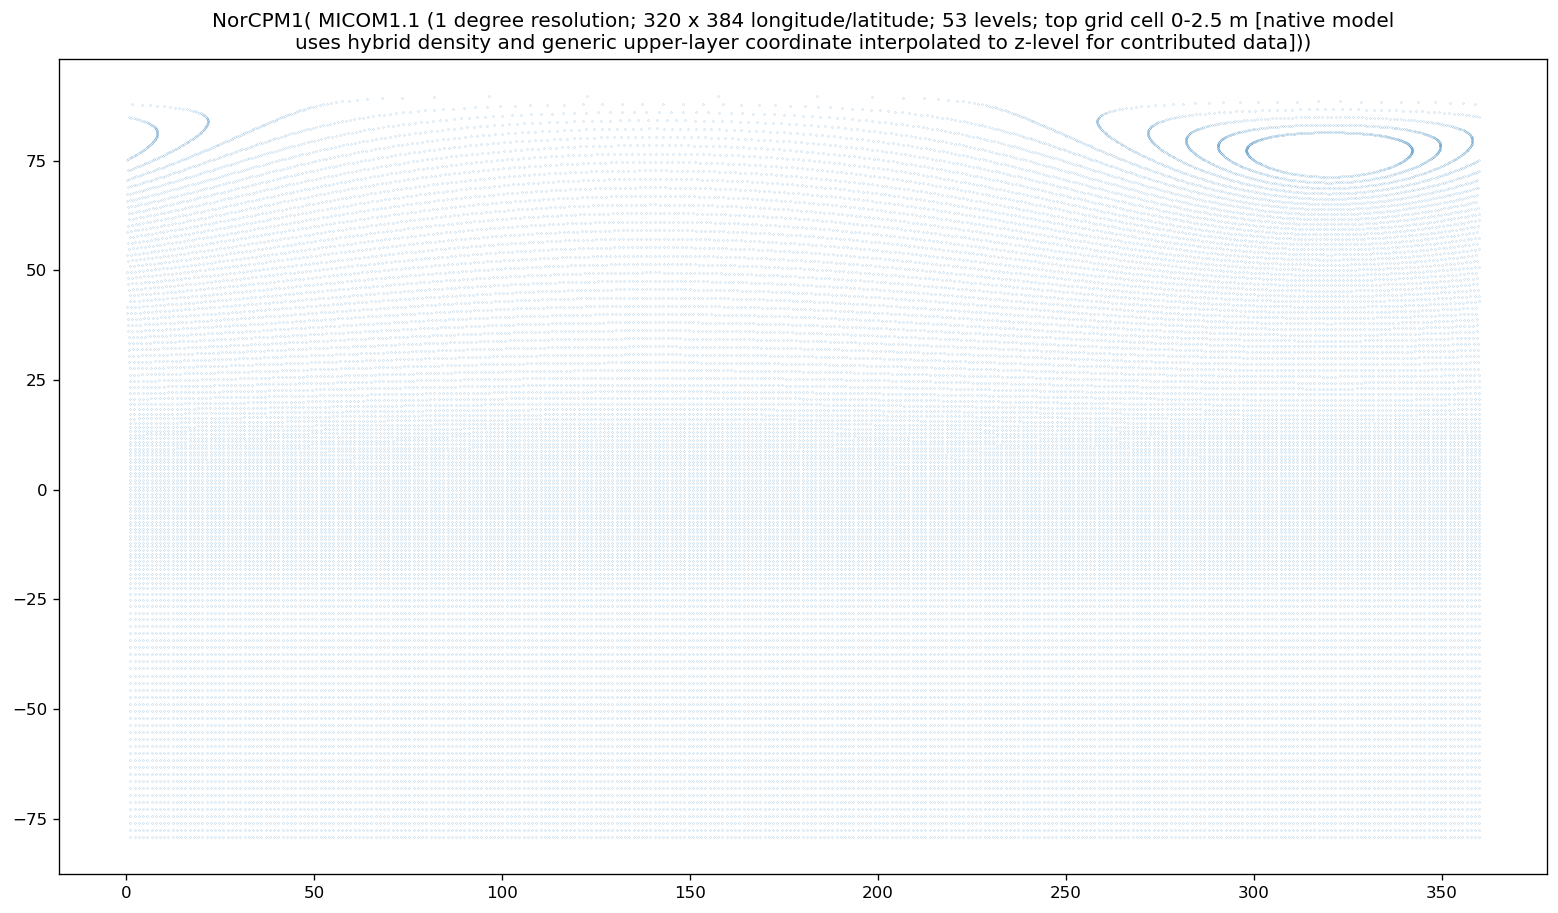

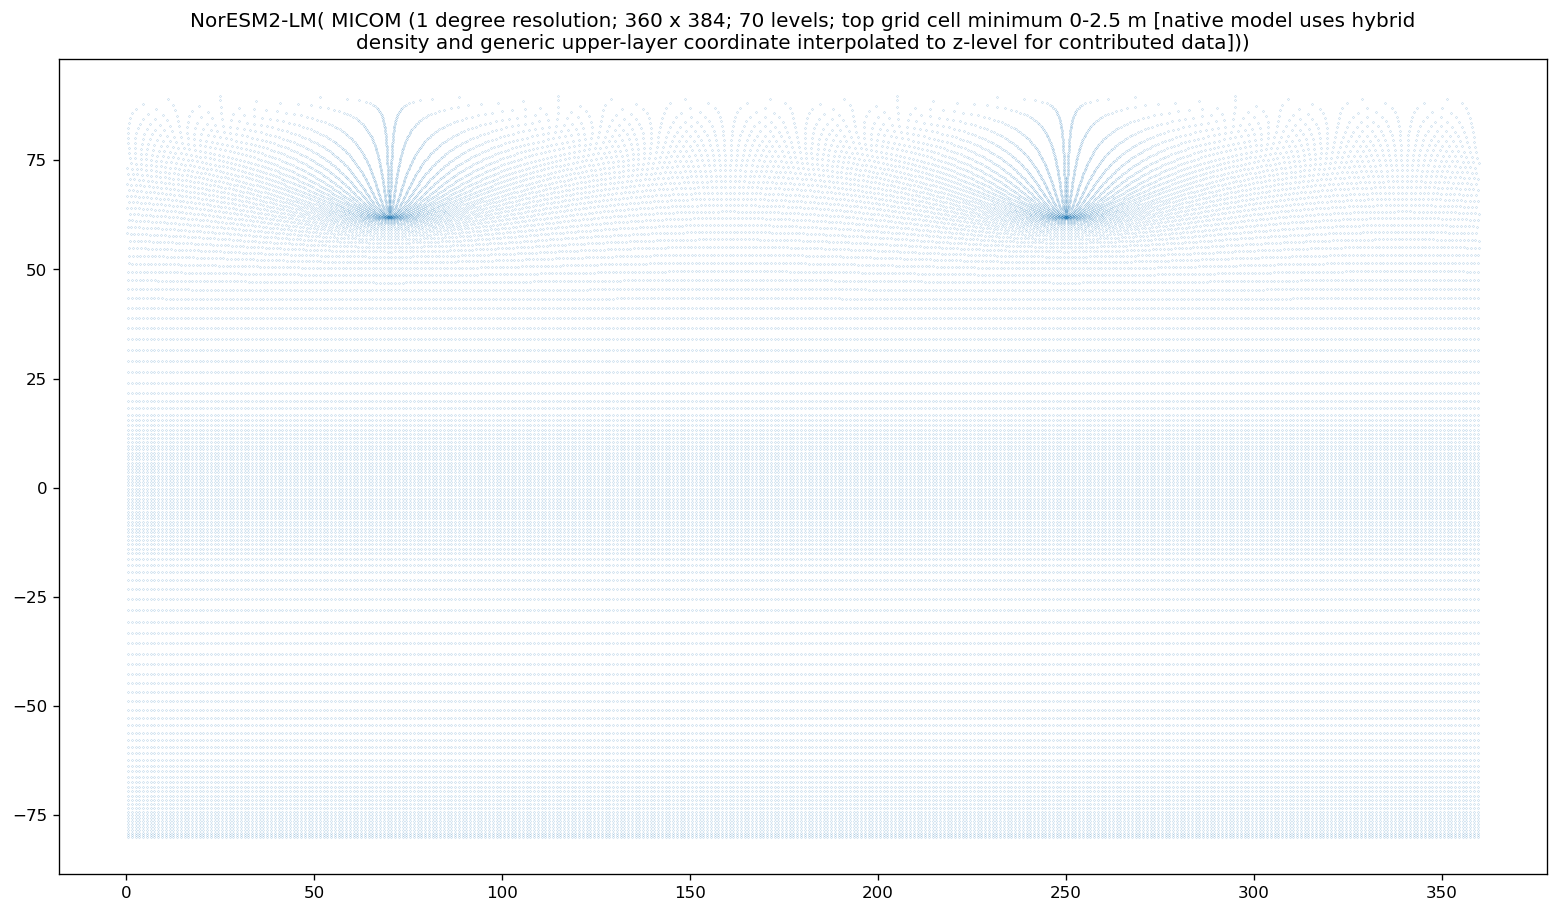

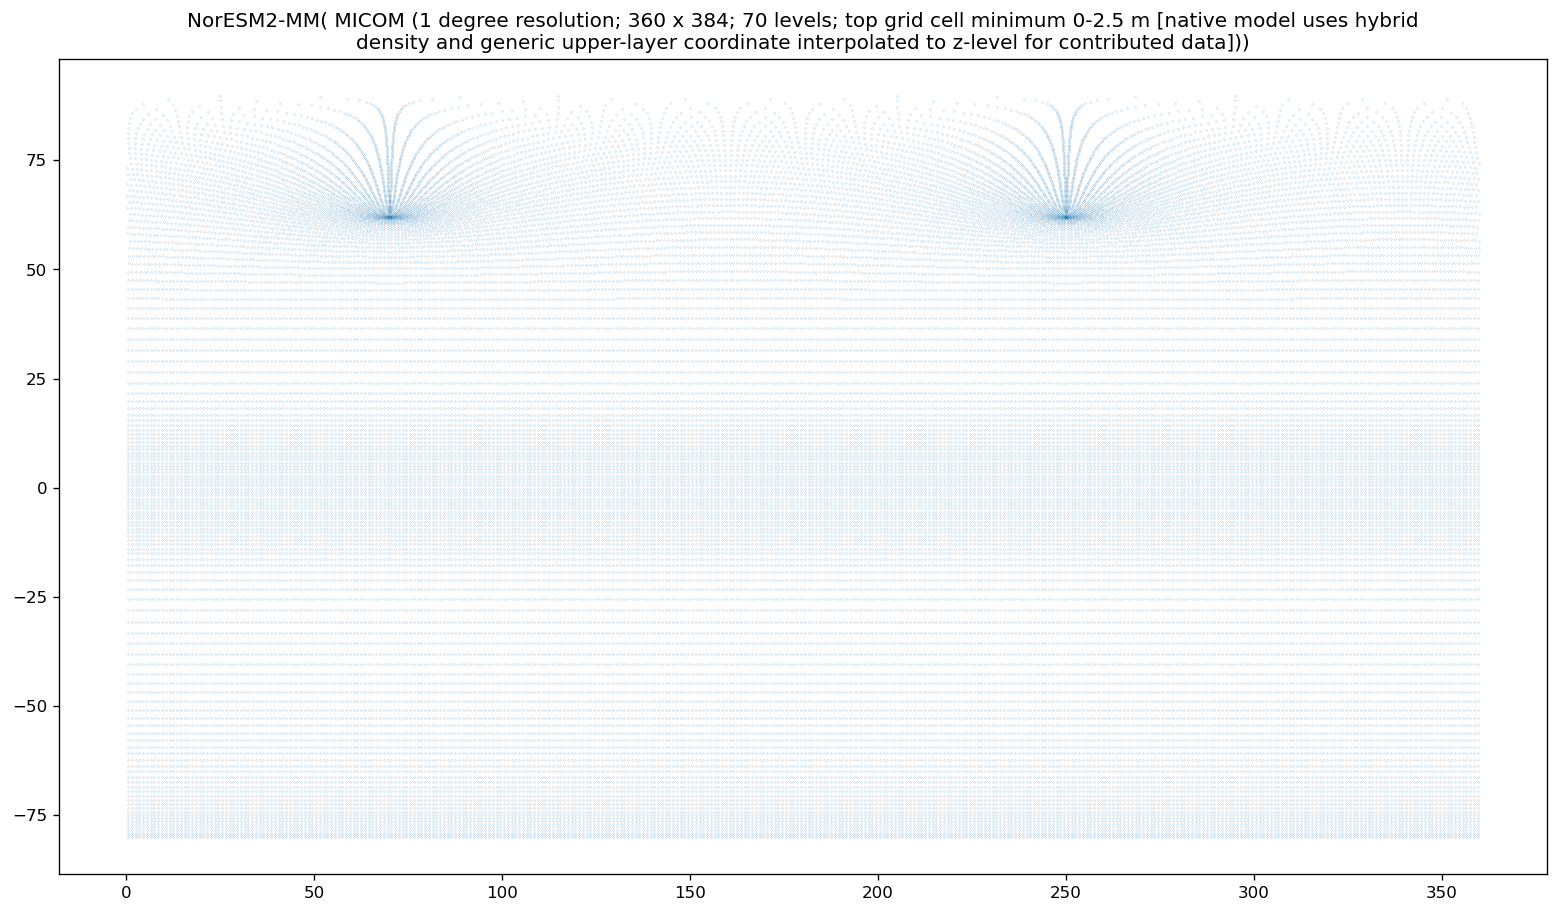

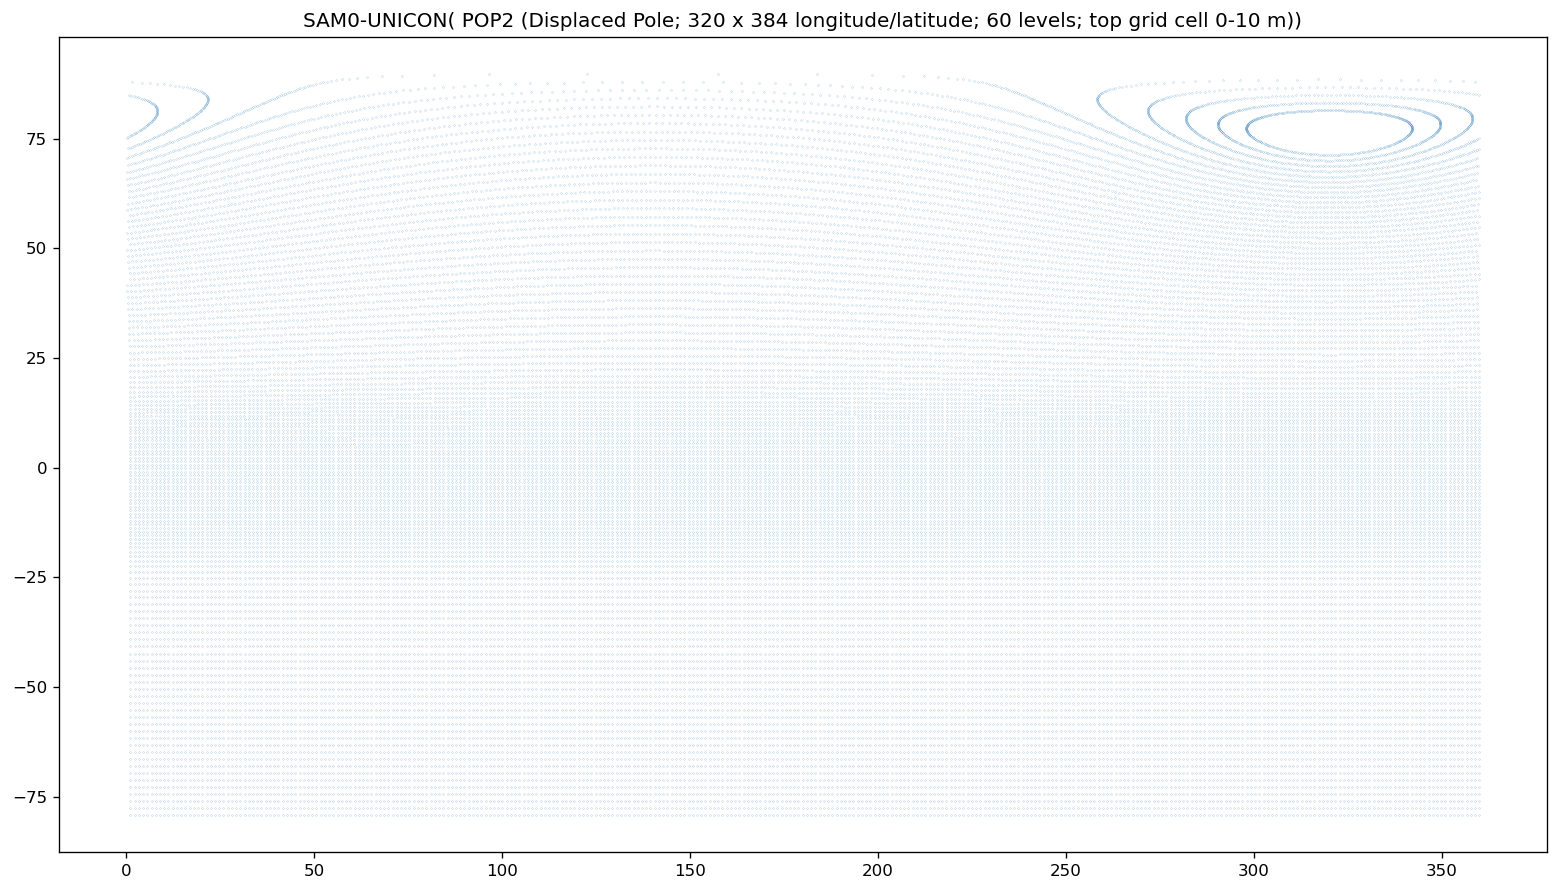

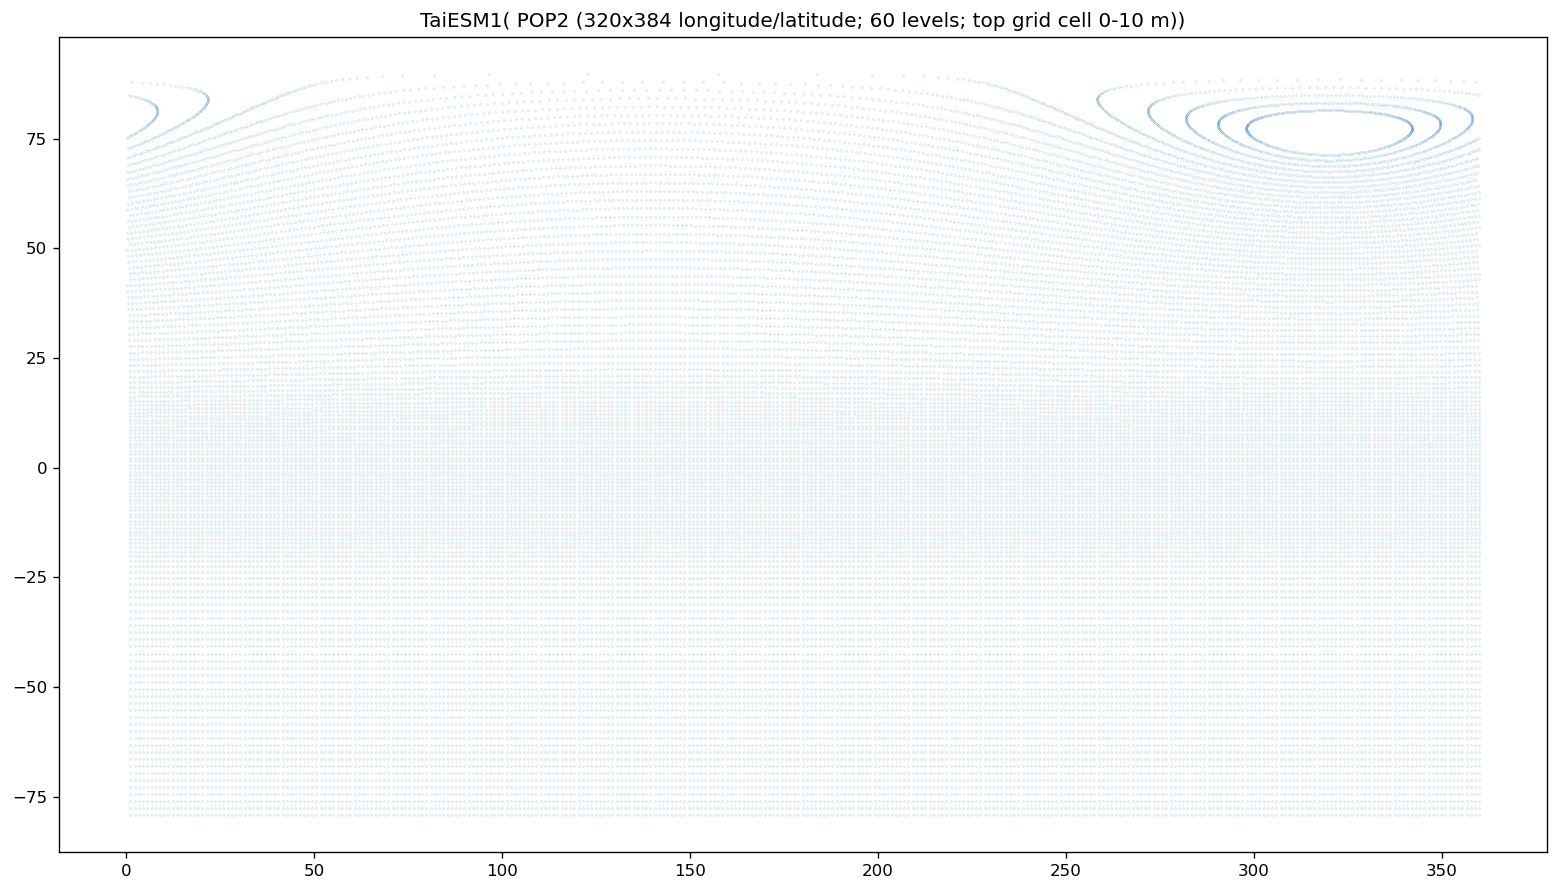

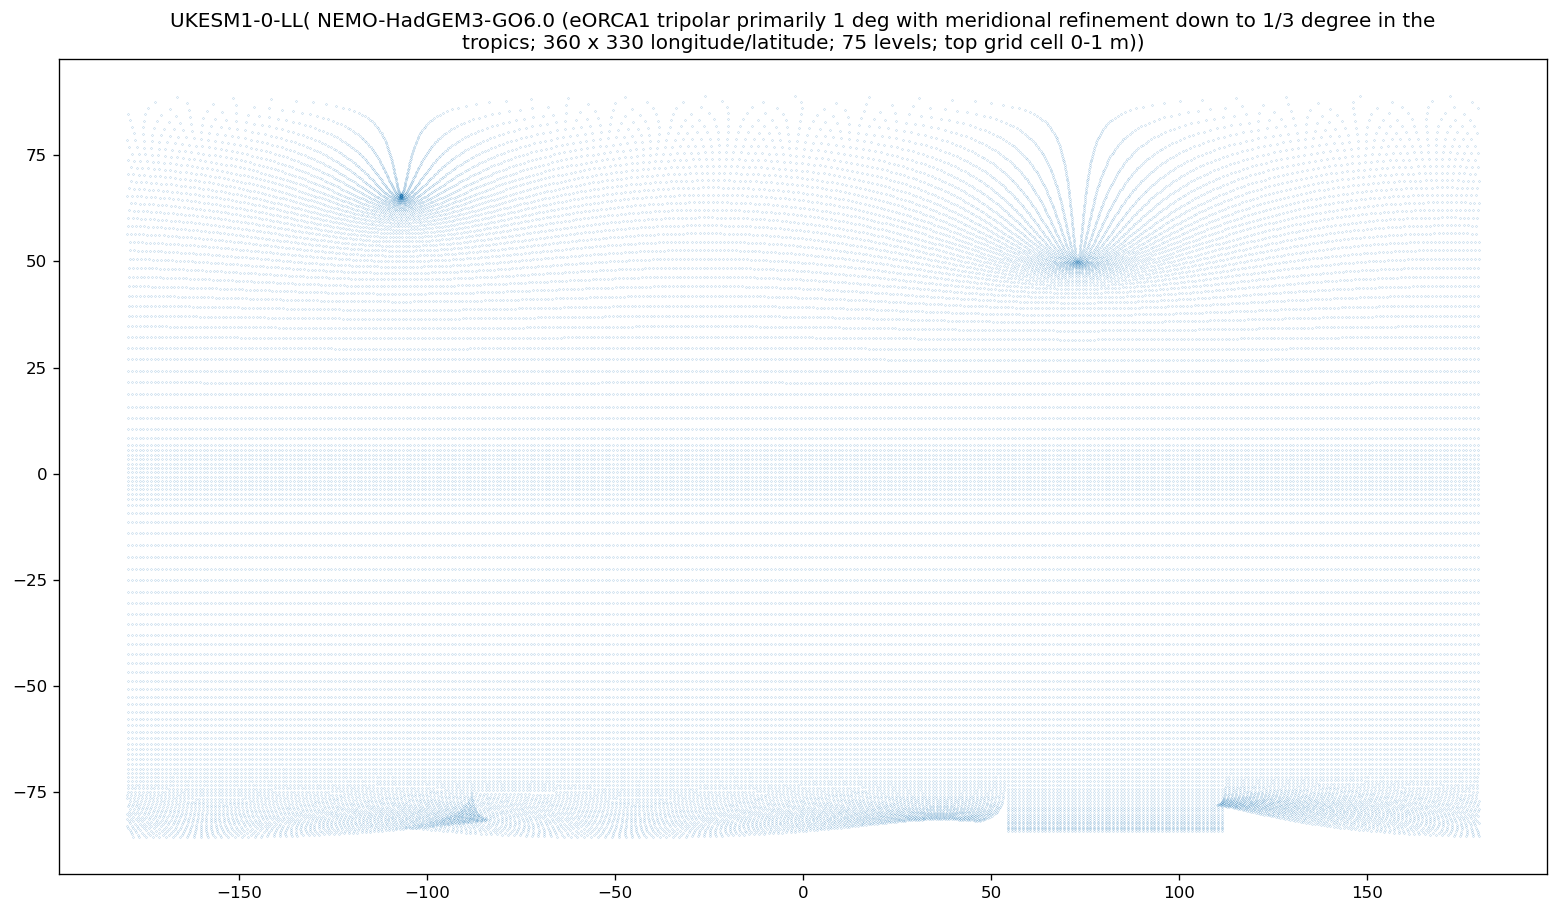

In [10]:
for ifile in ifiles:
    ds = xr.open_dataset(ifile).isel(time=0)  
    plot_grid(ds)